# BigTable MTLM
(Based on Cen 2009)
This model is used to explain the power law in learning.  In this notebook we try to build a neuralised version of the AFM and train it using simulated data.  The aim of using the AFM is to disentangle the latent traits that make up the overall score going into the sigmoid probability estimator.

The model is compensatory, which is a weakness.

In [237]:
from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt, log
from random import random, shuffle, choice, randint, uniform
import numpy
import math

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, mean, ones
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape, Dropout
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import constraints

import tensorflow as tf

from utils import generate_student_name
import random

from matplotlib import pyplot as plt

n_traits = 2



In [238]:
generate_student_name()

'PHIPH JECHI '

In [239]:
from keras import backend as K
from keras.constraints import Constraint
from keras.engine.topology import Layer
from keras import initializers

class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, min_w=0, max_w=4):
        self.min_w = min_w
        self.max_w = max_w

    def __call__(self, p):
        return K.clip(p, self.min_w, self.max_w)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'min_w': self.min_w,
                'max_w': self.max_w }


class ProductLayer(Layer):

    def __init__(self, output_dim, kernel_constraint=WeightClip(min_w=-4.0, max_w=4.0), minv=-4,maxv=4, **kwargs):
        
        self.output_dim = output_dim
        super(ProductLayer, self).__init__(**kwargs)
        self.kernel_constraint= constraints.get(kernel_constraint)
        self.min_v = minv
        self.max_v = maxv

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(1, self.output_dim),
                                      initializer=initializers.RandomUniform(minval=self.min_v,maxval=self.max_v),
#                                       initializer=initializers.Constant(value=2.0),
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        
        super(ProductLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        p = x * self.kernel
        print("shape p", p.shape)
        return p

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
class DifferenceLayer(Layer):

    def __init__(self, output_dim, kernel_constraint=WeightClip(min_w=-4.0, max_w=4.0), minv=-4,maxv=4, invert=False, **kwargs):
        
        self.output_dim = output_dim
        super(DifferenceLayer, self).__init__(**kwargs)
        self.kernel_constraint= constraints.get(kernel_constraint)
        self.min_v = minv
        self.max_v = maxv
        self.invert = invert

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        initialiser = initializers.RandomUniform(minval=self.min_v,maxval=self.max_v)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(1, self.output_dim),
                                      initializer=initialiser,
#                                       initializer=initializers.Constant(value=2.0),
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        super(DifferenceLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        if self.invert:
            x = tf.Print(x, [x], message="x is:", first_n=-1, summarize=1024)
            k = tf.Print(self.kernel, [self.kernel], message="- kernel is:", first_n=-1, summarize=1024)
            p = x - k
        else:
            k = tf.Print(self.kernel, [self.kernel], message="kernel is:", first_n=-1, summarize=1024)
            x = tf.Print(x, [x], message="- x is:", first_n=-1, summarize=1024)
            p = k - x
#         p = K.print_tensor(p, message="p is:")
        p =  tf.Print(p, [p], message="p is:", first_n=-1, summarize=1024)
        print("shape p", p.shape)
        return p

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [240]:
for z in [-20, -10, -4,-3,-2,-1,0,1,2,3,4]:
    print(z, 1/(1+exp(-z)) )

# q_p_avg = 0.45
n_traits = 2
q_p_easiest = 0.99
q_p_hardest = 0.01
mid = (q_p_easiest + q_p_hardest)/2.0

# pr_k_avg = q_p_avg**(1/n_traits)
# print("pr k avg:", pr_k_avg)

pr_k_easiest = q_p_easiest**(1/n_traits)
pr_k_hardest = q_p_hardest**(1/n_traits)
pr_k_mid = mid**(1/n_traits)

inv_sigmoid = lambda pr : ( -log((1/pr) -1) )
easy_comp_del = inv_sigmoid(pr_k_easiest)
hard_comp_del = inv_sigmoid(pr_k_hardest)

offset = (easy_comp_del - hard_comp_del)/2
beta_min = 0
beta_max = round(offset,1)
theta_min = round(easy_comp_del - offset,1)
theta_max = round(easy_comp_del,1)

# beta_min = 0
# theta_min = 0
# # theta_max = math.ceil(max_comp_del)
# # beta_max = math.ceil(-min_comp_del)
# theta_max = round(easy_comp_del,1)
# beta_max = (-round(abs(hard_comp_del),1))

print(beta_min, beta_max)
print(theta_min, theta_max)

worst_comp_pr = 1/(1+exp(-(theta_min - beta_max)))
best_comp_pr = 1/(1+exp(-(theta_max - beta_min)))

print("worst cmp chance=", worst_comp_pr)
print("best cmp chance=", best_comp_pr)

print("worst Pr=", worst_comp_pr**n_traits)
print("best Pr=", best_comp_pr**n_traits)


nom = array([
    [1,2,3],
    [4,5,6],
    [7,8,9],
])

sel = nom[[0,2]]
print(sel)
print(sel.shape)
n_traits = 2

-20 2.0611536181902037e-09
-10 4.5397868702434395e-05
-4 0.01798620996209156
-3 0.04742587317756678
-2 0.11920292202211755
-1 0.2689414213699951
0 0.5
1 0.7310585786300049
2 0.8807970779778823
3 0.9525741268224334
4 0.9820137900379085
0 3.7
1.5 5.3
worst cmp chance= 0.09975048911968513
best cmp chance= 0.995033198349943
worst Pr= 0.009950160079616422
best Pr= 0.9900910658185169
[[1 2 3]
 [7 8 9]]
(2, 3)


In [241]:
class BigTable(Layer):

    def __init__(self, _dim, min_w=0, max_w=10, **kwargs):
        self.dim = _dim
        self.limits = (min_w, max_w)
        kc =kernel_constraint=WeightClip(min_w, max_w)
        self.kernel_constraint= constraints.get(kc)
        super(BigTable, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        min_w, max_w = self.limits
        av_w = (min_w + max_w)/2.0
        initialiser = initializers.RandomUniform(min_w, max_w)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.dim),
                                      initializer=initialiser,
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        print("kk", self.kernel.shape)
        super(BigTable, self).build(input_shape)  # Be sure to call this at the end

    def call(self, selector):
        print("selector shape", selector.shape)
        selector = K.flatten(selector)
        print("flat selector shape", selector.shape)
        print("call kk", self.kernel.shape)
        selector = tf.Print(selector, [selector], message="selector is:", first_n=-1, summarize=1024)
# #         row = tf.gather(self.kernel, [selector], axis=0)
#         rows = self.kernel[selector]
#         rows = tf.gather(self.kernel, selector, axis=1)
        rows = K.gather(self.kernel, selector)
#         rows = K.reshape(rows, (-1,self.dim[1]))
#         rows = K.flatten(rows)
# #         row = self.kernel
        rows = tf.Print(rows, [rows], message="row is:", first_n=-1, summarize=1024)
#         rows = self.kernel
        print("'rows' shape,",rows.shape)
        return rows

    def compute_output_shape(self, input_shape):
        return ((None, self.dim[1]))


In [242]:
class Question():
    def __init__(self, qix, min_diff, max_diff, nt=None, nnw=None, optimiser=None):
        #self.MAX_BETA = 15
        self.id = qix
#         no_dummies = randint(1,(nt-1))
        no_live = 2
#         print("no_dummies=",no_dummies)
        not_present= -10
#         min_diff = 0
#         max_diff = 10
        self.betas = [ not_present for _ in range(nt) ]
        choices = random.sample(range(nt), no_live)
        for c in choices:
            self.betas[c] = round(random.randint(10*min_diff,10*max_diff)/10,1)
#             self.betas = [ round(random.randint(10*min_diff,10*max_diff)/10,1) for _ in range(nt)]


In [243]:
class Student():
    def __init__(self, psix, min_abil, max_abil, nt=None, nnw=None, optimiser=None):
        #self.MAX_BETA = 15
        self.id = psix
        self.name = generate_student_name()
#         min_abil = 0
#         max_abil = 10
        self.thetas = [ round(random.randint(10*min_abil, 10*max_abil)/10,1) for _ in range(nt) ]
#         self.mastery = [0 for _ in range(nq)]
#         self.o_practice = [0 for _ in range(nq)]
#         self.h_practice = [0 for _ in range(nt)]
        #print("Made q with betas:", self.betas)


In [244]:
def attempt_q(student: Student, q: Question):
    p = calculate_pass_probability(student.thetas, q.betas)
    this_att = uniform(0,1)
    if (this_att <= p):
        passed=1.0
#         student.mastery[q.id] = 1
    else:
        passed=0.0

    return passed

In [245]:
def calculate_pass_probability(thetas, betas):
    # additive factors model is:
    # p_pass = 1 / 1 + exp(-z)
    # where z = a + sum[1:n]( -b + gT )
    
    p_pass = 1.0
#     print("th,b",thetas,betas)
    for th,b in zip(thetas,betas):
        z = (th-b)
        p_pass_step = 1.0 / (1.0 + exp(-z))
#         print(th,"vs",b,"->",z,": ", p_pass_step)
        p_pass *= p_pass_step # simple conjunctive model of success!
    try:        
        print("p_pass={}".format(p_pass))
    except OverflowError:
        p_pass = 0.0
    #print("real p_pass = {}".format(p_pass))
    return p_pass
    

In [246]:
qopt = Adam()

def create_qs(n_qs, nt=n_traits, nnw=n_traits, optimiser=qopt):
    random.seed(666)
    master_qs = [Question(qix, beta_min,beta_max, nt=nt, nnw=nnw, optimiser=optimiser) for qix in range(n_qs)]
    for q in master_qs:
        nocomps = len(q.betas)
        mag = sqrt(sum([ pow(b, 2) for b in q.betas if b!=-10 ]))
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, nocomps))
    
    for q in master_qs:
        print("qid",q.id,q.betas)
    
    qn_table = BigTable((n_qs, nnw),min_w=beta_min, max_w=beta_max)
    
    return master_qs, qn_table

# Training
This is where sh!t gets real.  We take our tr_len (1000?) students, and iterate over them 100 times to create 100,000 *complete examples* of a student attacking the curriculum.  The questions themselves are attacked in random order: the student has no intelligent guidance throught the material. (Obvious we may wish to provide that guidance at some point in the future.)

Remember, there are only 12 exercises in the curriculum, so if the student is taking 60 or 70 goes to answer them all, that's pretty poor.  But some of these kids are dumb as lumber, so cut them some slack!  They will all get there in the end since by the CMU AFM practice will, eventually, make perfect!

In [247]:
psi_opt = Adam()
def create_students(n_students, nt=n_traits, nnw=n_traits, optimiser=None):
    random.seed(666)
    psi_list = [ Student(psix, theta_min,theta_max, nt=nt, nnw=nnw, optimiser=optimiser) for psix in range(n_students)]
    for psi in psi_list:
        print(psi.name, psi.thetas)
        
    psi_table = BigTable((n_students, nnw), min_w=theta_min, max_w=theta_max)
    psi_attn_table = BigTable((n_students, 1), min_w=0, max_w=1)
    print("psi_table wgts", psi_table.get_weights())
    
    return psi_list, psi_table
    

In [248]:
extend_pop=False
extend_by = 90
if extend_pop:
    for _ in range(extend_by):
        nu_psi = Student(nt=n_traits, nq=len(master_qs), optimiser=psi_opt)
        psi_list.append(nu_psi)

In [249]:
import gc
def generate_attempts(master_qs, psi_list):
    attempts =[]
    attempts_by_q = {}
    attempts_by_psi = {}

    user_budget = math.inf
    user_patience = 100
    pass_to_remove = False
    for run in range(1):
        print("----{}\n".format(run))
        for psi in psi_list:
            spend=0
            #psi.mastery = [0 for _ in range(nq)]
            qs = [ix for ix in range(len(master_qs))]
            print("* * * **** USER {}".format(psi.name))
            print("* * * * ** THETAS {}".format(psi.thetas))

            while(True):
                q_ct = 0
                qix = random.choice(qs)
                q = master_qs[qix]
                passed=False

                if psi.name not in attempts_by_psi:
                    attempts_by_psi[psi.name]=[]

                if q not in attempts_by_q:
                    attempts_by_q[q]=[]

                while not passed and q_ct<user_patience:
                    passed = attempt_q(psi, q)
                    tup = (psi.id, q.id, passed)
                    attempts.append(tup)
                    attempts_by_psi[psi.name].append(tup)
                    attempts_by_q[q].append(tup)
                    q_ct+=1
                    if (not pass_to_remove):
                        break

                if (not pass_to_remove) or passed:
                    if passed:
                        print("passed")
                    qs.remove(qix)
                    print("removed", qix)

                spend += 1

                if qs == [] or spend>=user_budget:
                        print("* ** *QFIN USER {}".format(psi.name))
                        break
    gc.collect()
    return attempts, attempts_by_q, attempts_by_psi

# def generate_q_model(qn_table, optimiser):
#     thetas_in = Input(shape=n_traits, name="thetas_in")
#     qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
#     qn_row = qn_table(qn_sel)
#     dif = subtract([thetas_in, qn_row])
#     Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="sPr_sigmoid")(dif)
#     Pr = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)
#     model = Model(inputs=[qn_sel, psi_sel], outputs=Pr)
#     model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["mse","accuracy"])
#     return model  

# def generate_psi_model(psi_table, optimiser):
#     betas_in = Input(shape=n_traits, name="thetas_in")
#     psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
#     psi_row = psi_table(psi_sel)
#     dif = subtract([psi_row, betas_in])
#     Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="sPr_sigmoid")(dif)
#     Pr = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)
#     model = Model(inputs=[qn_sel, psi_sel], outputs=Pr)
#     model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["mse","accuracy"])
#     return model  

    
def generate_model(qn_table, psi_table, optimiser, mode="q_train"):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    if mode=="q_train":
        psi_table.trainable=False
        qn_table.trainable=True
    else:
        psi_table.trainable=True
        qn_table.trainable=False
    
    qn_row = qn_table(qn_sel)
    psi_row = psi_table(psi_sel)
# #     qn_row = Lambda(lambda q: q[:,qn_sel,:])(qn_table)
# #     psi_row = Lambda(lambda s: s[:,psi_sel,:])(psi_table)
#     print("shape qn_row",qn_row.shape)
#     print("shape psi row", psi_row.shape)
#     qn_row = Lambda(lambda q: tf.Print(q, [q], message="qn row is:", first_n=-1, summarize=1024))(qn_row)
#     psi_row = Lambda(lambda q: tf.Print(q, [q], message="psi row is:", first_n=-1, summarize=1024))(psi_row)
#     qn_row = Reshape((1,))(qn_row)
# #     psi_row = Reshape((1,))(psi_row)
    
# #     qn_row = Flatten()(qn_row)
# #     psi_row = Flatten()(psi_row)
#     print("psi row shape", psi_row.shape)
#     print("qn_eow shape", qn_row.shape)
#     dif = subtract([psi_sel, qn_sel])
    dif = subtract([psi_row, qn_row])
#     dif = concatenate([qn_row, psi_row])
#     dif = Lambda(lambda a: a[0] - a[1])([psi_row, qn_row])
    print("dif",dif.shape)
    Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="sPr_sigmoid")(dif)
    print("Prs",Prs.shape)
    Pr = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)
    print("Pr",Pr.shape)
    model = Model(inputs=[qn_sel, psi_sel], outputs=Pr)
    model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["mse","accuracy"])
    return model
    
def generate_qs_model(qn_table, psi_table, optimiser):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    qn_row = qn_table(qn_sel)
    psi_row = psi_table(psi_sel)
# #     qn_row = Lambda(lambda q: q[:,qn_sel,:])(qn_table)
# #     psi_row = Lambda(lambda s: s[:,psi_sel,:])(psi_table)
#     print("shape qn_row",qn_row.shape)
#     print("shape psi row", psi_row.shape)
#     qn_row = Lambda(lambda q: tf.Print(q, [q], message="qn row is:", first_n=-1, summarize=1024))(qn_row)
#     psi_row = Lambda(lambda q: tf.Print(q, [q], message="psi row is:", first_n=-1, summarize=1024))(psi_row)
#     qn_row = Reshape((1,))(qn_row)
# #     psi_row = Reshape((1,))(psi_row)
    
# #     qn_row = Flatten()(qn_row)
# #     psi_row = Flatten()(psi_row)
#     print("psi row shape", psi_row.shape)
#     print("qn_eow shape", qn_row.shape)
#     dif = subtract([psi_sel, qn_sel])
    dif = subtract([psi_row, qn_row])
#     dif = concatenate([qn_row, psi_row])
#     dif = Lambda(lambda a: a[0] - a[1])([psi_row, qn_row])
    print("dif",dif.shape)
    Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="sPr_sigmoid")(dif)
    print("Prs",Prs.shape)
    Pr = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)
    print("Pr",Pr.shape)
    model = Model(inputs=[qn_sel, psi_sel], outputs=Pr)
    model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["mse","accuracy"])
    return model

In [250]:
def init_weights(master_qs, psi_list, attempts_by_psi, attempts_by_q, q_table, s_table, av_th, av_b):
    psi_wgts = s_table.get_weights()[0]
    for s in psi_list:
        attz = [tup[2] for tup in attempts_by_psi[s.name]]
        prop = mean(attz)
        p = prop**(1/n_traits)
        cw_prop = log(p / (1-p))
        psi_wgts[s.id,:] = (numpy.random.uniform(0.9,1.1, size=psi_wgts.shape[1]) * cw_prop) + av_b
        print(psi_wgts[s.id,:])
    s_table.set_weights([ psi_wgts ])

    qn_wgts = q_table.get_weights()[0]
    for q in master_qs:
        attz = [tup[2] for tup in attempts_by_q[q]]
        prop = mean(attz)
        p = prop**(1/n_traits)
        cw_prop = log((1-p) / p)
        qn_wgts[q.id,:]= (numpy.random.uniform(0.9,1.1, size=qn_wgts.shape[1]) * cw_prop) + av_th
        print(qn_wgts[q.id,:])
    q_table.set_weights([ qn_wgts ])
    

In [251]:
import os
import IPython

def calibrate(master_qs, psi_list, q_model, s_model, attempts, attempts_by_psi, attempts_by_q, psi_wgts, qn_wgts, n_iter=20, record_param_fit=False):
    es = EarlyStopping(monitor="loss", mode="auto", patience=0)
    random.seed(666)
    min_mse = 1000
    min_avg_fit_rmse = math.inf
    min_loss= math.inf
    q_outer_mses = []
    q_outer_accs = []
    s_outer_mses = []
    s_outer_accs = []
    th_mses = []
    b_mses = []
    th_accs= []
    b_accs =[]
    h= []
    avg_fit_rmses = []
    th_fit_rmses = []
    b_fit_rmses = []
    init_patience = 0
    patience = init_patience

#     attempts = attempts
#     qices = array([int(tup[1]) for tup in attempts]).flatten() #reshape(-1,1)
#     psices = array([int(tup[0]) for tup in attempts]).flatten() #reshape(-1,1)
#     pfs = array([tup[2] for tup in attempts]).flatten() #reshape(-1,1)
#     len_all = qices.shape[0]
    
#     att_ct = defaultdict(float)
#     passmap = {}
#     for tup in attempts:
#         psi = tup[0]
#         q = tup[1]
#         pf = tup[2]
#         att_ct[(psi,q)] = 1.0+att_ct[(psi,q)]
#         passmap[(psi,q)] = pf
            
#     for k in att_ct.keys():
#         print(k)
#         if k in passmap:
#             print(k,"in passmap")
#             att_ct[k] = 1.0/(att_ct[k])
#         else:
#             att_ct[k] = 0.0
        
#     attempts_by_q = defaultdict(list)
#     attempts_by_psi = defaultdict(list)
#     attempts = []
    
#     print("passmap")
#     print(passmap)
#     for q in master_qs:
#         for psi in psi_list:
#             ct = att_ct[(psi.id,q.id)] 
# #             prob = att_ct[(psi.id,q.id)]
#             if passmap[(psi.id, q.id)]==1:
#                 #prob = (1.1/(ct*1.1))**(1/ct)
#                 prob = 1 #(1/ct) #**(1/ct)
# #                 attz = [ uniform(0,1)<(1/ct) for _ in range(100) ]
# #                 prob = mean(attz)                    
#             else:
#                 prob = 0
        
#             if (prob < 0.05):
#                 prob = 0.05
#             elif prob > 0.8:
#                 prob = 0.8
#             tvp = (psi.id, q.id, prob)
#             print("tvp=",tvp)
#             attempts.append(tvp)
#             attempts_by_q[q.id].append(tvp)
#             attempts_by_psi[psi.id].append(tvp)

    qices = array([int(tup[1]) for tup in attempts]).flatten() #reshape(-1,1)
    psices = array([int(tup[0]) for tup in attempts]).flatten() #reshape(-1,1)
    pfs = array([tup[2] for tup in attempts]).flatten() #reshape(-1,1)
    len_all = qices.shape[0]
        
    qz = qices
    sz = psices
    pfz = pfs

#     for pf in pfs:
#         print(pf)
    
    loss = False
    mse = False
    acc = False
    early_stop = True
    min_stop = 0
    for i in range(n_iter):
#         shuffle(attempts)
#         attemptz = attempts[0:100]
#         qices = array([int(tup[1]) for tup in attemptz]).flatten() #reshape(-1,1)
#         psices = array([int(tup[0]) for tup in attemptz]).flatten() #reshape(-1,1)
#         pfs = array([tup[2] for tup in attemptz]).flatten() #reshape(-1,1)
#         len_all = qices.shape[0]      

#         qz = qices
#         sz = psices
#         pfz = pfs
        
        psi = random.choice(psi_list)
        q = random.choice(qs)
        print(psi.id, psi.name, q.id)
#     while True:
#         numpy.random.shuffle(attempts)
        base_ix = 0
        done = False
#         for j in range(chunkz+1):
        j = 0
        sub_h = []
        
#         attempts = attempts_by_q[q.id]
#         qz = array([int(tup[1]) for tup in attempts]).flatten()#.reshape(-1,1)
#         sz = array([int(tup[0]) for tup in attempts]).flatten()#.reshape(-1,1)
#         pfz = array([int(tup[2]) for tup in attempts]).flatten()#.reshape(-1,1)
#         s_table.trainable = False
#         q_table.trainable = True
#         qs_model.train_on_batch(x=[qz, sz], y=pfz)#, epochs=10, shuffle=True, batch_size=1, callbacks=[es])
        q_model.fit(x=[qz, sz], y=pfz, epochs=1, shuffle=True, batch_size=1, callbacks=[es], verbose=1)

#         attempts = attempts_by_psi[psi.id]
#         qz = array([int(tup[1]) for tup in attempts]).flatten()#.reshape(-1,1)
#         sz = array([int(tup[0]) for tup in attempts]).flatten()#.reshape(-1,1)
#         pfz = array([int(tup[2]) for tup in attempts]).flatten()#.reshape(-1,1)
#         s_table.trainable = True
#         q_table.trainable = False
#         for _ in range(10):
#         s_model.train_on_batch(x=[qz, sz], y=pfz)#, epochs=10, shuffle=True, batch_size=1, callbacks=[es])
        s_model.fit(x=[qz, sz], y=pfz, epochs=1, shuffle=True, batch_size=1, callbacks=[es], verbose=1)

        if i % 10 == 0:
            loss, mse, acc = q_model.evaluate(x=[qices, psices], y=pfs, verbose=1) #, epochs=1, shuffle=True, batch_size=1, verbose=0) #, callbacks=[es])
#             loss2, mse2, acc2 = s_model.evaluate(x=[qices, psices], y=pfs, verbose=0) #, epochs=1, shuffle=True, batch_size=1, verbose=0) #, callbacks=[es])
#             loss=(loss+loss2)/2
#             mse=(mse+mse2)/2
#             acc=(acc+acc2)/2
            sub_h.append((loss,mse,acc))

            psi_wgts = s_table.get_weights()[0]
            th_rmses = []
            for s in psi_list:
                s_thetas = numpy.sort(s.thetas)
                s_wgts = numpy.sort(psi_wgts[s.id])
                err = numpy.abs(s_thetas - s_wgts)
                th_rmses.append(err)

            qn_wgts = q_table.get_weights()[0]
            b_rmses = []
            for q in master_qs:
                q_betas = numpy.sort(q.betas)
                q_wgts = numpy.sort(qn_wgts[q.id])
                err = numpy.abs(q_betas - q_wgts)
                b_rmses.append(err)
            
            print("i =",i)
            th_rmse = (numpy.mean(numpy.ravel(th_rmses)))
            th_fit_rmses.append(th_rmse)
            print("th RMSE=", th_rmse)
            b_rmse = (numpy.mean(numpy.ravel(b_rmses)))
            b_fit_rmses.append(b_rmse)
            print("b RMSE=", b_rmse)
            print(loss,mse,acc)
            sub_h = numpy.array(sub_h)
            sub_tup = (numpy.mean(sub_h[:,0]),numpy.mean(sub_h[:,1]),numpy.mean(sub_h[:,2]))
            h.append(sub_tup)
            av_rmse = (th_rmse +b_rmse)
            if early_stop and i>min_stop:
#                 if av_rmse > min_avg_fit_rmse:
                if sub_tup[0] > min_loss:
                    if patience >0:
                        patience -= 1
                        print("patience now", patience)
                    else:
                        print("Earlying stoppin' @",i)
                        break
                else:
                    patience = init_patience
                    print("patience reset to", init_patience)
                    min_avg_fit_rmse = av_rmse
                    min_loss = sub_tup[0]
            
    #     del h
    #     loss, mse, acc = qs_model.evaluate(x=[qices, psices], y=pfs)

    #     print(loss, mse, acc)
    return h, th_fit_rmses, b_fit_rmses


In [257]:
nn_dimensions = [n_traits]
serieses = []
min_errs = []
n_qs = 100
n_students = 1000
opt = Adam()
for ix,nnw in enumerate(nn_dimensions):
    qs, q_table = create_qs(n_qs, n_traits, nnw, optimiser=opt)
    ss, s_table = create_students(n_students, n_traits, nnw, optimiser=opt)
    attempts, attempts_by_q, attempts_by_psi = generate_attempts(qs,ss)
#     print(attempts)
    q_model = generate_model(q_table, s_table, opt, mode="q_train")
    s_model = generate_model(q_table, s_table, opt, mode="s_train")
#     qs_model = generate_qs_model(q_table, s_table, qopt)
#     psi_model = generate_psi_model(s_table, qopt)
#     init_weights(qs, ss, attempts_by_psi, attempts_by_q, q_table, s_table, (theta_max+theta_min)/2, (beta_max+beta_min)/2)
#     input("chunt")
    psi_wgts = s_table.get_weights()[0]
    qn_wgts = q_table.get_weights()[0]
    h, th_fit_rmses, b_fit_rmses = calibrate(qs,ss, q_model, s_model, attempts, attempts_by_psi, attempts_by_q, psi_wgts, qn_wgts, n_iter=100000, record_param_fit=True)

Q:0, difficulty=3.24 across 2 components
Q:1, difficulty=0.76 across 2 components
Q:2, difficulty=4.70 across 2 components
Q:3, difficulty=1.84 across 2 components
Q:4, difficulty=1.35 across 2 components
Q:5, difficulty=2.92 across 2 components
Q:6, difficulty=1.32 across 2 components
Q:7, difficulty=3.30 across 2 components
Q:8, difficulty=1.12 across 2 components
Q:9, difficulty=3.31 across 2 components
Q:10, difficulty=2.81 across 2 components
Q:11, difficulty=3.94 across 2 components
Q:12, difficulty=2.69 across 2 components
Q:13, difficulty=2.83 across 2 components
Q:14, difficulty=3.54 across 2 components
Q:15, difficulty=4.17 across 2 components
Q:16, difficulty=3.82 across 2 components
Q:17, difficulty=2.39 across 2 components
Q:18, difficulty=3.48 across 2 components
Q:19, difficulty=3.00 across 2 components
Q:20, difficulty=4.53 across 2 components
Q:21, difficulty=1.30 across 2 components
Q:22, difficulty=0.72 across 2 components
Q:23, difficulty=2.98 across 2 components
Q:

GYPE HEJIV  [2.7, 4.8]
CHIL PHYPH  [1.9, 1.8]
PACH GOCHIL  [1.7, 4.0]
JOLEV MUM  [4.9, 4.7]
DERYW MIGUTH  [3.2, 2.3]
PYM CHYVE  [4.2, 3.3]
THIS NYNOD  [4.6, 4.7]
PAF LYTHI  [2.0, 3.9]
NOPH FOW  [1.8, 3.5]
FAT HEN  [2.7, 3.5]
PONYB JYY  [5.0, 2.6]
GOVOF NANOW  [1.8, 2.3]
SYNIPH CHICI  [3.9, 4.8]
TOP LACHAC  [3.1, 5.3]
KOVO THEWA  [3.7, 4.3]
JAY NISIS  [3.8, 5.3]
SIV CYN  [4.2, 4.2]
WAV DUJA  [1.5, 5.3]
PYN TIN  [3.9, 3.2]
BUGUN CHIKI  [4.7, 2.2]
HACA SYPHIV  [4.7, 5.2]
NUWYS BONA  [2.0, 2.1]
ROF JOBY  [4.4, 3.8]
KEMU YYP  [2.2, 5.2]
TID RIPU  [2.1, 2.9]
VOTAW BEJ  [3.6, 4.7]
PHYBY CHUF  [2.9, 3.4]
SODO THAW  [4.5, 4.1]
WAP MOW  [4.8, 1.9]
NAPHU GUPY  [3.2, 3.3]
YOCER ROFA  [4.2, 5.3]
CHET YYRYB  [4.4, 3.0]
KAW DUPH  [3.8, 4.7]
PULI KAY  [3.6, 4.1]
VOG WAFYCH  [2.9, 4.8]
YYC SYCY  [2.0, 2.1]
CHIM DOTIV  [4.6, 3.1]
YOCA WIGO  [5.2, 3.9]
THYH BICH  [5.2, 2.9]
POWEL DYTH  [3.5, 1.7]
ROMIV KUBI  [3.6, 2.5]
GIHYL VULO  [2.8, 4.5]
PHUF LAKY  [4.3, 5.1]
DAN NOBY  [3.4, 5.3]
MAH GATHAY  [1.6, 5.

passed
removed 47
p_pass=0.7843236168734147
removed 80
p_pass=0.31429856135950285
removed 20
p_pass=0.6818941832419719
removed 61
p_pass=0.30866761453444164
passed
removed 59
p_pass=0.6629511318629271
passed
removed 36
p_pass=0.46770562693113193
removed 33
p_pass=0.43767574984513263
removed 49
p_pass=0.5044179981480693
passed
removed 73
p_pass=0.5895806373578474
removed 0
p_pass=0.5013146285042547
removed 63
p_pass=0.9003273181531495
removed 22
p_pass=0.32917882930128356
passed
removed 55
p_pass=0.6376342727281701
removed 78
p_pass=0.868226565136193
passed
removed 64
p_pass=0.5073793124542689
passed
removed 87
p_pass=0.6769143836595193
removed 62
p_pass=0.5482603600826604
passed
removed 29
p_pass=0.7364195948124269
passed
removed 17
p_pass=0.6803024211651094
passed
removed 58
p_pass=0.6150354921304347
passed
removed 67
p_pass=0.657251838889897
removed 79
p_pass=0.6912876180028604
passed
removed 72
p_pass=0.34391164625908
removed 95
p_pass=0.6394267493022516
passed
removed 65
p_pass=0.4

removed 26
p_pass=0.3964450492648348
removed 67
p_pass=0.637012958309437
removed 76
p_pass=0.8823882853474957
passed
removed 77
p_pass=0.8467550263170647
passed
removed 91
p_pass=0.6438349106640979
passed
removed 14
p_pass=0.7360210223015573
passed
removed 73
p_pass=0.8542454740126508
passed
removed 38
p_pass=0.8353247533846762
passed
removed 4
p_pass=0.4447061935917958
removed 79
p_pass=0.9184002121808591
passed
removed 24
p_pass=0.6629511318629271
passed
removed 17
p_pass=0.7046045049329965
passed
removed 30
p_pass=0.2671236527098935
removed 74
p_pass=0.49330654108616756
removed 10
p_pass=0.5059672902739697
removed 87
p_pass=0.44253715192225107
removed 59
p_pass=0.8855731937950485
passed
removed 22
p_pass=0.713420312645828
passed
removed 32
p_pass=0.3219262933375364
passed
removed 86
p_pass=0.9039204224323926
passed
removed 1
p_pass=0.3611159145327494
passed
removed 45
p_pass=0.2978831453403085
removed 52
p_pass=0.869408338728304
passed
removed 47
p_pass=0.9184002121808591
passed
rem

removed 74
p_pass=0.139763791933061
removed 2
p_pass=0.7328393624498369
passed
removed 71
p_pass=0.1963523350024244
removed 49
p_pass=0.3273702848036348
removed 10
p_pass=0.4894717501200362
removed 33
p_pass=0.23187165197406645
passed
removed 45
p_pass=0.3863094758243013
removed 25
p_pass=0.2404953280481019
removed 15
p_pass=0.3066192862825167
passed
removed 58
p_pass=0.7559959086990883
passed
removed 90
p_pass=0.6883932497205328
removed 82
p_pass=0.4680028399819095
removed 80
p_pass=0.3273702848036348
removed 83
p_pass=0.6978129666596476
passed
removed 12
p_pass=0.7235724613752857
removed 97
p_pass=0.43173550954045814
passed
removed 46
p_pass=0.8582463592643176
passed
removed 53
p_pass=0.22049730223945702
removed 54
p_pass=0.813981414674451
passed
removed 89
p_pass=0.677564455241566
removed 27
p_pass=0.3340312335436372
removed 60
p_pass=0.2003373196219181
removed 86
p_pass=0.4307605820438615
removed 72
p_pass=0.5117726642678996
removed 19
p_pass=0.5605829299053243
passed
removed 32
p_

p_pass=0.7611922315408645
passed
removed 35
p_pass=0.43141964884334144
removed 86
p_pass=0.7495746024240122
removed 57
p_pass=0.8944037130656625
passed
removed 27
p_pass=0.8207502256583069
passed
removed 76
p_pass=0.9228549321108109
passed
removed 77
p_pass=0.8467550263170647
removed 34
p_pass=0.5444832927761971
passed
removed 14
p_pass=0.9301229309609974
passed
removed 22
p_pass=0.4425371519222512
removed 95
p_pass=0.7407876402471425
passed
removed 99
p_pass=0.6846811726092283
passed
removed 31
p_pass=0.9084026623873919
passed
removed 8
p_pass=0.6082541780300388
passed
removed 25
p_pass=0.5811387892712463
removed 30
p_pass=0.7459976077069581
passed
removed 69
p_pass=0.888157365761964
passed
removed 41
p_pass=0.5868095138966016
passed
removed 7
p_pass=0.7360210223015573
removed 13
p_pass=0.9472679646501121
passed
removed 53
p_pass=0.7050539555601727
passed
removed 44
p_pass=0.4649037431656664
removed 74
p_pass=0.8780189314590883
passed
removed 85
p_pass=0.5921008662254992
removed 28
p_

p_pass=0.3537561930882854
passed
removed 29
p_pass=0.10084894403782896
removed 20
p_pass=0.7828295806984197
passed
removed 53
p_pass=0.7550571879327137
passed
removed 1
p_pass=0.19077955710015868
removed 78
p_pass=0.6082541780300388
removed 88
p_pass=0.7561993582276112
passed
removed 8
p_pass=0.3449192168268891
removed 80
p_pass=0.19060705126460228
removed 59
p_pass=0.14561067105762082
removed 18
p_pass=0.2437144146237293
removed 69
p_pass=0.20668814763229354
removed 37
p_pass=0.5915230570858226
passed
removed 42
p_pass=0.30664155611971683
removed 72
p_pass=0.34391164625908
removed 81
p_pass=0.561836635866724
passed
removed 44
p_pass=0.3901627197983997
passed
removed 98
p_pass=0.17423585293454832
removed 96
p_pass=0.392531115848456
passed
removed 34
p_pass=0.08573209863425153
removed 56
p_pass=0.7828295806984197
passed
removed 24
p_pass=0.2791003217252827
passed
removed 48
p_pass=0.2956125685415464
removed 5
p_pass=0.22589040899480356
passed
removed 10
p_pass=0.6684280241233108
passed


removed 99
p_pass=0.3747500613355761
removed 89
p_pass=0.7142273725186614
passed
removed 69
p_pass=0.5118193432872252
passed
removed 57
p_pass=0.376040355017743
passed
removed 23
p_pass=0.14795771552804532
removed 45
p_pass=0.3284194283708328
removed 63
p_pass=0.6385625174302119
removed 64
p_pass=0.7411606246831125
passed
removed 22
p_pass=0.1517813897245749
removed 20
p_pass=0.1962543456847111
removed 56
p_pass=0.15424711691360485
removed 39
p_pass=0.4190422363694281
passed
removed 48
p_pass=0.21689844527389562
removed 25
p_pass=0.14090167686965782
removed 7
p_pass=0.23995865092932753
removed 29
p_pass=0.713420312645828
passed
removed 27
p_pass=0.22866778438717933
removed 44
p_pass=0.19142754819757715
removed 9
p_pass=0.10222662822977512
removed 59
p_pass=0.7283796997502489
passed
removed 58
p_pass=0.7244697336270799
passed
removed 80
p_pass=0.7407876402471425
passed
removed 76
p_pass=0.6351304946993825
passed
removed 91
p_pass=0.6262022445019322
passed
removed 78
p_pass=0.27772962572

passed
removed 68
* ** *QFIN USER RAGA WECHE 
* * * **** USER PUMI WIMY 
* * * * ** THETAS [1.6, 3.4]
p_pass=0.31450703787741613
passed
removed 43
p_pass=0.17364372471286624
removed 16
p_pass=0.31740309845195913
removed 60
p_pass=0.22376420710388564
removed 29
p_pass=0.4000357738351116
passed
removed 50
p_pass=0.09890805572070913
passed
removed 20
p_pass=0.43767574984513263
passed
removed 78
p_pass=0.2817750756025684
passed
removed 99
p_pass=0.38703718268796355
passed
removed 89
p_pass=0.27560314728604807
removed 54
p_pass=0.581251773876563
passed
removed 85
p_pass=0.0894331968635605
removed 59
p_pass=0.36739235372654205
removed 84
p_pass=0.13005292933217988
removed 14
p_pass=0.6465244724573219
passed
removed 47
p_pass=0.5179350864005791
passed
removed 83
p_pass=0.5980802615837434
removed 8
p_pass=0.6891512480762415
passed
removed 77
p_pass=0.23053087055257898
removed 63
p_pass=0.3192788022736773
passed
removed 23
p_pass=0.6558450724992626
passed
removed 34
p_pass=0.6684091130048054
re

p_pass=0.1966119332414818
removed 0
p_pass=0.7610486683965758
passed
removed 53
p_pass=0.3514381033420709
passed
removed 76
p_pass=0.3865464632111702
removed 99
p_pass=0.3377415927116723
passed
removed 73
p_pass=0.4929572340778089
removed 68
p_pass=0.629884458782925
passed
removed 40
p_pass=0.13648806885047451
removed 63
p_pass=0.5441334677999495
passed
removed 27
p_pass=0.31922374931242486
removed 7
p_pass=0.3479249364079932
removed 17
p_pass=0.13731548442903263
passed
removed 16
p_pass=0.7610486683965758
passed
removed 24
p_pass=0.1320058294697441
removed 54
p_pass=0.5812508805433556
removed 4
p_pass=0.2324732726090146
passed
removed 10
p_pass=0.11863164755913098
removed 26
p_pass=0.1422024968729228
removed 11
p_pass=0.49811914016637016
removed 66
p_pass=0.6002029540386977
passed
removed 91
p_pass=0.2590459971170757
removed 5
p_pass=0.23676812332482464
removed 14
p_pass=0.41839694364722907
removed 32
p_pass=0.07763254678034777
removed 86
p_pass=0.24937604019289192
removed 9
p_pass=0.

passed
removed 95
p_pass=0.43141964884334144
passed
removed 35
p_pass=0.32205484718055755
passed
removed 44
p_pass=0.3291788293012836
passed
removed 60
p_pass=0.47829593476924265
removed 69
p_pass=0.41839694364722907
passed
removed 79
p_pass=0.19820099354590598
removed 16
p_pass=0.5812508805433555
passed
removed 76
p_pass=0.4211298460241808
removed 61
p_pass=0.36739235372654205
removed 84
p_pass=0.7046045049329965
passed
removed 64
p_pass=0.6465244724573219
passed
removed 6
p_pass=0.2287842404566573
removed 25
p_pass=0.6685331964078073
removed 4
p_pass=0.3398808024229573
removed 12
p_pass=0.7447445238432259
removed 90
p_pass=0.4720125815129292
passed
removed 98
p_pass=0.22214247091540218
removed 33
p_pass=0.24362889836584312
removed 9
p_pass=0.4566749463237289
passed
removed 10
p_pass=0.10912831809539258
removed 20
p_pass=0.2611825921550756
removed 96
p_pass=0.40116275116697275
removed 66
p_pass=0.783119420473642
removed 94
p_pass=0.31899773700375167
removed 82
p_pass=0.386779425238189

passed
removed 65
p_pass=0.10921590999241591
removed 39
p_pass=0.6010166491286236
passed
removed 41
p_pass=0.2584081362120501
removed 10
* ** *QFIN USER YAW RYCH 
* * * **** USER PUHITH FUJYL 
* * * * ** THETAS [3.5, 3.5]
p_pass=0.5302624887284455
removed 25
p_pass=0.7911705285593776
passed
removed 89
p_pass=0.6498143990925759
passed
removed 5
p_pass=0.5302757481255457
passed
removed 70
p_pass=0.6181354214903291
passed
removed 31
p_pass=0.8602481143721998
removed 4
p_pass=0.4211298460241808
removed 49
p_pass=0.6654312682661333
passed
removed 69
p_pass=0.7884923797564832
passed
removed 92
p_pass=0.5833973899993615
passed
removed 0
p_pass=0.34391164625907994
removed 86
p_pass=0.6608269087315571
removed 13
p_pass=0.5178976075581097
removed 96
p_pass=0.7260301068402147
passed
removed 66
p_pass=0.6538291535728146
passed
removed 65
p_pass=0.768902984693451
passed
removed 93
p_pass=0.7922885749960126
passed
removed 32
p_pass=0.427637254130054
removed 52
p_pass=0.6963874871945261
passed
remove

passed
removed 80
p_pass=0.6901099867514978
passed
removed 85
p_pass=0.3340312335436372
removed 60
p_pass=0.139763791933061
removed 2
p_pass=0.7412478241395061
passed
removed 88
p_pass=0.7235724613752857
removed 97
p_pass=0.4894717501200362
removed 33
p_pass=0.15523883528530558
removed 74
p_pass=0.839371545747048
passed
removed 1
p_pass=0.17528069630990206
removed 52
p_pass=0.5044117634641275
passed
removed 81
p_pass=0.28864064509364656
removed 16
p_pass=0.4160091925669622
removed 28
p_pass=0.4997026773400533
passed
removed 29
p_pass=0.6846811726092283
removed 7
p_pass=0.6486016980051381
passed
removed 68
p_pass=0.18924822888260093
passed
removed 39
p_pass=0.5186120115355045
passed
removed 34
* ** *QFIN USER PENE CEM 
* * * **** USER SACH MIMI 
* * * * ** THETAS [3.3, 4.1]
p_pass=0.8399312809446341
passed
removed 32
p_pass=0.9095603027355772
removed 77
p_pass=0.40189479255956834
passed
removed 55
p_pass=0.767603943164855
passed
removed 93
p_pass=0.49184875031427955
removed 7
p_pass=0.5

removed 37
p_pass=0.32004529570937995
removed 63
p_pass=0.4844101684871189
passed
removed 5
p_pass=0.4477906359084792
passed
removed 79
p_pass=0.42256105374497144
removed 60
p_pass=0.19820099354590598
passed
removed 95
p_pass=0.5341628122136262
passed
removed 99
p_pass=0.8380076817831793
passed
removed 1
p_pass=0.7796233951209186
removed 6
p_pass=0.491919486183316
passed
removed 10
p_pass=0.2747638726821302
passed
removed 11
p_pass=0.6701949082813149
passed
removed 89
p_pass=0.8041084166595583
passed
removed 8
p_pass=0.44917146709446215
removed 31
p_pass=0.8245235830833118
passed
removed 40
p_pass=0.15501275943619375
removed 2
p_pass=0.34726804002131617
removed 96
p_pass=0.48848440297920903
removed 65
p_pass=0.49973149541073036
removed 44
p_pass=0.8780189314590883
passed
removed 53
p_pass=0.8075388099384943
removed 38
p_pass=0.6661786264576549
passed
removed 92
p_pass=0.5703122365845152
removed 61
p_pass=0.44953024234620637
removed 84
p_pass=0.38038247145507537
removed 7
p_pass=0.32841

removed 89
p_pass=0.3422493022391673
removed 86
p_pass=0.5657389938314146
passed
removed 51
p_pass=0.6617955770696231
removed 99
p_pass=0.6133935128409159
removed 46
p_pass=0.9007989723717078
passed
removed 1
p_pass=0.334093886084083
passed
removed 56
p_pass=0.6920403832702107
passed
removed 66
p_pass=0.6921611568366843
passed
removed 57
p_pass=0.7516676769211962
passed
removed 93
p_pass=0.36739235372654205
removed 45
p_pass=0.7024261409911856
passed
removed 43
p_pass=0.4451071577596875
removed 14
p_pass=0.7823310848150393
passed
removed 76
p_pass=0.6754212930950181
passed
removed 62
p_pass=0.34137535666922664
passed
removed 59
p_pass=0.3575671048284954
passed
removed 95
p_pass=0.9288440841114481
passed
removed 53
p_pass=0.6995446501041332
passed
removed 36
p_pass=0.42112984602418074
passed
removed 11
p_pass=0.3929174915212793
removed 74
p_pass=0.6359416622944732
passed
removed 84
p_pass=0.6995446501041332
passed
removed 69
p_pass=0.5976948344902959
passed
removed 0
p_pass=0.6082541780

removed 59
p_pass=0.6343709795027671
passed
removed 71
p_pass=0.6150354921304347
passed
removed 97
p_pass=0.5793527639198925
passed
removed 41
p_pass=0.7877556407107601
passed
removed 53
p_pass=0.5463823125836156
passed
removed 30
p_pass=0.19255479759601024
removed 78
p_pass=0.5915230570858226
passed
removed 7
p_pass=0.6184489474893325
passed
removed 42
p_pass=0.3745463905982661
removed 29
p_pass=0.7628004066871269
passed
removed 1
p_pass=0.19077955710015868
passed
removed 50
p_pass=0.7886256618024391
removed 21
p_pass=0.3127913653182064
passed
removed 72
p_pass=0.09077056099441837
removed 56
p_pass=0.6359416622944732
passed
removed 36
p_pass=0.44548637487491405
passed
removed 14
p_pass=0.3121048900762089
removed 46
p_pass=0.15168702039389217
removed 70
p_pass=0.11298606490930534
removed 52
p_pass=0.5752396251746443
removed 85
p_pass=0.6526449078807153
passed
removed 43
p_pass=0.4726122567502608
removed 61
p_pass=0.21987964170334776
removed 37
p_pass=0.3940942518819523
passed
removed 9

removed 57
p_pass=0.8303061113486686
passed
removed 43
p_pass=0.6929312689354066
passed
removed 30
p_pass=0.8253303299724191
removed 36
p_pass=0.7799518631414991
passed
removed 61
p_pass=0.49973149541073036
removed 63
p_pass=0.6461656788137743
removed 14
p_pass=0.9184357488461977
passed
removed 22
p_pass=0.616498199280884
passed
removed 28
p_pass=0.33932352292552426
removed 56
p_pass=0.9412930016840546
passed
removed 24
p_pass=0.5559445111655922
passed
removed 37
p_pass=0.6878589495409566
passed
removed 65
p_pass=0.7936095444910363
removed 32
p_pass=0.783119420473642
passed
removed 99
p_pass=0.8696978447555117
passed
removed 97
p_pass=0.7380289906952359
passed
removed 76
p_pass=0.9115112710872162
removed 6
p_pass=0.56595568486232
passed
removed 79
p_pass=0.6617955770696229
passed
removed 48
p_pass=0.6684091130048052
removed 46
p_pass=0.7561993582276111
passed
removed 98
p_pass=0.8986371694991673
passed
removed 90
p_pass=0.859212693207543
passed
removed 85
p_pass=0.8967099767487984
pass

removed 91
p_pass=0.8809190994844537
removed 65
p_pass=0.6702544653503332
removed 55
p_pass=0.8454706155348035
passed
removed 30
p_pass=0.7430746690727088
passed
removed 59
p_pass=0.8763055804218544
passed
removed 13
p_pass=0.7930513186956951
passed
removed 16
p_pass=0.8332832848713376
passed
removed 25
p_pass=0.8912904061172564
passed
removed 88
p_pass=0.910050536586646
passed
removed 76
p_pass=0.9003370551262391
passed
removed 44
p_pass=0.9156437255463835
removed 61
p_pass=0.9670383769807955
passed
removed 47
p_pass=0.9257206588026606
passed
removed 36
p_pass=0.9239810778048174
passed
removed 92
p_pass=0.7649341350460991
removed 54
p_pass=0.7717007900419985
passed
removed 18
p_pass=0.8986371694991673
passed
removed 82
p_pass=0.6984945296132857
removed 95
p_pass=0.9363505430363026
passed
removed 3
p_pass=0.8805509074226237
passed
removed 57
p_pass=0.8690114929006576
passed
removed 46
p_pass=0.8869485431995215
passed
removed 72
p_pass=0.9352789741040286
passed
removed 93
p_pass=0.77254

passed
removed 91
p_pass=0.6333871718580139
removed 50
p_pass=0.8287590672669404
passed
removed 21
p_pass=0.8251345002577525
removed 6
p_pass=0.44917146709446215
removed 16
p_pass=0.29482046787640354
passed
removed 59
p_pass=0.4505103306844596
removed 28
p_pass=0.4993268467730778
passed
removed 87
p_pass=0.8133934104821229
passed
removed 97
p_pass=0.8867146564339875
passed
removed 90
p_pass=0.3514381033420709
passed
removed 81
p_pass=0.683591192297819
passed
removed 62
p_pass=0.40196086055771396
removed 74
p_pass=0.6333393990441663
removed 67
p_pass=0.6922545932008635
passed
removed 72
p_pass=0.48571110117709315
removed 52
p_pass=0.44253715192225107
passed
removed 49
p_pass=0.9199318643031243
passed
removed 53
p_pass=0.8253303299724191
passed
removed 85
p_pass=0.8489036341669093
passed
removed 8
p_pass=0.6394267493022515
passed
removed 84
p_pass=0.6023567178448039
removed 71
p_pass=0.8200257108084513
passed
removed 92
p_pass=0.8977497262200614
passed
removed 22
p_pass=0.393870940633188

removed 57
p_pass=0.2661744231934265
passed
removed 2
p_pass=0.5650776680424079
passed
removed 69
p_pass=0.5179513342349251
removed 58
p_pass=0.6175002638590398
passed
removed 5
p_pass=0.7567112663750711
passed
removed 99
* ** *QFIN USER SOGU NYBUR 
* * * **** USER JUK YOR 
* * * * ** THETAS [1.5, 3.6]
p_pass=0.6333393990441664
passed
removed 47
p_pass=0.1948302095703395
removed 49
p_pass=0.5734046251326274
removed 32
p_pass=0.18190132283382202
removed 25
p_pass=0.22049730223945696
removed 44
p_pass=0.20177601919595356
removed 87
p_pass=0.11775520735820463
removed 95
p_pass=0.6010166491286237
passed
removed 4
p_pass=0.6850213664594158
passed
removed 38
p_pass=0.23079179435281053
removed 31
p_pass=0.3459637297540462
passed
removed 48
p_pass=0.3344179575849439
removed 5
p_pass=0.2661744231934265
passed
removed 46
p_pass=0.40109194427929085
passed
removed 35
p_pass=0.4168720657691381
passed
removed 50
p_pass=0.761048668396576
passed
removed 40
p_pass=0.6178238352290001
passed
removed 64
p

removed 52
p_pass=0.6393840315247966
removed 32
p_pass=0.5197457328667443
passed
removed 9
p_pass=0.19193129827857972
removed 55
p_pass=0.6756018053662156
passed
removed 88
p_pass=0.7201172096606591
passed
removed 93
p_pass=0.596677993916268
removed 7
p_pass=0.8649905880892537
passed
removed 1
p_pass=0.6595087245572652
removed 82
p_pass=0.393350180369321
removed 58
p_pass=0.7975403017925606
passed
removed 89
p_pass=0.5605829299053242
passed
removed 76
p_pass=0.6558450724992626
passed
removed 99
p_pass=0.5250853266110159
removed 29
p_pass=0.35963547292035086
passed
removed 50
p_pass=0.4160172290162084
removed 84
p_pass=0.8443930645088809
passed
removed 22
p_pass=0.7519597940869189
passed
removed 41
p_pass=0.674363453861915
passed
removed 12
p_pass=0.2604934270585722
passed
removed 45
p_pass=0.5462932678293861
passed
removed 19
p_pass=0.4225610537449715
removed 25
p_pass=0.4393048378991737
passed
removed 69
* ** *QFIN USER HYPUK DES 
* * * **** USER CHYPHY YIRY 
* * * * ** THETAS [3.1, 2

removed 50
p_pass=0.521158195250983
removed 80
p_pass=0.5237576398872218
passed
removed 76
p_pass=0.36519170102170334
removed 84
p_pass=0.7988178733074068
passed
removed 77
p_pass=0.2013583292291949
removed 52
p_pass=0.43494576281850106
passed
removed 57
p_pass=0.6011324992410255
removed 42
p_pass=0.3627540156194922
removed 58
p_pass=0.7707076931098937
passed
removed 90
p_pass=0.43207878995427323
removed 65
p_pass=0.4183969436472292
passed
removed 30
p_pass=0.3822797517514486
passed
removed 83
p_pass=0.16275694499536278
removed 86
p_pass=0.34137535666922664
removed 0
p_pass=0.7707657767472658
passed
removed 40
p_pass=0.7030137088301166
removed 27
p_pass=0.34792493640799316
removed 60
p_pass=0.3174030984519592
removed 87
p_pass=0.2591098430146252
removed 16
* ** *QFIN USER WIYE YOCA 
* * * **** USER NICHOTH SUMATH 
* * * * ** THETAS [5.3, 4.1]
p_pass=0.6271019633825754
passed
removed 39
p_pass=0.7843236168734147
passed
removed 87
p_pass=0.8977497262200612
passed
removed 61
p_pass=0.6878

removed 50
p_pass=0.772548159085799
passed
removed 65
p_pass=0.9433258826212282
passed
removed 22
p_pass=0.6754212930950181
passed
removed 54
p_pass=0.7153901939731832
passed
removed 31
p_pass=0.8076300702395081
passed
removed 83
p_pass=0.6685331964078073
passed
removed 87
p_pass=0.6983883070476388
passed
removed 29
p_pass=0.713420312645828
passed
removed 82
p_pass=0.6772321016778565
passed
removed 51
p_pass=0.8925873371633617
passed
removed 68
p_pass=0.5261321630150525
passed
removed 81
p_pass=0.7684871062299654
passed
removed 84
p_pass=0.8738611894835953
passed
removed 76
p_pass=0.8925873371633617
passed
removed 3
p_pass=0.8304346164599932
passed
removed 93
p_pass=0.9239728475428414
passed
removed 64
p_pass=0.7360210223015573
removed 46
p_pass=0.7532770168301816
passed
removed 71
p_pass=0.79784883929598
removed 58
p_pass=0.7150620878008193
passed
removed 44
p_pass=0.7749891254050032
passed
removed 5
p_pass=0.7862683149546285
passed
removed 43
p_pass=0.9032820678668207
passed
removed 

p_pass=0.683591192297819
removed 78
p_pass=0.4381929404055186
removed 82
p_pass=0.27600434470659363
removed 39
p_pass=0.8427140881740672
passed
removed 1
p_pass=0.6242302014876575
removed 84
p_pass=0.869408338728304
passed
removed 22
p_pass=0.2922592407116106
removed 11
p_pass=0.8489036341669093
passed
removed 77
p_pass=0.5686921879016734
passed
removed 23
p_pass=0.5044179981480693
passed
removed 99
p_pass=0.5559445111655923
passed
removed 0
p_pass=0.8024225016780125
passed
removed 4
p_pass=0.4890593645319347
removed 71
p_pass=0.5752172556316599
removed 65
p_pass=0.6226895435519665
passed
removed 93
* ** *QFIN USER TUNAPH NICHA 
* * * **** USER KUYY WUT 
* * * * ** THETAS [2.0, 1.7]
p_pass=0.24440223567543973
removed 88
p_pass=0.2055003073422634
removed 62
p_pass=0.05952322589780104
removed 59
p_pass=0.08693689162481048
passed
removed 52
p_pass=0.17933967525223943
removed 31
p_pass=0.11243217658873099
removed 96
p_pass=0.15174549525230888
removed 9
p_pass=0.1683206293283363
removed 29


p_pass=0.4367923357951474
passed
removed 73
p_pass=0.48947175012003613
removed 82
p_pass=0.7363483168533758
passed
removed 90
p_pass=0.40164659679479847
passed
removed 72
p_pass=0.5089068616592021
passed
removed 12
p_pass=0.6684091130048054
passed
removed 89
p_pass=0.545924833731772
passed
removed 71
p_pass=0.47794673518990377
passed
removed 98
p_pass=0.2561866396279072
removed 67
p_pass=0.40003577383511163
removed 19
p_pass=0.5013146285042548
passed
removed 99
p_pass=0.5833973899993615
passed
removed 43
p_pass=0.7558550745054818
passed
removed 6
p_pass=0.768902984693451
passed
removed 77
p_pass=0.5211581952509831
passed
removed 92
p_pass=0.28865140515740234
passed
removed 28
p_pass=0.3726587205124002
passed
removed 29
p_pass=0.22564477232816807
removed 11
p_pass=0.4052617237343883
removed 7
p_pass=0.3267781939330341
removed 33
p_pass=0.6147004585304976
passed
removed 68
* ** *QFIN USER LIPHO RESEC 
* * * **** USER KOCOC HIN 
* * * * ** THETAS [1.7, 3.5]
p_pass=0.6226895435519665
remov

p_pass=0.7988178733074068
passed
removed 48
p_pass=0.7353747157200293
removed 99
p_pass=0.7112011084179616
passed
removed 63
p_pass=0.546154040335362
removed 7
p_pass=0.8348000157132284
passed
removed 72
p_pass=0.9532287752233033
passed
removed 40
p_pass=0.6424786246356607
passed
removed 74
p_pass=0.9452871336135431
passed
removed 22
p_pass=0.5137631779827194
removed 86
p_pass=0.8929011601921568
passed
removed 6
p_pass=0.9186899322610165
passed
removed 92
p_pass=0.5178976075581097
removed 20
p_pass=0.4879364892911654
removed 81
p_pass=0.723026479966994
removed 71
p_pass=0.9091437239392917
passed
removed 3
p_pass=0.7799518631414991
passed
removed 60
p_pass=0.6149098736730181
passed
removed 73
p_pass=0.4451071577596875
removed 59
p_pass=0.5686921879016734
passed
removed 15
* ** *QFIN USER PAVYD GETO 
* * * **** USER JOFO GEPOR 
* * * * ** THETAS [3.3, 1.6]
p_pass=0.3390689098299138
removed 76
p_pass=0.5919553302286903
passed
removed 4
p_pass=0.6803024211651095
removed 94
p_pass=0.5179350

removed 67
p_pass=0.674363453861915
passed
removed 57
p_pass=0.8775007067269165
passed
removed 38
p_pass=0.6602315752668009
passed
removed 36
p_pass=0.5023487758055211
passed
removed 73
p_pass=0.6219903251077191
passed
removed 99
p_pass=0.650415986283669
removed 66
p_pass=0.6802369954093496
passed
removed 35
p_pass=0.45747199453565845
passed
removed 28
p_pass=0.5414720972661693
passed
removed 29
p_pass=0.8435577778915118
passed
removed 4
p_pass=0.6738709528942812
removed 10
p_pass=0.5728798785179022
passed
removed 44
p_pass=0.8374443573628163
passed
removed 21
p_pass=0.5864434133695271
passed
removed 60
p_pass=0.8833123637836882
passed
removed 90
p_pass=0.6738709528942812
passed
removed 83
p_pass=0.884304602943213
passed
removed 77
p_pass=0.7707076931098937
removed 80
p_pass=0.3112296656009273
removed 86
p_pass=0.5273223416484634
passed
removed 18
p_pass=0.4962028729569549
passed
removed 87
p_pass=0.8097214431741835
passed
removed 68
p_pass=0.581254167208769
passed
removed 46
p_pass=0.

p_pass=0.23007252263876488
removed 67
p_pass=0.5681311498348758
passed
removed 3
p_pass=0.780575506649967
removed 94
p_pass=0.23995865092932753
passed
removed 63
p_pass=0.24443468271521704
removed 15
p_pass=0.287464679949362
removed 58
p_pass=0.6816061704924479
passed
removed 41
p_pass=0.7561993582276111
passed
removed 75
p_pass=0.8524054722060576
removed 24
p_pass=0.19280195176361095
passed
removed 39
p_pass=0.7402164352121406
passed
removed 91
p_pass=0.4393048378991737
removed 35
p_pass=0.21273164242574835
passed
removed 70
p_pass=0.4468385820668671
passed
removed 80
p_pass=0.8441589626244498
passed
removed 8
p_pass=0.3916298684679062
removed 13
p_pass=0.32109619774137665
removed 0
p_pass=0.517141594788553
passed
removed 33
p_pass=0.8524054722060576
passed
removed 53
p_pass=0.43173550954045814
removed 28
p_pass=0.26626496963071733
removed 78
p_pass=0.1403899327551783
removed 2
p_pass=0.30795056429185064
passed
removed 10
p_pass=0.14841552132954422
removed 74
p_pass=0.7956360054903038

p_pass=0.949180861141514
passed
removed 53
p_pass=0.5023487758055211
removed 54
p_pass=0.7604560770889002
passed
removed 7
p_pass=0.8200257108084513
passed
removed 44
p_pass=0.7823310848150393
passed
removed 98
p_pass=0.6600837002161374
removed 69
p_pass=0.8805509074226237
passed
removed 41
p_pass=0.5921099131371524
removed 79
p_pass=0.543793002727656
passed
removed 67
p_pass=0.6018465689366637
removed 11
p_pass=0.4620709099893783
passed
removed 49
p_pass=0.548484086399164
passed
removed 59
p_pass=0.9090759985394307
passed
removed 38
p_pass=0.8486434495657411
passed
removed 75
p_pass=0.7328393624498369
removed 29
p_pass=0.44953024234620637
passed
removed 86
p_pass=0.7843236168734147
passed
removed 73
p_pass=0.7050539555601727
removed 57
p_pass=0.39159559086775936
removed 55
p_pass=0.8097485996843957
passed
removed 61
p_pass=0.7412478241395061
removed 31
p_pass=0.35982363373937193
removed 2
p_pass=0.6644507740749748
passed
removed 28
p_pass=0.6929312689354064
passed
removed 48
p_pass=0.

removed 11
p_pass=0.906103460201574
passed
removed 1
p_pass=0.41927028344440687
removed 67
p_pass=0.8323928898702775
passed
removed 97
p_pass=0.6929312689354066
removed 7
p_pass=0.7290865173547123
passed
removed 61
p_pass=0.8200257108084513
passed
removed 66
p_pass=0.6184489474893324
passed
removed 14
p_pass=0.516420714605045
removed 10
p_pass=0.6891512480762415
passed
removed 98
p_pass=0.7884923797564832
passed
removed 68
p_pass=0.38559465202859144
removed 18
p_pass=0.7603471405261514
removed 88
p_pass=0.8154580588241634
passed
removed 85
p_pass=0.863321794661119
passed
removed 90
p_pass=0.4596797946392568
removed 50
p_pass=0.5919553302286903
passed
removed 23
p_pass=0.9217507676690994
passed
removed 24
p_pass=0.40914554357441335
passed
removed 63
p_pass=0.6343709795027671
passed
removed 29
p_pass=0.30866761453444164
removed 95
p_pass=0.8615241184748962
passed
removed 38
p_pass=0.5740714535714135
removed 81
p_pass=0.43141964884334144
passed
removed 59
p_pass=0.4211298460241808
passed


passed
removed 64
p_pass=0.8942242751093326
passed
removed 76
p_pass=0.8567764117319164
passed
removed 9
p_pass=0.868226565136193
passed
removed 65
p_pass=0.859212693207543
passed
removed 23
p_pass=0.794200713438824
passed
removed 78
p_pass=0.7412478241395061
passed
removed 59
p_pass=0.7930513186956951
passed
removed 37
p_pass=0.8398756969843647
passed
removed 69
p_pass=0.9107233461192109
passed
removed 61
p_pass=0.9656787838783689
passed
removed 6
p_pass=0.9184357488461977
passed
removed 71
p_pass=0.9112715120447664
passed
removed 34
p_pass=0.8633217946611192
passed
removed 57
p_pass=0.9084026623873919
removed 12
p_pass=0.7146681763025047
passed
removed 45
p_pass=0.9039204224323926
passed
removed 44
p_pass=0.9300563003057631
passed
removed 66
p_pass=0.8978537829091128
passed
removed 88
p_pass=0.7744939482891428
passed
removed 16
p_pass=0.7914451187597714
passed
removed 50
* ** *QFIN USER PHATHYCH WOWIR 
* * * **** USER VEKE DIBU 
* * * * ** THETAS [4.9, 2.3]
p_pass=0.8714090849711082


removed 91
p_pass=0.23079179435281053
passed
removed 14
p_pass=0.4590290297779264
removed 35
p_pass=0.19297827713281426
removed 11
p_pass=0.20355008326799381
passed
removed 49
p_pass=0.6922545932008635
passed
removed 41
p_pass=0.786774374173898
removed 40
p_pass=0.45505423392341127
passed
removed 72
p_pass=0.40189479255956845
passed
removed 5
p_pass=0.13377915513191843
removed 39
p_pass=0.36804423384743723
removed 50
p_pass=0.7112011084179616
passed
removed 27
p_pass=0.7016006661101168
passed
removed 4
p_pass=0.5341628122136262
passed
removed 93
p_pass=0.2325997785263786
removed 52
p_pass=0.6674317435389632
passed
removed 85
p_pass=0.10912831809539254
removed 2
p_pass=0.3647435711851942
removed 67
p_pass=0.25477601385337195
removed 63
p_pass=0.581251773876563
removed 76
p_pass=0.3290977180722908
removed 29
p_pass=0.6595087245572652
passed
removed 97
p_pass=0.42563669418467515
removed 13
p_pass=0.7072520633320794
removed 21
p_pass=0.6211491891550321
passed
removed 92
p_pass=0.5054491952

removed 63
p_pass=0.23187165197406642
removed 25
p_pass=0.1431024455571503
removed 45
p_pass=0.6831046514826955
passed
removed 64
p_pass=0.1385813557409964
passed
removed 39
p_pass=0.40003577383511163
removed 18
p_pass=0.20388269431836298
removed 33
p_pass=0.6271019633825754
removed 68
p_pass=0.2953222879325364
removed 12
p_pass=0.7925591867191591
passed
removed 94
p_pass=0.6701949082813149
passed
removed 91
p_pass=0.6608269087315571
removed 3
p_pass=0.5263109856040403
passed
removed 17
p_pass=0.7260301068402149
passed
removed 1
p_pass=0.45141702545761475
passed
removed 13
p_pass=0.5649759708146338
passed
removed 79
p_pass=0.2550059205567869
removed 87
p_pass=0.5915230570858226
passed
removed 10
p_pass=0.6486016980051381
passed
removed 8
p_pass=0.7204749685036532
passed
removed 27
p_pass=0.11379063883804903
removed 59
p_pass=0.22249406579958173
removed 9
p_pass=0.2204124884433827
removed 16
p_pass=0.3612659269376357
passed
removed 36
p_pass=0.15740324882208492
removed 14
p_pass=0.15501

p_pass=0.30670018319272363
removed 28
p_pass=0.2602558331901893
removed 79
p_pass=0.16101191026731937
removed 45
p_pass=0.757881898123693
removed 94
p_pass=0.596677993916268
removed 68
p_pass=0.6983883070476388
passed
removed 91
p_pass=0.3340938860840831
passed
removed 81
p_pass=0.39090420691562383
passed
removed 29
p_pass=0.1512253666200699
removed 52
p_pass=0.4842921782057294
removed 7
p_pass=0.3837905386086887
passed
removed 14
p_pass=0.09973147249402332
removed 2
p_pass=0.5415130729341586
removed 3
p_pass=0.4838522676507747
removed 34
p_pass=0.4501247554401574
removed 17
p_pass=0.5152091052274775
removed 32
p_pass=0.5422060846767155
removed 82
p_pass=0.284744309966885
removed 60
p_pass=0.2989975424612306
removed 10
p_pass=0.3612812376939997
passed
removed 57
p_pass=0.25034723633157924
removed 50
p_pass=0.3791305145364876
passed
removed 72
p_pass=0.5686921879016734
passed
removed 88
p_pass=0.6082541780300388
passed
removed 93
p_pass=0.3865464632111702
removed 9
p_pass=0.353756193088

removed 76
p_pass=0.7813940087809577
passed
removed 93
p_pass=0.6303841624624468
removed 46
p_pass=0.44647489887505715
removed 26
p_pass=0.8925873371633617
passed
removed 64
p_pass=0.5929386539020824
removed 78
p_pass=0.4601063043714557
removed 11
p_pass=0.7046045049329965
passed
removed 99
p_pass=0.5463823125836155
removed 25
p_pass=0.6595087245572653
passed
removed 5
p_pass=0.7970651530435104
passed
removed 32
p_pass=0.43173550954045814
passed
removed 52
p_pass=0.33895612303307177
removed 20
p_pass=0.374546390598266
removed 74
p_pass=0.628483789596245
passed
removed 58
p_pass=0.6891512480762415
removed 12
p_pass=0.7407876402471425
passed
removed 42
p_pass=0.9332821341163496
passed
removed 53
p_pass=0.6684091130048054
passed
removed 13
p_pass=0.667691434629524
removed 69
p_pass=0.9107233461192109
passed
removed 22
p_pass=0.49811914016637016
passed
removed 63
p_pass=0.7911705285593776
passed
removed 92
p_pass=0.5081245909625481
passed
removed 14
p_pass=0.700102884408307
passed
removed 

removed 22
* ** *QFIN USER WAG CHOSO 
* * * **** USER PURUH WULI 
* * * * ** THETAS [2.5, 2.3]
p_pass=0.22508300134376102
passed
removed 87
p_pass=0.6133935128409161
passed
removed 85
p_pass=0.5073793124542689
removed 93
p_pass=0.4034595163987425
passed
removed 99
p_pass=0.4726122567502608
removed 66
p_pass=0.30254988101109953
passed
removed 51
p_pass=0.6175366205734983
passed
removed 97
p_pass=0.31922374931242486
passed
removed 73
p_pass=0.3228281531128977
passed
removed 23
p_pass=0.47261225675026075
removed 80
p_pass=0.7262229714319254
removed 40
p_pass=0.2760738739683322
removed 50
p_pass=0.33895612303307165
passed
removed 65
p_pass=0.2696885715983044
removed 30
p_pass=0.24443468271521704
removed 70
p_pass=0.34726804002131617
removed 13
p_pass=0.3647435711851942
passed
removed 69
p_pass=0.6538291535728146
passed
removed 4
p_pass=0.276895273484019
passed
removed 60
p_pass=0.10153632409155179
removed 39
p_pass=0.2956811372688205
removed 29
p_pass=0.2142366573824539
passed
removed 96
p

passed
removed 51
p_pass=0.3032417664968264
passed
removed 7
p_pass=0.24937604019289192
removed 56
p_pass=0.3393235229255243
passed
removed 28
p_pass=0.20418096335272756
removed 59
p_pass=0.336352181960202
removed 33
p_pass=0.8358215952806489
passed
removed 77
p_pass=0.34596372975404605
removed 37
p_pass=0.2350037122015945
passed
removed 39
p_pass=0.326778193933034
removed 74
p_pass=0.586443413369527
passed
removed 13
p_pass=0.3929174915212793
passed
removed 87
p_pass=0.884703642217095
passed
removed 24
p_pass=0.2106806261194371
passed
removed 2
p_pass=0.2287842404566573
removed 86
p_pass=0.6818941832419717
removed 69
p_pass=0.7480843347686319
passed
removed 6
p_pass=0.5371979172575209
removed 65
p_pass=0.813981414674451
passed
removed 27
p_pass=0.4545439692533928
passed
removed 12
p_pass=0.6570181672688629
passed
removed 58
p_pass=0.3627540156194922
passed
removed 73
p_pass=0.2712812083642575
removed 11
p_pass=0.7886256618024391
passed
removed 91
p_pass=0.7490241442602449
removed 80
p

p_pass=0.5211581952509831
removed 31
p_pass=0.8454706155348035
removed 64
* ** *QFIN USER MOHE LEJ 
* * * **** USER CHICHI PHELEW 
* * * * ** THETAS [4.8, 3.6]
p_pass=0.9379077004422244
passed
removed 64
p_pass=0.7038742740375057
passed
removed 69
p_pass=0.7942007134388239
passed
removed 76
p_pass=0.7464964863774834
passed
removed 33
p_pass=0.8532982912283036
passed
removed 12
p_pass=0.817450472536019
passed
removed 73
p_pass=0.6538291535728146
passed
removed 11
p_pass=0.7467221616787579
passed
removed 46
p_pass=0.4929572340778089
removed 39
p_pass=0.6328462877111405
removed 50
p_pass=0.7604560770889002
passed
removed 72
p_pass=0.873345968084268
passed
removed 75
p_pass=0.6002029540386977
removed 26
p_pass=0.8759445312770907
passed
removed 42
p_pass=0.5687257787004236
passed
removed 70
p_pass=0.8967659568764191
passed
removed 85
p_pass=0.9410208934575657
passed
removed 22
p_pass=0.5540089133199021
removed 54
p_pass=0.506211211990941
passed
removed 86
p_pass=0.6831079917982105
passed
re

removed 2
p_pass=0.9427555813163504
passed
removed 4
p_pass=0.8184544059332514
removed 99
p_pass=0.9637158925665621
passed
removed 22
p_pass=0.8803135872263584
passed
removed 35
p_pass=0.8039031376862763
passed
removed 54
p_pass=0.7461439544034896
passed
removed 88
p_pass=0.6595087245572653
passed
removed 95
p_pass=0.8602481143721998
passed
removed 84
p_pass=0.8532982912283036
passed
removed 5
p_pass=0.8823138315447545
passed
removed 62
p_pass=0.9715723262239941
passed
removed 53
p_pass=0.6627336419341722
removed 30
p_pass=0.784704916652111
removed 63
p_pass=0.9482679849689544
passed
removed 64
* ** *QFIN USER MUHUC SOLUD 
* * * **** USER FONUS THUGUD 
* * * * ** THETAS [4.7, 3.8]
p_pass=0.725594732358213
passed
removed 28
p_pass=0.6513024115936883
removed 16
p_pass=0.6059037843680186
removed 18
p_pass=0.5263109856040403
passed
removed 39
p_pass=0.723026479966994
passed
removed 83
p_pass=0.8947069915180826
passed
removed 68
p_pass=0.9479716676883122
passed
removed 22
p_pass=0.880919099

removed 80
p_pass=0.4997026773400532
passed
removed 39
p_pass=0.6385625174302119
passed
removed 82
p_pass=0.5371979172575209
removed 55
p_pass=0.6088391299291042
passed
removed 51
p_pass=0.639230862592119
passed
removed 44
p_pass=0.9384136569810876
passed
removed 22
p_pass=0.8089562545964409
removed 13
p_pass=0.6010166491286237
removed 37
p_pass=0.5576043252054856
passed
removed 33
p_pass=0.8039031376862763
removed 84
p_pass=0.8759647619383331
passed
removed 21
p_pass=0.612612793392673
removed 16
p_pass=0.7603471405261514
passed
removed 23
p_pass=0.8649905880892537
passed
removed 79
p_pass=0.7066412897685558
removed 66
p_pass=0.4949877871459265
removed 45
p_pass=0.49591871442342006
removed 30
p_pass=0.7843236168734147
passed
removed 48
p_pass=0.6466083375601728
passed
removed 29
p_pass=0.4929572340778088
removed 20
p_pass=0.723026479966994
passed
removed 42
p_pass=0.8276235569049764
removed 98
p_pass=0.8942242751093326
passed
removed 8
p_pass=0.7810729790401783
passed
removed 89
p_pass

removed 22
p_pass=0.7615978401032256
passed
removed 44
p_pass=0.9352789741040286
passed
removed 3
p_pass=0.8773053951968927
passed
removed 35
p_pass=0.82373830301545
removed 42
p_pass=0.8486513176329192
passed
removed 5
p_pass=0.8102054332687646
passed
removed 75
p_pass=0.8977497262200612
passed
removed 17
p_pass=0.704541502430751
removed 73
p_pass=0.8380076817831791
passed
removed 60
p_pass=0.8803135872263584
removed 72
p_pass=0.9398220952619019
passed
removed 4
p_pass=0.7024261409911856
passed
removed 28
p_pass=0.6147004585304976
passed
removed 86
p_pass=0.8690114929006578
passed
removed 13
p_pass=0.713420312645828
passed
removed 9
p_pass=0.9410208934575657
passed
removed 91
p_pass=0.547199078861547
removed 59
p_pass=0.6756018053662156
passed
removed 26
p_pass=0.6364983836265178
passed
removed 11
p_pass=0.9433258826212282
passed
removed 34
p_pass=0.924482745258206
passed
removed 97
p_pass=0.6082541780300388
passed
removed 2
p_pass=0.6424494594186634
removed 7
p_pass=0.933805773304465

removed 29
p_pass=0.2444583116907459
removed 49
p_pass=0.6486016980051381
passed
removed 8
p_pass=0.4381929404055187
passed
removed 89
p_pass=0.17802413928635089
removed 7
p_pass=0.31881656209599546
removed 71
p_pass=0.5013146285042548
passed
removed 62
p_pass=0.6756018053662156
removed 41
p_pass=0.2204124884433827
passed
removed 16
p_pass=0.6049971617633932
removed 97
p_pass=0.40003577383511163
passed
removed 18
p_pass=0.34491921682688914
removed 66
p_pass=0.7035004447198383
passed
removed 92
p_pass=0.1759364309708807
passed
removed 30
p_pass=0.6074412415863194
removed 21
p_pass=0.36275401561949233
passed
removed 43
p_pass=0.6359416622944732
passed
removed 32
p_pass=0.7925591867191591
removed 94
p_pass=0.6684280241233108
removed 80
p_pass=0.32677819393303403
removed 52
p_pass=0.7260301068402149
removed 1
p_pass=0.38105404253440095
removed 23
p_pass=0.45141702545761475
passed
removed 13
p_pass=0.5135188629422309
removed 78
p_pass=0.7149289879502572
passed
removed 34
p_pass=0.6271019633

p_pass=0.33771581039837284
passed
removed 29
p_pass=0.6219903251077191
removed 4
p_pass=0.22469016154168542
removed 58
p_pass=0.6602315752668009
passed
removed 90
p_pass=0.4118139065128705
passed
removed 34
p_pass=0.11713009040667277
removed 52
p_pass=0.3156859231727272
passed
removed 72
p_pass=0.4451071577596875
passed
removed 32
p_pass=0.657251838889897
passed
removed 38
p_pass=0.08474725812307159
removed 56
p_pass=0.0974572665329845
removed 74
p_pass=0.10921590999241587
removed 86
p_pass=0.6422707354252291
passed
removed 91
p_pass=0.47133791205056563
removed 3
p_pass=0.5044117634641275
removed 82
p_pass=0.14795771552804535
removed 54
p_pass=0.16172940369438094
removed 63
p_pass=0.3831079160917618
removed 17
p_pass=0.23079179435281047
passed
removed 60
p_pass=0.7179184519511027
passed
removed 22
p_pass=0.2266468151658774
passed
removed 87
p_pass=0.284744309966885
removed 48
p_pass=0.6850213664594158
passed
removed 47
p_pass=0.4649037431656665
removed 7
p_pass=0.1282179528801942
remov

removed 22
p_pass=0.6538291535728146
passed
removed 49
p_pass=0.722191982189395
passed
removed 75
p_pass=0.6831046514826955
passed
removed 31
p_pass=0.5152091052274775
removed 11
p_pass=0.6629511318629271
passed
removed 29
p_pass=0.9152658726279361
passed
removed 92
p_pass=0.9529913990491693
passed
removed 53
p_pass=0.6592427973687004
removed 82
p_pass=0.589995859208269
passed
removed 28
p_pass=0.8097485996843959
passed
removed 13
p_pass=0.4891503179796918
removed 2
p_pass=0.6023567178448039
passed
removed 9
p_pass=0.7024261409911856
passed
removed 19
p_pass=0.905755244087175
passed
removed 76
p_pass=0.7165541529204655
passed
removed 99
p_pass=0.46355997520352576
removed 81
p_pass=0.9186899322610165
passed
removed 34
p_pass=0.612612793392673
passed
removed 37
p_pass=0.7562024062617223
passed
removed 0
p_pass=0.8486513176329192
passed
removed 17
p_pass=0.6303841624624468
passed
removed 74
p_pass=0.6807378494455715
removed 12
p_pass=0.7201172096606591
passed
removed 96
p_pass=0.657018167

p_pass=0.7072520633320794
passed
removed 72
p_pass=0.9021590367746166
passed
removed 53
p_pass=0.6182933036916906
removed 89
p_pass=0.61198302933207
passed
removed 65
p_pass=0.7353957897281823
passed
removed 17
p_pass=0.3598236337393721
removed 95
p_pass=0.3810540425344009
removed 56
p_pass=0.7024261409911856
passed
removed 98
p_pass=0.30723116628078656
removed 30
p_pass=0.8696978447555117
passed
removed 92
p_pass=0.8319582214199195
passed
removed 58
p_pass=0.6273571407467018
passed
removed 54
p_pass=0.54316537142393
passed
removed 42
p_pass=0.48221440536368193
passed
removed 31
p_pass=0.7413316787301637
passed
removed 62
p_pass=0.8260574719944026
passed
removed 83
p_pass=0.7975403017925606
passed
removed 67
* ** *QFIN USER YOBOP YUL 
* * * **** USER YIW GUPHIT 
* * * * ** THETAS [2.3, 5.3]
p_pass=0.8477409315333336
passed
removed 38
p_pass=0.6181354214903291
removed 52
p_pass=0.8620509335208543
passed
removed 22
p_pass=0.28177507560256837
passed
removed 45
p_pass=0.2922592407116106
pa

removed 84
p_pass=0.6011324992410255
passed
removed 93
p_pass=0.748566072798287
passed
removed 77
p_pass=0.629884458782925
removed 41
* ** *QFIN USER THAKAV HAS 
* * * **** USER THUJUV THAJ 
* * * * ** THETAS [4.6, 4.2]
p_pass=0.8253733315430644
passed
removed 19
p_pass=0.9494478871753259
passed
removed 47
p_pass=0.8903585211510532
passed
removed 34
p_pass=0.9501803089117722
passed
removed 21
p_pass=0.5976948344902959
passed
removed 86
p_pass=0.869408338728304
passed
removed 71
p_pass=0.5740714535714135
removed 20
p_pass=0.5915230570858226
passed
removed 39
p_pass=0.6376342727281701
passed
removed 49
p_pass=0.8722421019611565
removed 61
p_pass=0.8443930645088809
passed
removed 82
p_pass=0.8696978447555117
passed
removed 98
p_pass=0.8869485431995215
removed 43
p_pass=0.7532895831266037
passed
removed 28
p_pass=0.774935054178174
passed
removed 60
p_pass=0.9590219195559113
passed
removed 22
p_pass=0.9523280703271503
passed
removed 64
p_pass=0.7924546534207667
passed
removed 83
p_pass=0.54

removed 24
p_pass=0.7437049184836408
removed 66
p_pass=0.5081245909625481
passed
removed 14
p_pass=0.3550037877421384
passed
removed 39
p_pass=0.33895612303307177
removed 20
p_pass=0.9122316703017904
removed 94
p_pass=0.8944037130656627
passed
removed 90
p_pass=0.6343709795027671
removed 31
p_pass=0.8907346922275318
passed
removed 38
p_pass=0.6181354214903291
passed
removed 29
p_pass=0.4159197137810539
removed 15
p_pass=0.6595087245572653
passed
removed 5
p_pass=0.7970651530435104
passed
removed 32
p_pass=0.7284434777254745
removed 75
p_pass=0.7430746690727088
passed
removed 17
p_pass=0.429209584215659
removed 49
p_pass=0.36222224248357726
removed 95
p_pass=0.7328393624498369
passed
removed 61
p_pass=0.30079541844162405
passed
removed 2
p_pass=0.35756710482849535
passed
removed 86
p_pass=0.6701949082813149
passed
removed 82
p_pass=0.6644507740749748
passed
removed 65
p_pass=0.4884844029792091
removed 16
p_pass=0.6002029540386977
passed
removed 60
p_pass=0.8567764117319164
passed
remove

removed 56
p_pass=0.6629511318629271
passed
removed 21
p_pass=0.7603471405261515
removed 1
p_pass=0.4132165793132733
removed 70
p_pass=0.2579469315625109
passed
removed 9
p_pass=0.4160172290162085
removed 42
p_pass=0.4760647846073181
removed 57
p_pass=0.30670018319272374
removed 54
p_pass=0.302317424600618
removed 96
p_pass=0.5023487758055211
removed 89
p_pass=0.4190422363694281
removed 36
p_pass=0.13447071068499755
removed 86
p_pass=0.4083996216139045
passed
removed 5
p_pass=0.6558450724992627
passed
removed 3
p_pass=0.6273571407467018
passed
removed 80
p_pass=0.3472680400213162
removed 18
p_pass=0.34137535666922675
removed 19
p_pass=0.22602893960005194
removed 16
p_pass=0.390904206915624
removed 23
* ** *QFIN USER DAKIW CACOJ 
* * * **** USER KIYATH TYJACH 
* * * * ** THETAS [5.2, 4.8]
p_pass=0.9721590710200175
passed
removed 90
p_pass=0.9338429236221469
passed
removed 36
p_pass=0.8042459688093907
passed
removed 18
p_pass=0.8749020344404308
passed
removed 83
p_pass=0.8899530500265637

passed
removed 68
p_pass=0.17933967525223943
removed 49
p_pass=0.22714599270312316
removed 9
p_pass=0.5765934852204379
removed 32
* ** *QFIN USER TAKOW YYG 
* * * **** USER NOJOTH HIH 
* * * * ** THETAS [4.9, 4.2]
p_pass=0.6879890580605973
passed
removed 54
p_pass=0.628483789596245
removed 52
p_pass=0.9363505430363028
passed
removed 27
p_pass=0.7622516452707402
passed
removed 79
p_pass=0.9084026623873919
passed
removed 43
p_pass=0.9035759502361854
passed
removed 42
p_pass=0.5482603600826605
passed
removed 2
p_pass=0.8398328882737431
passed
removed 51
p_pass=0.7490241442602449
removed 37
p_pass=0.9731626064670816
passed
removed 53
p_pass=0.7823310848150393
removed 0
p_pass=0.8353247533846762
removed 57
p_pass=0.9537322309182847
passed
removed 40
p_pass=0.7949535655965004
passed
removed 83
p_pass=0.9603721403629456
passed
removed 77
p_pass=0.8039031376862763
passed
removed 33
p_pass=0.7949535655965004
passed
removed 10
p_pass=0.9605260802350726
passed
removed 8
p_pass=0.8443930645088809


removed 89
p_pass=0.6211491891550321
removed 91
p_pass=0.28435230662110944
removed 14
p_pass=0.23671506906884004
removed 83
p_pass=0.1737738340499649
removed 67
p_pass=0.08873141563456576
removed 95
p_pass=0.5812508805433556
passed
removed 97
p_pass=0.29568113726882056
removed 29
p_pass=0.6422707354252291
removed 38
p_pass=0.08109104935727313
removed 20
p_pass=0.1129231571396758
removed 49
p_pass=0.14795771552804535
removed 18
p_pass=0.5559445111655923
removed 66
p_pass=0.13731548442903266
removed 26
p_pass=0.30670018319272363
passed
removed 31
* ** *QFIN USER THUPA CAFUC 
* * * **** USER MAPER THORA 
* * * * ** THETAS [4.3, 4.2]
p_pass=0.786774374173898
passed
removed 31
p_pass=0.4993268467730778
removed 2
p_pass=0.6922545932008635
passed
removed 37
p_pass=0.817450472536019
passed
removed 57
p_pass=0.8039031376862763
passed
removed 5
p_pass=0.8075388099384943
passed
removed 65
p_pass=0.809889197488683
removed 44
p_pass=0.807630070239508
passed
removed 82
p_pass=0.935440928572949
passe

p_pass=0.6831046514826955
removed 0
p_pass=0.7649341350460991
passed
removed 72
p_pass=0.9443567072523533
passed
removed 6
p_pass=0.8119442597359037
passed
removed 17
p_pass=0.7930513186956951
removed 31
p_pass=0.5616509492599085
removed 45
p_pass=0.9217507676690994
passed
removed 91
p_pass=0.7411874429644625
passed
removed 48
p_pass=0.9430942978487572
passed
removed 22
p_pass=0.7283796997502489
removed 28
p_pass=0.7949535655965003
passed
removed 80
p_pass=0.6351304946993825
removed 50
p_pass=0.8907346922275318
passed
removed 93
p_pass=0.5576043252054858
passed
removed 54
p_pass=0.8454706155348035
passed
removed 32
p_pass=0.8840574341593512
passed
removed 68
p_pass=0.9412930016840546
passed
removed 64
p_pass=0.6178238352290001
removed 96
p_pass=0.6303841624624468
passed
removed 59
p_pass=0.839024507462532
passed
removed 73
p_pass=0.7142273725186614
passed
removed 25
p_pass=0.8230460530028749
passed
removed 7
p_pass=0.8602481143721998
passed
removed 99
p_pass=0.959805578176915
passed
re

p_pass=0.7412478241395061
passed
removed 90
p_pass=0.308418479127562
removed 19
p_pass=0.11757557044937993
removed 56
p_pass=0.31584802524479466
removed 0
p_pass=0.2579469315625109
removed 51
p_pass=0.4929572340778088
passed
removed 69
p_pass=0.1122432610025739
removed 59
p_pass=0.629884458782925
passed
removed 6
p_pass=0.09591048948989708
removed 2
p_pass=0.7283796997502489
removed 38
p_pass=0.15892979039685398
removed 26
p_pass=0.6175366205734983
passed
removed 3
p_pass=0.34890112077911506
removed 71
p_pass=0.42563669418467515
passed
removed 62
p_pass=0.43494576281850106
removed 79
p_pass=0.6273571407467018
passed
removed 92
p_pass=0.47183945927521104
passed
removed 10
p_pass=0.26248959373947
removed 96
p_pass=0.19063171376811083
passed
removed 49
p_pass=0.10792951110267573
removed 20
p_pass=0.34909820360173427
removed 99
p_pass=0.6359416622944732
passed
removed 34
p_pass=0.3651917010217035
removed 70
p_pass=0.30254988101109953
removed 18
p_pass=0.17423585293454832
removed 14
p_pass=

removed 35
p_pass=0.37196287099182207
removed 83
p_pass=0.5482603600826604
passed
removed 19
p_pass=0.809889197488683
removed 47
p_pass=0.56595568486232
removed 92
p_pass=0.7149289879502572
passed
removed 44
p_pass=0.7139956911858931
passed
removed 12
p_pass=0.22714599270312308
passed
removed 86
p_pass=0.81972611914257
passed
removed 94
p_pass=0.5164207146050449
removed 80
p_pass=0.8329946754948446
passed
removed 64
* ** *QFIN USER MITH HOP 
* * * **** USER CHURY FATHA 
* * * * ** THETAS [2.9, 3.4]
p_pass=0.2489454770908629
removed 59
p_pass=0.6558450724992626
passed
removed 98
p_pass=0.813981414674451
removed 91
p_pass=0.26248959373947
removed 95
p_pass=0.8245389117890662
passed
removed 8
p_pass=0.5674639654665069
removed 71
p_pass=0.6184489474893324
passed
removed 61
p_pass=0.31927880227367716
removed 11
p_pass=0.9003273181531495
passed
removed 53
p_pass=0.491919486183316
passed
removed 70
p_pass=0.43767574984513263
passed
removed 96
p_pass=0.3708924335436651
removed 16
p_pass=0.5657

p_pass=0.6983883070476385
removed 94
p_pass=0.20135832922919492
removed 50
p_pass=0.08399080743303777
removed 95
p_pass=0.40345951639874256
passed
removed 44
p_pass=0.4000357738351116
passed
removed 99
p_pass=0.6518179154206694
removed 90
p_pass=0.19060705126460223
removed 87
p_pass=0.39635067747476427
removed 61
p_pass=0.4601063043714557
passed
removed 75
p_pass=0.23542376076905205
passed
removed 58
p_pass=0.2684123507027529
removed 23
p_pass=0.299343830056226
passed
removed 19
p_pass=0.07446885679448044
removed 55
p_pass=0.2784556705882897
removed 13
p_pass=0.14787313675476388
removed 16
p_pass=0.2658499371079988
passed
removed 48
p_pass=0.0841821265191143
removed 86
p_pass=0.21131284576326054
removed 0
p_pass=0.29934383005622606
passed
removed 51
p_pass=0.7744939482891424
passed
removed 24
p_pass=0.08212176884008485
removed 39
p_pass=0.7035004447198383
passed
removed 8
p_pass=0.37086951616361197
removed 80
p_pass=0.3680442338474373
removed 17
p_pass=0.1645671900413885
removed 96
p_p

removed 5
p_pass=0.174194513762733
passed
removed 0
p_pass=0.24362889836584306
removed 82
p_pass=0.11863164755913093
removed 63
p_pass=0.4884844029792091
removed 97
p_pass=0.24026074574152914
removed 13
p_pass=0.3219262933375365
removed 36
p_pass=0.25144257814766957
removed 58
p_pass=0.3284194283708328
removed 66
p_pass=0.1810839608414905
removed 70
p_pass=0.6303841624624468
passed
removed 77
p_pass=0.18244164358593581
removed 60
p_pass=0.07232948812851325
removed 15
p_pass=0.21277874159417054
removed 23
p_pass=0.2444881062526984
removed 62
p_pass=0.19483020957033945
removed 31
p_pass=0.12775277249974384
removed 28
p_pass=0.441473310865311
removed 3
p_pass=0.22065516801119425
removed 48
p_pass=0.2684123507027528
removed 99
p_pass=0.28970235982996617
removed 71
p_pass=0.13447071068499755
removed 96
p_pass=0.1915715111206578
removed 46
p_pass=0.5895806373578475
passed
removed 47
p_pass=0.4132165793132732
removed 89
p_pass=0.24869747628144376
removed 44
p_pass=0.6644507740749748
passed
re

p_pass=0.8380076817831791
passed
removed 69
p_pass=0.7891062862195753
passed
removed 85
p_pass=0.28761484088768413
removed 7
p_pass=0.7457136782881563
passed
removed 6
p_pass=0.6921611568366843
removed 18
p_pass=0.8066296738628432
passed
removed 4
p_pass=0.6805143433250739
passed
removed 84
p_pass=0.5197546986209012
passed
removed 42
p_pass=0.35982363373937193
removed 55
p_pass=0.7430746690727088
passed
removed 50
p_pass=0.31412077757581475
passed
removed 2
p_pass=0.5954030806616625
removed 89
p_pass=0.471143421339625
removed 71
p_pass=0.807630070239508
passed
removed 32
p_pass=0.7862683149546283
passed
removed 68
p_pass=0.495493350673576
passed
removed 75
p_pass=0.6963874871945261
passed
removed 72
p_pass=0.8076585773143269
passed
removed 91
p_pass=0.3121048900762089
removed 39
p_pass=0.8260574719944026
passed
removed 79
p_pass=0.7810729790401783
passed
removed 8
p_pass=0.6343709795027671
passed
removed 52
p_pass=0.4853438846243218
removed 19
p_pass=0.7799518631414991
removed 78
p_pas

removed 71
p_pass=0.5686921879016734
removed 85
p_pass=0.276895273484019
removed 46
p_pass=0.29014936075016906
removed 5
p_pass=0.6754212930950181
passed
removed 47
p_pass=0.2724809158198162
removed 69
p_pass=0.6617955770696231
passed
removed 90
p_pass=0.545924833731772
removed 66
p_pass=0.13377915513191846
removed 59
p_pass=0.09396676998665904
removed 86
p_pass=0.725594732358213
removed 21
p_pass=0.44917146709446215
passed
removed 12
p_pass=0.31412077757581486
removed 72
p_pass=0.25352457602488976
removed 83
p_pass=0.22214247091540212
removed 0
p_pass=0.3112296656009273
passed
removed 31
p_pass=0.3413753566692267
removed 30
p_pass=0.7237657424021844
passed
removed 8
p_pass=0.3842623917495089
passed
removed 73
p_pass=0.5921008662254992
passed
removed 97
p_pass=0.09236200277681948
removed 95
p_pass=0.1411886488702513
removed 26
p_pass=0.3281027260736075
passed
removed 35
p_pass=0.2996099011846932
removed 57
p_pass=0.44147331086531105
passed
removed 44
p_pass=0.6570181672688629
passed
re

removed 0
p_pass=0.10287025810176714
removed 86
p_pass=0.5441334677999495
passed
removed 89
p_pass=0.2650093880854082
passed
removed 7
p_pass=0.7611922315408645
removed 94
p_pass=0.7201172096606591
removed 90
p_pass=0.538968273186315
passed
removed 92
p_pass=0.35547475131250195
passed
removed 13
p_pass=0.5649759708146338
removed 3
p_pass=0.29338282878487226
removed 51
p_pass=0.290652518483657
removed 29
p_pass=0.44253715192225107
removed 98
p_pass=0.44917146709446215
removed 17
p_pass=0.3040796634715613
removed 73
p_pass=0.3831079160917617
removed 69
p_pass=0.08085600373527856
removed 2
p_pass=0.6754212930950181
passed
removed 6
p_pass=0.586443413369527
passed
removed 68
p_pass=0.17366662037467973
passed
removed 52
p_pass=0.3929174915212793
removed 99
p_pass=0.3023174246006179
passed
removed 46
p_pass=0.616498199280884
removed 97
p_pass=0.10792951110267573
removed 95
p_pass=0.3837905386086887
passed
removed 72
p_pass=0.23676812332482464
removed 33
p_pass=0.3461395933380848
removed 58
p

removed 54
p_pass=0.9650247340121914
passed
removed 64
p_pass=0.8620509335208543
passed
removed 58
p_pass=0.865772751800232
removed 19
p_pass=0.8441589626244498
passed
removed 78
p_pass=0.9791705953786852
passed
removed 53
p_pass=0.9032820678668207
passed
removed 36
p_pass=0.9396818712350821
passed
removed 3
p_pass=0.8759445312770907
passed
removed 5
p_pass=0.8182161097967245
passed
removed 87
p_pass=0.841797974579311
passed
removed 51
p_pass=0.746722161678758
passed
removed 49
p_pass=0.9720368292273233
passed
removed 22
p_pass=0.8869485431995215
passed
removed 99
p_pass=0.813981414674451
removed 25
p_pass=0.8809190994844537
passed
removed 13
p_pass=0.8711198110129452
passed
removed 83
p_pass=0.90188072696695
passed
removed 42
p_pass=0.8330427779450461
passed
removed 73
p_pass=0.8090860535368775
passed
removed 33
p_pass=0.9285809429554694
passed
removed 89
p_pass=0.9332945010749562
passed
removed 34
p_pass=0.82373830301545
passed
removed 67
p_pass=0.8763792302919139
passed
removed 12
p

p_pass=0.15122536662006994
removed 54
p_pass=0.6175002638590398
passed
removed 97
p_pass=0.24241946099226716
passed
removed 83
p_pass=0.16305769900913566
removed 70
p_pass=0.3563891649619291
passed
removed 29
p_pass=0.36222224248357715
passed
removed 9
p_pass=0.7936095444910363
passed
removed 53
p_pass=0.17231415405887351
removed 26
p_pass=0.26906600258703006
removed 62
p_pass=0.5895806373578475
passed
removed 75
p_pass=0.7936095444910363
passed
removed 24
p_pass=0.45024678461168166
removed 32
p_pass=0.6018465689366637
passed
removed 36
p_pass=0.629884458782925
passed
removed 4
p_pass=0.23826229477057229
removed 87
p_pass=0.7641396171947151
passed
removed 1
p_pass=0.5484840863991641
passed
removed 12
p_pass=0.4704697072322579
removed 30
p_pass=0.5073793124542689
passed
removed 99
p_pass=0.6520663914780401
passed
removed 40
p_pass=0.14776839645089695
removed 15
p_pass=0.7244697336270799
passed
removed 64
p_pass=0.11928700171351693
removed 52
p_pass=0.0894331968635605
removed 56
p_pass=0

removed 85
p_pass=0.9104931452281516
passed
removed 90
p_pass=0.6325874430202341
removed 0
p_pass=0.7929371386343991
removed 61
p_pass=0.9326700811560417
passed
removed 1
p_pass=0.5559445111655923
passed
removed 16
p_pass=0.8286361604639016
passed
removed 43
p_pass=0.7284434777254745
passed
removed 73
p_pass=0.5152091052274776
removed 54
p_pass=0.6283262473110428
removed 25
p_pass=0.8182277977336568
passed
removed 32
p_pass=0.8133934104821229
removed 75
p_pass=0.4225610537449716
removed 39
p_pass=0.538968273186315
removed 63
p_pass=0.9186899322610165
passed
removed 64
p_pass=0.46770562693113193
passed
removed 49
p_pass=0.5618366358667242
removed 11
p_pass=0.581254167208769
removed 37
p_pass=0.8245235830833118
removed 36
p_pass=0.8977497262200614
passed
removed 91
p_pass=0.4891503179796918
removed 15
p_pass=0.8399312809446341
passed
removed 93
p_pass=0.5250853266110159
removed 26
p_pass=0.7363483168533758
passed
removed 35
p_pass=0.4034595163987426
removed 20
p_pass=0.6921611568366843
p

removed 42
p_pass=0.8811148766894502
passed
removed 1
p_pass=0.46240013433065325
removed 11
p_pass=0.7870757989989104
removed 12
p_pass=0.8133934104821229
passed
removed 36
p_pass=0.4451071577596875
passed
removed 87
p_pass=0.6074412415863194
removed 98
p_pass=0.8986371694991673
passed
removed 21
p_pass=0.41308344404315783
passed
removed 60
p_pass=0.8398756969843647
passed
removed 94
p_pass=0.8102054332687646
removed 38
p_pass=0.7736492536272052
removed 93
p_pass=0.8823882853474957
passed
removed 6
p_pass=0.8066296738628432
removed 91
p_pass=0.3081468257706954
removed 67
p_pass=0.6010166491286237
passed
removed 29
p_pass=0.3735662386434307
removed 16
p_pass=0.8332832848713376
removed 88
p_pass=0.6378255056935491
passed
removed 32
p_pass=0.8942242751093326
removed 53
p_pass=0.6271019633825754
removed 9
p_pass=0.7914451187597713
passed
removed 4
p_pass=0.3188165620959954
removed 63
p_pass=0.8245235830833118
passed
removed 43
p_pass=0.5063050534369319
passed
removed 23
p_pass=0.8855731937

removed 61
p_pass=0.230530870552579
removed 54
p_pass=0.32677819393303403
passed
removed 48
p_pass=0.36506526710027515
removed 78
p_pass=0.6262022445019322
passed
removed 91
p_pass=0.4199511298449741
removed 98
p_pass=0.7464964863774834
passed
removed 40
p_pass=0.2658499371079988
removed 19
p_pass=0.1627569449953628
removed 16
p_pass=0.2791003217252827
passed
removed 12
p_pass=0.1015363240915518
removed 95
p_pass=0.17231415405887351
passed
removed 28
p_pass=0.546293267829386
passed
removed 80
p_pass=0.5559445111655922
removed 76
p_pass=0.6538291535728146
passed
removed 27
p_pass=0.4016465967947984
passed
removed 79
p_pass=0.2886514051574023
removed 60
p_pass=0.6011324992410255
passed
removed 34
p_pass=0.6581351278365201
removed 47
p_pass=0.23671506906884004
removed 88
p_pass=0.34313804515372937
passed
removed 36
p_pass=0.22564477232816801
removed 96
p_pass=0.092893860759986
passed
removed 39
p_pass=0.2627113601713694
removed 44
p_pass=0.19625434568471117
removed 9
p_pass=0.186627276447

removed 72
p_pass=0.3865464632111702
passed
removed 61
p_pass=0.6133935128409161
passed
removed 4
p_pass=0.29668466506286684
passed
removed 62
p_pass=0.29568113726882056
removed 65
p_pass=0.336352181960202
removed 88
p_pass=0.7221656533109322
passed
removed 94
p_pass=0.5915230570858226
removed 41
p_pass=0.1645671900413885
removed 54
p_pass=0.07561961208925605
removed 56
p_pass=0.13686659275420157
removed 52
p_pass=0.20838545043592435
removed 70
p_pass=0.39522604933877703
removed 71
p_pass=0.2987137958097161
removed 10
p_pass=0.783119420473642
passed
removed 24
p_pass=0.2872212584058295
removed 19
p_pass=0.29065251848365703
removed 5
p_pass=0.5703122365845152
removed 85
p_pass=0.39090420691562394
passed
removed 98
p_pass=0.08202178323214179
removed 39
p_pass=0.6526449078807153
passed
removed 6
p_pass=0.33771581039837284
passed
removed 35
p_pass=0.09591048948989708
removed 45
p_pass=0.24440223567543973
removed 30
p_pass=0.10912831809539258
passed
removed 15
p_pass=0.2350037122015945
pass

removed 84
p_pass=0.530866352959504
removed 14
p_pass=0.9141304119124509
passed
removed 22
p_pass=0.5734046251326274
removed 33
p_pass=0.5728798785179023
removed 30
p_pass=0.9069873789202035
passed
removed 77
p_pass=0.7320768245829765
passed
removed 71
p_pass=0.38063099175079873
removed 74
p_pass=0.5811387892712463
passed
removed 7
p_pass=0.817450472536019
removed 3
p_pass=0.7628004066871269
passed
removed 76
p_pass=0.9018450304951653
passed
removed 40
p_pass=0.4367923357951474
passed
removed 49
p_pass=0.8516420015971037
passed
removed 85
p_pass=0.8711661517347936
removed 4
p_pass=0.6608269087315571
passed
removed 48
p_pass=0.5618366358667242
removed 25
p_pass=0.4949877871459266
passed
removed 81
p_pass=0.8935119210463736
passed
removed 47
p_pass=0.6077275068565066
removed 60
p_pass=0.6644507740749748
removed 19
p_pass=0.633387171858014
removed 51
p_pass=0.6002029540386977
passed
removed 0
p_pass=0.350784673716207
passed
removed 20
p_pass=0.6498143990925759
passed
removed 31
p_pass=0.8

removed 66
p_pass=0.4813152528531282
removed 78
p_pass=0.5023487758055211
removed 88
p_pass=0.18602306444586825
removed 2
p_pass=0.3938709406331886
removed 96
p_pass=0.7111313678527424
removed 34
p_pass=0.8602481143721998
removed 22
p_pass=0.5462932678293861
passed
removed 13
p_pass=0.8245235830833118
passed
removed 8
p_pass=0.783119420473642
passed
removed 41
p_pass=0.40189479255956845
removed 87
p_pass=0.6283262473110428
passed
removed 98
p_pass=0.30254988101109953
passed
removed 49
p_pass=0.8472784528683224
passed
removed 77
p_pass=0.6219903251077191
passed
removed 43
p_pass=0.31060305412561445
removed 11
p_pass=0.5237576398872219
passed
removed 58
p_pass=0.35756710482849535
removed 37
p_pass=0.8014370857840062
removed 6
p_pass=0.4891503179796918
removed 31
p_pass=0.22564477232816801
passed
removed 86
p_pass=0.429209584215659
removed 9
p_pass=0.5302624887284454
passed
removed 5
p_pass=0.7290865173547124
removed 3
p_pass=0.8319582214199195
passed
removed 38
p_pass=0.5333970489122318


p_pass=0.2843523066211094
removed 29
p_pass=0.5197457328667443
removed 36
p_pass=0.14841552132954422
removed 67
p_pass=0.6003177125171549
removed 40
p_pass=0.33253671789522193
passed
removed 17
p_pass=0.4771415294446857
passed
removed 68
p_pass=0.7153901939731827
passed
removed 1
p_pass=0.30254988101109953
removed 19
p_pass=0.17528069630990206
removed 79
p_pass=0.6702544653503333
removed 64
p_pass=0.07043905059413551
removed 55
p_pass=0.3929174915212793
passed
removed 61
p_pass=0.284744309966885
removed 35
p_pass=0.29568113726882056
passed
removed 14
p_pass=0.12821795288019422
removed 26
p_pass=0.34438575711679287
passed
removed 98
p_pass=0.6921611568366843
passed
removed 6
p_pass=0.13200582946974407
removed 63
p_pass=0.08493025414681138
removed 86
p_pass=0.13573625488215793
removed 70
p_pass=0.16124613773867652
removed 37
p_pass=0.5545509968441851
passed
removed 97
p_pass=0.3160757431959154
removed 80
p_pass=0.18924822888260087
removed 0
p_pass=0.2486974762814438
removed 23
p_pass=0.6

removed 84
p_pass=0.0305557180915927
removed 86
p_pass=0.049573893667160314
removed 26
p_pass=0.09640980959923678
removed 33
p_pass=0.18244164358593581
passed
removed 35
p_pass=0.05221413628581372
removed 49
p_pass=0.08337870370651015
removed 87
p_pass=0.5586889903394354
removed 22
p_pass=0.042449567096579204
removed 74
p_pass=0.08202178323214179
passed
removed 28
p_pass=0.19865188627734046
removed 99
p_pass=0.11573760825049116
removed 60
p_pass=0.42256105374497144
removed 27
p_pass=0.027864683618258265
removed 20
p_pass=0.04222698761838145
removed 15
p_pass=0.13110824684575145
removed 51
p_pass=0.10995554542078492
removed 9
p_pass=0.08212176884008485
removed 96
p_pass=0.0619045046718729
removed 16
p_pass=0.1099555454207849
removed 0
p_pass=0.14120517656723164
removed 19
p_pass=0.47046970723225784
removed 6
p_pass=0.5073793124542689
removed 90
p_pass=0.23590173834193678
removed 75
p_pass=0.18924822888260093
removed 88
p_pass=0.4083996216139044
removed 41
p_pass=0.16124613773867652
remo

passed
removed 54
p_pass=0.7201172096606592
passed
removed 95
* ** *QFIN USER JITH VAJ 
* * * **** USER MYCHUS JIGIS 
* * * * ** THETAS [2.7, 4.7]
p_pass=0.565077668042408
passed
removed 75
p_pass=0.839371545747048
passed
removed 91
p_pass=0.39159559086775947
removed 26
p_pass=0.4461085220619408
passed
removed 88
p_pass=0.7290865173547124
passed
removed 57
p_pass=0.44545158940219354
removed 37
p_pass=0.3344179575849439
removed 20
p_pass=0.8245235830833118
removed 32
p_pass=0.6262022445019323
passed
removed 0
p_pass=0.49184875031427955
passed
removed 44
p_pass=0.4581237572904321
removed 51
p_pass=0.45841365175303883
removed 25
p_pass=0.37513005279755884
passed
removed 55
p_pass=0.9075200111698692
passed
removed 94
p_pass=0.7516676769211962
passed
removed 17
p_pass=0.72446973362708
removed 98
p_pass=0.6518179154206695
passed
removed 5
p_pass=0.8443930645088809
passed
removed 41
p_pass=0.8659455081020736
removed 92
p_pass=0.5879195381559562
passed
removed 42
p_pass=0.6376342727281701
remo

p_pass=0.26074965643154274
passed
removed 11
p_pass=0.5095908763958977
removed 66
p_pass=0.5545509968441851
removed 61
p_pass=0.3874556190002601
passed
removed 63
p_pass=0.45024678461168166
removed 12
p_pass=0.49053701418162127
passed
removed 60
p_pass=0.5073793124542689
removed 23
p_pass=0.6010166491286237
removed 93
p_pass=0.47844637252945693
removed 71
p_pass=0.6042136596523309
passed
removed 89
p_pass=0.20758469507331062
removed 20
p_pass=0.8602481143721998
passed
removed 40
p_pass=0.22508300134376102
removed 55
p_pass=0.19063171376811083
removed 2
p_pass=0.7290865173547123
removed 76
p_pass=0.3284194283708328
passed
removed 33
p_pass=0.2690660025870301
removed 14
p_pass=0.21687541198316362
removed 39
p_pass=0.8795244326573668
passed
removed 53
p_pass=0.7495746024240122
passed
removed 85
p_pass=0.5000815911127018
removed 75
p_pass=0.8614758630019066
removed 94
p_pass=0.6175002638590398
passed
removed 58
p_pass=0.7221656533109321
passed
removed 80
p_pass=0.8795244326573668
passed
re

p_pass=0.6133935128409161
passed
removed 48
p_pass=0.3575671048284954
passed
removed 15
p_pass=0.865772751800232
removed 64
* ** *QFIN USER VITHAH VACHOW 
* * * **** USER PHYJECH HAF 
* * * * ** THETAS [3.4, 4.8]
p_pass=0.508124590962548
passed
removed 11
p_pass=0.8998320747717851
passed
removed 8
p_pass=0.4802575952210452
passed
removed 20
p_pass=0.9290408738241022
passed
removed 38
p_pass=0.8924424536036312
passed
removed 85
p_pass=0.8944037130656625
removed 76
p_pass=0.7532895831266037
passed
removed 60
p_pass=0.48947175012003613
removed 39
p_pass=0.713420312645828
removed 99
p_pass=0.4670064035561696
removed 2
p_pass=0.841797974579311
removed 58
p_pass=0.6248045357807482
removed 51
p_pass=0.4160172290162084
removed 59
p_pass=0.7402164352121406
passed
removed 43
p_pass=0.7412478241395061
passed
removed 0
p_pass=0.9465299301784939
passed
removed 40
p_pass=0.8276235569049764
passed
removed 79
p_pass=0.657251838889897
passed
removed 29
p_pass=0.7736492536272052
removed 61
p_pass=0.7014

removed 7
p_pass=0.11778418986211794
removed 45
p_pass=0.6891512480762415
removed 64
p_pass=0.0869368916248105
removed 20
p_pass=0.1627569449953628
removed 59
p_pass=0.2650093880854082
passed
removed 57
p_pass=0.2545948334759501
removed 48
p_pass=0.15654826898939542
removed 96
p_pass=0.1719681309912375
removed 50
p_pass=0.44917146709446226
removed 30
* ** *QFIN USER WEJ CHYGO 
* * * **** USER ROPHETH FOW 
* * * * ** THETAS [3.9, 3.8]
p_pass=0.4760647846073181
passed
removed 45
p_pass=0.8942962304552707
passed
removed 27
p_pass=0.9172352957784292
passed
removed 38
p_pass=0.7855535808933336
passed
removed 75
p_pass=0.7988178733074066
removed 17
p_pass=0.809889197488683
passed
removed 80
p_pass=0.9104931452281514
passed
removed 21
p_pass=0.5867773630101473
passed
removed 18
p_pass=0.6831046514826955
removed 73
p_pass=0.9499176912391395
passed
removed 24
p_pass=0.8560103118645783
passed
removed 3
p_pass=0.4696495397856504
removed 59
p_pass=0.713420312645828
passed
removed 10
p_pass=0.79062

removed 20
p_pass=0.8754596225309691
passed
removed 66
p_pass=0.9576932518453927
passed
removed 91
p_pass=0.7074475591167039
passed
removed 45
p_pass=0.794200713438824
removed 73
p_pass=0.8935119210463736
passed
removed 13
p_pass=0.8389484495319061
passed
removed 18
p_pass=0.6684280241233109
removed 2
p_pass=0.9744013471147703
passed
removed 94
p_pass=0.7495746024240123
passed
removed 26
p_pass=0.8168043591082191
passed
removed 63
p_pass=0.7495746024240122
passed
removed 74
p_pass=0.7786700893121323
passed
removed 33
p_pass=0.869005919872145
passed
removed 67
p_pass=0.8130890182446837
passed
removed 88
p_pass=0.8319582214199195
passed
removed 96
p_pass=0.9732767192053001
passed
removed 40
p_pass=0.841797974579311
removed 31
p_pass=0.9112715120447664
passed
removed 89
p_pass=0.9670383769807955
passed
removed 38
p_pass=0.8977497262200614
passed
removed 62
p_pass=0.8720315599728984
passed
removed 75
p_pass=0.8833123637836882
removed 48
p_pass=0.9619386704857389
passed
removed 64
p_pass=0.

removed 96
p_pass=0.2851810021185913
removed 14
p_pass=0.32205484718055755
removed 45
p_pass=0.5496798767904596
passed
removed 46
p_pass=0.3084856836136924
passed
removed 7
p_pass=0.7562024062617223
passed
removed 50
p_pass=0.8168043591082191
removed 67
p_pass=0.8332832848713376
passed
removed 79
p_pass=0.8042459688093907
passed
removed 85
p_pass=0.7411874429644623
passed
removed 17
p_pass=0.6150354921304347
removed 23
p_pass=0.6929312689354066
removed 13
p_pass=0.3338992449675543
removed 2
p_pass=0.5453459381869885
passed
removed 43
p_pass=0.6983883070476385
removed 84
p_pass=0.8701143878832888
passed
removed 38
p_pass=0.8399312809446341
removed 83
p_pass=0.39522604933877703
passed
removed 56
p_pass=0.6995446501041332
passed
removed 35
p_pass=0.642270735425229
passed
removed 60
p_pass=0.8013535486255835
passed
removed 68
p_pass=0.8219273042441068
passed
removed 91
p_pass=0.7647076733362249
passed
removed 21
p_pass=0.47133791205056563
removed 87
p_pass=0.4702934995121945
passed
removed

p_pass=0.8763055804218544
passed
removed 61
p_pass=0.8472784528683224
passed
removed 60
p_pass=0.8881573657619638
passed
removed 35
p_pass=0.6303841624624468
removed 2
p_pass=0.8642709338910097
passed
removed 84
p_pass=0.8612345375281636
passed
removed 43
p_pass=0.6684091130048054
passed
removed 45
p_pass=0.888637709344747
passed
removed 72
p_pass=0.9396818712350821
passed
removed 92
p_pass=0.9691643225776793
removed 40
p_pass=0.892529785732233
passed
removed 10
p_pass=0.9412930016840546
passed
removed 34
p_pass=0.8780189314590883
passed
removed 13
p_pass=0.6086445905574941
passed
removed 59
p_pass=0.9636679719608958
passed
removed 90
p_pass=0.9370447877186597
passed
removed 97
p_pass=0.760081045792525
passed
removed 73
p_pass=0.8041084166595583
passed
removed 54
p_pass=0.8567764117319164
passed
removed 23
p_pass=0.7142273725186614
removed 26
p_pass=0.8085918323274668
passed
removed 44
p_pass=0.9559677937611574
passed
removed 47
p_pass=0.954831006288271
passed
removed 64
p_pass=0.94084

removed 40
p_pass=0.5207933220352678
removed 29
p_pass=0.670194908281315
removed 10
p_pass=0.6393840315247966
removed 36
p_pass=0.7707076931098937
passed
removed 76
p_pass=0.6010166491286237
passed
removed 99
p_pass=0.47844637252945693
removed 73
p_pass=0.657251838889897
passed
removed 58
p_pass=0.6424786246356607
removed 13
p_pass=0.6684280241233108
passed
removed 35
p_pass=0.520793322035268
removed 18
p_pass=0.44039853898894116
removed 33
p_pass=0.8005362401793045
passed
removed 3
p_pass=0.8005362401793045
passed
removed 68
p_pass=0.5013146285042548
removed 96
p_pass=0.8014370857840062
passed
removed 34
p_pass=0.7970651530435104
passed
removed 92
p_pass=0.5641055249948889
passed
removed 46
p_pass=0.46080853188935506
removed 25
p_pass=0.26248959373947
removed 2
p_pass=0.8251345002577525
passed
removed 21
p_pass=0.2872212584058295
passed
removed 20
p_pass=0.8398328882737431
removed 91
p_pass=0.5496798767904596
removed 44
p_pass=0.6333393990441664
passed
removed 79
p_pass=0.915043892821

p_pass=0.8323928898702775
passed
removed 85
p_pass=0.35375619308828526
removed 45
p_pass=0.6978129666596475
passed
removed 13
p_pass=0.5855876132154134
passed
removed 71
p_pass=0.49053701418162127
passed
removed 49
p_pass=0.5752406991996415
passed
removed 19
p_pass=0.9217507676690994
passed
removed 53
p_pass=0.6132630973149048
passed
removed 66
p_pass=0.46851332197150175
removed 9
p_pass=0.393350180369321
removed 30
p_pass=0.4501247554401574
passed
removed 28
p_pass=0.6439142598879722
passed
removed 23
p_pass=0.7660890676011889
removed 83
p_pass=0.5559445111655922
passed
removed 52
p_pass=0.8494660784063462
passed
removed 4
p_pass=0.5532723038151446
removed 31
p_pass=0.37482978770391245
removed 11
p_pass=0.5365681406831571
passed
removed 44
p_pass=0.8233208850851459
passed
removed 32
p_pass=0.9121045523126992
passed
removed 94
p_pass=0.5137631779827194
passed
removed 87
p_pass=0.2922592407116106
removed 59
p_pass=0.7072520633320791
passed
removed 67
p_pass=0.7796233951209186
removed 69

p_pass=0.5250853266110159
passed
removed 39
p_pass=0.9621729490981111
passed
removed 24
p_pass=0.713420312645828
removed 78
p_pass=0.8977497262200614
passed
removed 68
p_pass=0.786774374173898
passed
removed 65
p_pass=0.9621729490981111
passed
removed 53
p_pass=0.581251773876563
removed 49
p_pass=0.9443567072523533
passed
removed 77
p_pass=0.7559959086990883
removed 10
p_pass=0.8399312809446341
passed
removed 61
p_pass=0.8154580588241634
passed
removed 12
p_pass=0.7843236168734147
passed
removed 13
p_pass=0.9259894491906603
passed
removed 91
p_pass=0.5702943750709847
passed
removed 52
p_pass=0.873345968084268
passed
removed 93
p_pass=0.720257896019686
removed 79
p_pass=0.7116146183098699
removed 30
p_pass=0.8089562545964409
passed
removed 35
p_pass=0.9317305942666837
passed
removed 6
p_pass=0.884703642217095
passed
removed 3
p_pass=0.7744939482891424
passed
removed 48
p_pass=0.9487062106466815
removed 94
p_pass=0.9398220952619019
passed
removed 40
p_pass=0.9379077004422244
passed
remov

removed 75
p_pass=0.3713858122823703
removed 99
p_pass=0.6422707354252291
removed 62
p_pass=0.30661928628251667
passed
removed 82
p_pass=0.698162215598346
passed
removed 85
p_pass=0.7367657698097029
passed
removed 41
p_pass=0.25794693156251086
removed 55
p_pass=0.7914451187597713
passed
removed 38
p_pass=0.7244693293280862
passed
removed 64
p_pass=0.3883648919779846
passed
removed 74
p_pass=0.28859084423142417
removed 37
p_pass=0.8570397206675314
passed
removed 40
p_pass=0.2712812083642575
removed 56
p_pass=0.5643683833756836
passed
removed 13
p_pass=0.32109619774137665
removed 29
p_pass=0.589995859208269
removed 72
p_pass=0.6421140427435256
passed
removed 21
p_pass=0.49261298415336346
removed 93
p_pass=0.8398756969843647
removed 53
p_pass=0.6413350248199018
passed
removed 6
p_pass=0.7906244340592278
passed
removed 58
p_pass=0.4501247554401574
passed
removed 96
p_pass=0.778014508991237
passed
removed 77
p_pass=0.8398756969843647
passed
removed 24
p_pass=0.8245389117890662
removed 34
p_

p_pass=0.5441334677999496
passed
removed 16
p_pass=0.4132165793132733
removed 39
p_pass=0.7622516452707402
removed 34
p_pass=0.9201730859849706
passed
removed 64
p_pass=0.9158122537577016
passed
removed 94
p_pass=0.8319582214199195
passed
removed 82
p_pass=0.9184002121808593
passed
removed 77
p_pass=0.7237832285023784
passed
removed 80
p_pass=0.35785057771331336
removed 74
p_pass=0.8988912590995506
removed 90
p_pass=0.8593411028249426
passed
removed 27
p_pass=0.39159559086775947
removed 20
p_pass=0.34313804515372925
removed 56
p_pass=0.4842921782057295
passed
removed 15
p_pass=0.39063863816124184
removed 52
p_pass=0.5932915094320839
removed 83
p_pass=0.5424734147715993
removed 78
p_pass=0.8575543917491386
passed
removed 93
p_pass=0.7112011084179616
passed
removed 33
p_pass=0.7360210223015574
removed 14
p_pass=0.7290865173547124
passed
removed 29
p_pass=0.863321794661119
passed
removed 85
p_pass=0.6126127933926732
passed
removed 87
p_pass=0.7604560770889003
passed
removed 98
* ** *QFIN 

removed 74
p_pass=0.8443930645088809
passed
removed 70
p_pass=0.9218103027369822
removed 80
p_pass=0.8245235830833118
passed
removed 5
p_pass=0.8869485431995215
passed
removed 58
p_pass=0.8303061113486686
passed
removed 48
p_pass=0.5954030806616626
removed 7
p_pass=0.581251773876563
removed 45
p_pass=0.49759965230990066
passed
removed 59
p_pass=0.8097485996843959
passed
removed 18
p_pass=0.783119420473642
passed
removed 54
p_pass=0.9106911150403976
passed
removed 6
p_pass=0.6486016980051381
passed
removed 33
p_pass=0.9307982718952904
passed
removed 41
p_pass=0.9352789741040286
removed 34
p_pass=0.964191100715036
passed
removed 24
p_pass=0.5686921879016734
removed 86
p_pass=0.8133934104821229
passed
removed 23
p_pass=0.7420170408569213
passed
removed 12
p_pass=0.7810729790401783
passed
removed 66
p_pass=0.9172352957784293
passed
removed 32
p_pass=0.9287487015993788
removed 4
p_pass=0.9104885194413114
passed
removed 97
p_pass=0.8614758630019066
passed
removed 72
p_pass=0.817450472536019


removed 27
p_pass=0.8775007067269163
passed
removed 92
p_pass=0.6654312682661333
passed
removed 61
p_pass=0.7610486683965758
passed
removed 70
p_pass=0.5702943750709847
passed
removed 19
p_pass=0.8304346164599931
passed
removed 68
p_pass=0.6617955770696229
removed 65
p_pass=0.3540716499440206
passed
removed 86
p_pass=0.8094381369951265
passed
removed 6
p_pass=0.44351523589658254
removed 73
p_pass=0.915686209339402
passed
removed 94
p_pass=0.4076386044150527
removed 15
p_pass=0.5842431101144246
passed
removed 99
p_pass=0.8200257108084513
passed
removed 58
p_pass=0.471143421339625
removed 88
p_pass=0.7464964863774834
passed
removed 50
p_pass=0.4451071577596875
passed
removed 28
p_pass=0.5667525020423843
passed
removed 71
p_pass=0.4842921782057293
passed
removed 16
p_pass=0.6837555350663655
removed 89
p_pass=0.7796233951209186
passed
removed 67
p_pass=0.47261225675026075
removed 37
p_pass=0.9215978296503965
removed 53
p_pass=0.374458966225869
removed 7
p_pass=0.6283262473110427
removed 52

removed 42
p_pass=0.633387171858014
removed 11
p_pass=0.9239810778048176
passed
removed 22
p_pass=0.571589374771296
passed
removed 58
p_pass=0.40914554357441346
passed
removed 20
p_pass=0.8833123637836882
passed
removed 71
p_pass=0.6186873512181871
passed
removed 69
p_pass=0.9435525101546838
passed
removed 21
p_pass=0.4646267534219859
removed 54
p_pass=0.7266285087647874
passed
removed 76
p_pass=0.8659455081020736
passed
removed 12
p_pass=0.846660965821437
passed
removed 68
p_pass=0.5041028211319671
removed 15
p_pass=0.4949877871459266
passed
removed 45
p_pass=0.9385007664825669
passed
removed 8
p_pass=0.629884458782925
passed
removed 87
p_pass=0.7643084268251067
removed 34
p_pass=0.869005919872145
passed
removed 85
p_pass=0.5950597317367096
removed 10
p_pass=0.8978537829091128
passed
removed 91
p_pass=0.9069873789202035
passed
removed 66
p_pass=0.8957781501242115
passed
removed 40
p_pass=0.7686399148675148
passed
removed 98
p_pass=0.49725685055027474
removed 67
p_pass=0.34613959333808

p_pass=0.7975403017925606
removed 97
p_pass=0.8823138315447545
passed
removed 1
p_pass=0.7970651530435104
passed
removed 41
p_pass=0.6878589495409568
passed
removed 71
p_pass=0.5628902260475972
removed 31
p_pass=0.6461656788137743
removed 44
p_pass=0.24376151366622698
removed 20
p_pass=0.8467550263170647
removed 40
p_pass=0.7204749685036532
passed
removed 43
p_pass=0.9067649330420346
passed
removed 53
p_pass=0.6879890580605971
passed
removed 92
* ** *QFIN USER KEWOP CYNA 
* * * **** USER NOMO CITU 
* * * * ** THETAS [4.2, 2.2]
p_pass=0.2948204678764036
removed 16
p_pass=0.6438349106640979
passed
removed 99
p_pass=0.8138127654249673
passed
removed 22
p_pass=0.6802369954093496
removed 12
p_pass=0.8532982912283036
passed
removed 21
p_pass=0.2989975424612306
removed 50
p_pass=0.30670018319272374
removed 59
p_pass=0.4160172290162085
passed
removed 48
p_pass=0.8649548767993754
passed
removed 53
p_pass=0.4910068950189542
removed 76
p_pass=0.1517813897245749
passed
removed 56
p_pass=0.43173550

p_pass=0.773023908725451
passed
removed 8
p_pass=0.46010630437145555
passed
removed 63
p_pass=0.6581351278365201
passed
removed 70
p_pass=0.2593748551671912
passed
removed 14
p_pass=0.40839962161390436
passed
removed 49
p_pass=0.5013146285042547
passed
removed 52
p_pass=0.36804423384743723
removed 16
p_pass=0.5545509968441851
passed
removed 65
p_pass=0.7402164352121406
passed
removed 21
p_pass=0.7380289906952361
passed
removed 6
p_pass=0.8595460680128895
removed 22
p_pass=0.5559445111655923
passed
removed 60
p_pass=0.290652518483657
passed
removed 56
p_pass=0.768902984693451
passed
removed 32
p_pass=0.5197457328667443
passed
removed 54
p_pass=0.8763055804218544
passed
removed 94
p_pass=0.8374443573628163
passed
removed 77
p_pass=0.8260574719944026
removed 34
p_pass=0.7911705285593776
removed 91
p_pass=0.8020351509603671
passed
removed 76
p_pass=0.7603471405261514
passed
removed 68
p_pass=0.7937084740037617
passed
removed 80
p_pass=0.8855731937950485
passed
removed 24
p_pass=0.736021022

p_pass=0.10022370138689249
removed 74
p_pass=0.4962028729569549
removed 68
p_pass=0.6461656788137744
passed
removed 1
p_pass=0.06847522653768914
passed
removed 59
p_pass=0.1517454952523089
removed 87
p_pass=0.35407164994402074
removed 58
p_pass=0.17078146933496902
removed 96
p_pass=0.5054491952827406
removed 3
p_pass=0.6922545932008635
removed 40
p_pass=0.12486994720244117
removed 37
p_pass=0.5179350864005791
passed
removed 85
p_pass=0.06716540217404154
removed 56
p_pass=0.28864064509364656
removed 42
p_pass=0.1994374669459912
removed 31
p_pass=0.6439142598879722
passed
removed 77
p_pass=0.13905727933945033
passed
removed 30
p_pass=0.49811914016637027
passed
removed 97
p_pass=0.06464133394423839
removed 86
p_pass=0.07320961381394046
removed 45
p_pass=0.3611159145327495
removed 10
p_pass=0.5952906102628408
removed 64
p_pass=0.28865140515740234
passed
removed 13
p_pass=0.5278721163636775
removed 34
p_pass=0.6978129666596476
passed
removed 94
p_pass=0.10224379074473959
removed 81
p_pass=0

p_pass=0.2749169986562389
passed
removed 0
p_pass=0.26815199833305453
removed 46
p_pass=0.7490241442602449
passed
removed 94
p_pass=0.3838354655470567
removed 62
p_pass=0.1285179404140861
removed 81
p_pass=0.19865188627734046
removed 87
p_pass=0.7796233951209186
passed
removed 24
p_pass=0.44253715192225107
passed
removed 17
p_pass=0.16858705558098416
passed
removed 30
p_pass=0.6184489474893324
removed 4
p_pass=0.3228281531128977
removed 5
p_pass=0.33403123354363723
passed
removed 66
p_pass=0.6581351278365201
passed
removed 47
p_pass=0.11863164755913098
removed 15
p_pass=0.26021756888155184
removed 82
p_pass=0.3874556190002601
removed 57
p_pass=0.6518179154206694
passed
removed 64
p_pass=0.706561225043334
passed
removed 90
p_pass=0.30670018319272363
passed
removed 23
p_pass=0.2658499371079988
removed 19
p_pass=0.1778944406468057
passed
removed 33
p_pass=0.36111591453274944
removed 61
p_pass=0.7464964863774834
removed 40
p_pass=0.09611582235209311
removed 56
p_pass=0.5833973899993615
rem

p_pass=0.8840574341593512
passed
removed 43
p_pass=0.760081045792525
passed
removed 7
p_pass=0.7958294531017117
passed
removed 50
p_pass=0.9636679719608958
passed
removed 1
p_pass=0.8800979175229747
passed
removed 66
p_pass=0.9448703928847951
passed
removed 4
p_pass=0.7758034925743758
passed
removed 87
p_pass=0.8621310466435725
passed
removed 99
p_pass=0.6558450724992626
removed 45
p_pass=0.7282683082563766
removed 14
p_pass=0.9502776461220962
passed
removed 21
p_pass=0.7628171725098172
passed
removed 28
p_pass=0.6802369954093496
passed
removed 15
p_pass=0.7582366053737924
passed
removed 70
p_pass=0.9607130262634668
passed
removed 77
p_pass=0.7437049184836408
removed 18
p_pass=0.8380076817831793
passed
removed 23
p_pass=0.914418982035664
passed
removed 32
p_pass=0.9220488789890342
passed
removed 3
p_pass=0.6400319419987628
passed
removed 59
p_pass=0.9361592508840672
removed 97
p_pass=0.9600228784156903
passed
removed 40
p_pass=0.7074475591167039
passed
removed 11
p_pass=0.6133935128409

passed
removed 48
p_pass=0.8133934104821228
passed
removed 35
p_pass=0.6921611568366843
passed
removed 63
p_pass=0.7237832285023784
passed
removed 43
p_pass=0.8245389117890662
removed 98
p_pass=0.9232633557789628
passed
removed 1
p_pass=0.7201172096606591
removed 52
p_pass=0.4969700992542079
passed
removed 7
p_pass=0.9028939920123308
removed 80
p_pass=0.6074412415863194
passed
removed 51
p_pass=0.9498198327717675
passed
removed 53
p_pass=0.7707076931098937
passed
removed 5
p_pass=0.772548159085799
passed
removed 18
p_pass=0.8742866299600861
passed
removed 6
p_pass=0.7649341350460991
passed
removed 61
p_pass=0.9058065637287313
removed 41
p_pass=0.7146681763025046
removed 96
p_pass=0.4672767860235141
removed 14
p_pass=0.7364195948124269
removed 54
p_pass=0.9129334259988953
removed 47
p_pass=0.711131367852742
passed
removed 46
p_pass=0.842828333786126
removed 17
p_pass=0.9194153490597016
passed
removed 34
p_pass=0.8041084166595583
passed
removed 13
p_pass=0.8211564901767561
passed
removed

removed 91
p_pass=0.41251851288344527
removed 63
p_pass=0.7072520633320791
passed
removed 80
p_pass=0.43767574984513263
passed
removed 25
p_pass=0.6119830293320703
removed 69
p_pass=0.34224930223916733
removed 26
p_pass=0.24980061068945444
removed 56
p_pass=0.589995859208269
removed 10
p_pass=0.626109745678489
removed 75
p_pass=0.5915230570858225
removed 13
p_pass=0.44039853898894116
removed 18
p_pass=0.7628171725098172
passed
removed 3
p_pass=0.3010886385006555
passed
removed 74
p_pass=0.6674317435389632
passed
removed 98
p_pass=0.27287215108251694
removed 95
p_pass=0.3867794252381896
removed 14
p_pass=0.6420177151072403
passed
removed 66
p_pass=0.7906244340592278
passed
removed 97
p_pass=0.8780189314590883
passed
removed 22
p_pass=0.7111313678527422
passed
removed 76
p_pass=0.8211564901767561
passed
removed 6
p_pass=0.698494529613286
passed
removed 93
p_pass=0.4649037431656665
passed
removed 9
p_pass=0.44147331086531105
removed 96
p_pass=0.491919486183316
passed
removed 73
p_pass=0.8

removed 48
p_pass=0.5649759708146338
removed 96
p_pass=0.8805509074226237
removed 90
p_pass=0.3961351110354088
passed
removed 28
p_pass=0.3537561930882854
passed
removed 95
p_pass=0.8270333602958487
passed
removed 91
p_pass=0.8855731937950485
passed
removed 22
p_pass=0.7354640914631845
passed
removed 70
p_pass=0.5532723038151446
removed 46
p_pass=0.8330427779450461
removed 64
p_pass=0.40721286826845426
removed 9
p_pass=0.9084026623873919
passed
removed 40
p_pass=0.7363483168533758
passed
removed 17
p_pass=0.6520663914780401
passed
removed 93
p_pass=0.7149289879502572
removed 50
p_pass=0.8286361604639016
passed
removed 3
p_pass=0.807630070239508
passed
removed 85
p_pass=0.6558450724992627
passed
removed 18
p_pass=0.6126127933926732
removed 23
p_pass=0.30866761453444164
removed 86
p_pass=0.7447445238432259
passed
removed 78
p_pass=0.42172180649841023
removed 88
p_pass=0.4910068950189542
removed 12
p_pass=0.7072520633320794
passed
removed 98
p_pass=0.31536527581030077
removed 20
p_pass=0.

removed 99
p_pass=0.4635599752035259
passed
removed 30
p_pass=0.7179184519511025
removed 79
p_pass=0.650415986283669
passed
removed 71
p_pass=0.6920403832702108
passed
removed 43
p_pass=0.533717136308314
removed 73
p_pass=0.6147004585304976
passed
removed 18
p_pass=0.9336747649119044
passed
removed 53
p_pass=0.842828333786126
removed 97
p_pass=0.6818941832419717
removed 50
p_pass=0.7384249548660516
passed
removed 58
p_pass=0.530866352959504
passed
removed 9
p_pass=0.5073793124542689
passed
removed 16
p_pass=0.7153901939731829
passed
removed 61
p_pass=0.9150438928213539
passed
removed 22
p_pass=0.8332832848713376
passed
removed 32
p_pass=0.42907446754975614
passed
removed 11
p_pass=0.8526326118128809
passed
removed 6
p_pass=0.45141702545761475
removed 26
p_pass=0.9336747649119044
passed
removed 24
p_pass=0.565077668042408
removed 88
p_pass=0.38745561900026004
passed
removed 55
p_pass=0.5089068616592021
passed
removed 37
p_pass=0.5059672902739698
removed 28
p_pass=0.38654646321117014
rem

p_pass=0.19063171376811083
passed
removed 59
p_pass=0.6617955770696231
removed 4
p_pass=0.47829593476924276
passed
removed 7
p_pass=0.6039336602087366
passed
removed 36
p_pass=0.5616509492599085
passed
removed 88
p_pass=0.33253671789522193
removed 13
p_pass=0.586443413369527
passed
removed 71
p_pass=0.5422060846767155
removed 44
p_pass=0.6175002638590398
removed 85
p_pass=0.5463823125836154
passed
removed 12
p_pass=0.5906303428522119
passed
removed 42
p_pass=0.4919194861833159
removed 32
p_pass=0.7016006661101168
removed 89
p_pass=0.18924822888260087
removed 63
p_pass=0.6995446501041332
removed 90
p_pass=0.6164981992808842
passed
removed 43
p_pass=0.427637254130054
passed
removed 17
p_pass=0.6963874871945261
passed
removed 38
p_pass=0.38379053860868867
passed
removed 31
p_pass=0.373233692226631
removed 29
p_pass=0.10084894403782893
removed 56
p_pass=0.17423585293454832
removed 54
p_pass=0.27620272027388953
passed
removed 84
p_pass=0.4596797946392568
removed 34
p_pass=0.1135524695426525

p_pass=0.5868221918045862
passed
removed 26
p_pass=0.9018450304951653
removed 68
p_pass=0.9463794193653208
passed
removed 22
p_pass=0.8765472018058502
removed 10
p_pass=0.9385007664825669
removed 38
p_pass=0.9107233461192107
passed
removed 80
p_pass=0.6816061704924479
removed 82
p_pass=0.7023267978053144
removed 12
p_pass=0.8435577778915118
passed
removed 57
p_pass=0.6558450724992626
passed
removed 74
p_pass=0.8621310466435725
passed
removed 79
p_pass=0.910050536586646
passed
removed 8
p_pass=0.5641055249948889
removed 55
p_pass=0.7360210223015573
passed
removed 52
p_pass=0.5341628122136262
removed 39
p_pass=0.9122316703017904
passed
removed 3
p_pass=0.6267306795916365
removed 9
p_pass=0.7592037806285464
passed
removed 42
p_pass=0.9141304119124507
passed
removed 76
p_pass=0.5465021124354401
passed
removed 7
p_pass=0.5263109856040403
passed
removed 20
p_pass=0.9573001952992559
passed
removed 24
p_pass=0.8940600716283714
passed
removed 97
p_pass=0.6782743415666397
passed
removed 49
* ** 

p_pass=0.8803135872263584
passed
removed 72
p_pass=0.7906244340592278
passed
removed 87
p_pass=0.8777409470050933
passed
removed 36
p_pass=0.9625303362084762
passed
removed 90
p_pass=0.9398100020590305
passed
removed 97
p_pass=0.8441589626244498
passed
removed 12
p_pass=0.954831006288271
passed
removed 8
p_pass=0.6498143990925757
passed
removed 55
p_pass=0.8330427779450461
passed
removed 44
p_pass=0.949082039941428
passed
removed 21
p_pass=0.9085636652064921
passed
removed 89
p_pass=0.8773053951968927
passed
removed 57
p_pass=0.9662556796515173
passed
removed 40
p_pass=0.7411606246831125
removed 30
p_pass=0.9675054871806572
passed
removed 22
p_pass=0.6438349106640977
removed 56
p_pass=0.9338057733044651
removed 3
p_pass=0.8677841540324948
passed
removed 10
p_pass=0.6674317435389633
passed
removed 95
p_pass=0.9651511181519006
passed
removed 1
p_pass=0.9576932518453927
passed
removed 64
p_pass=0.9514290271344209
passed
removed 27
p_pass=0.8602481143721998
passed
removed 5
p_pass=0.877740

removed 5
p_pass=0.6439142598879722
passed
removed 42
p_pass=0.31607574319591547
removed 57
p_pass=0.24854001461254088
removed 0
p_pass=0.336352181960202
passed
removed 46
p_pass=0.10825264273174007
removed 55
p_pass=0.24566850993332315
removed 83
p_pass=0.486701503211567
removed 3
p_pass=0.6466083375601728
passed
removed 4
p_pass=0.29482046787640354
passed
removed 25
p_pass=0.22837647679854278
removed 58
p_pass=0.10079021107323924
removed 56
p_pass=0.6526449078807153
passed
removed 75
p_pass=0.2089978530063937
passed
removed 78
p_pass=0.355898461090984
removed 35
p_pass=0.6181354214903291
passed
removed 12
p_pass=0.7855535808933336
passed
removed 8
p_pass=0.6042136596523309
passed
removed 41
p_pass=0.4186198325861511
passed
removed 92
p_pass=0.6082541780300388
passed
removed 82
p_pass=0.16524309469530774
removed 70
p_pass=0.7353747157200293
removed 22
p_pass=0.8042459688093907
passed
removed 53
p_pass=0.7191404966114028
removed 94
p_pass=0.6242302014876575
passed
removed 44
p_pass=0.7

p_pass=0.20668814763229354
removed 28
p_pass=0.1215196710801974
removed 86
p_pass=0.26118259215507555
removed 63
p_pass=0.3783074407254476
removed 43
p_pass=0.6343709795027669
removed 76
p_pass=0.2712812083642575
removed 29
p_pass=0.20778818364626703
removed 33
p_pass=0.4802575952210452
passed
removed 98
p_pass=0.7660890676011889
removed 22
p_pass=0.13316034155449338
passed
removed 56
p_pass=0.31927880227367705
removed 46
p_pass=0.6602315752668009
removed 8
p_pass=0.4505103306844595
passed
removed 67
* ** *QFIN USER PAKETH GON 
* * * **** USER JUD CHITH 
* * * * ** THETAS [3.6, 2.6]
p_pass=0.3822797517514486
passed
removed 78
p_pass=0.48571110117709326
passed
removed 23
p_pass=0.6738709528942812
passed
removed 3
p_pass=0.6921611568366843
passed
removed 36
p_pass=0.7796233951209186
passed
removed 4
p_pass=0.533372739505144
removed 35
p_pass=0.7035004447198383
passed
removed 93
p_pass=0.412547010890209
removed 81
p_pass=0.7102258921215622
passed
removed 66
p_pass=0.6262022445019322
passe

p_pass=0.38630947582430125
passed
removed 59
p_pass=0.5734046251326272
passed
removed 25
p_pass=0.7235724613752855
passed
removed 79
p_pass=0.7355235005355621
passed
removed 13
p_pass=0.9417710313837421
passed
removed 24
p_pass=0.7430746690727088
removed 62
p_pass=0.6133935128409159
removed 96
p_pass=0.6002029540386977
removed 54
p_pass=0.6782743415666397
removed 60
p_pass=0.7072520633320791
passed
removed 78
p_pass=0.47844637252945693
passed
removed 14
p_pass=0.4130792076435935
passed
removed 39
p_pass=0.783119420473642
passed
removed 98
p_pass=0.6933467394421259
passed
removed 50
p_pass=0.471839459275211
passed
removed 11
p_pass=0.554550996844185
removed 52
p_pass=0.9259894491906603
passed
removed 40
p_pass=0.8560103118645783
removed 92
p_pass=0.884304602943213
passed
removed 4
p_pass=0.7112011084179616
removed 65
* ** *QFIN USER GIHYN KAW 
* * * **** USER CHEPHO LUTHIW 
* * * * ** THETAS [5.2, 4.2]
p_pass=0.9226365713269237
passed
removed 36
p_pass=0.8942242751093326
passed
removed 

p_pass=0.602356717844804
passed
removed 98
p_pass=0.486701503211567
passed
removed 57
p_pass=0.7262229714319254
passed
removed 99
p_pass=0.78775564071076
removed 4
p_pass=0.4403157984164815
passed
removed 62
p_pass=0.8317504054319581
passed
removed 47
p_pass=0.4052617237343882
removed 37
p_pass=0.314507037877416
removed 63
p_pass=0.8379136778293065
passed
removed 94
p_pass=0.6583159448450961
removed 3
p_pass=0.28644519891640097
removed 70
p_pass=0.7165541529204655
removed 68
p_pass=0.5812508805433556
passed
removed 33
p_pass=0.7962545131805842
passed
removed 40
p_pass=0.8487205019810693
passed
removed 22
p_pass=0.3747500613355761
removed 58
p_pass=0.23960076721069876
passed
removed 95
p_pass=0.6513024115936883
passed
removed 51
p_pass=0.5448781792852113
removed 76
p_pass=0.8805509074226237
passed
removed 8
p_pass=0.5919553302286903
removed 31
p_pass=0.5320768528622648
passed
removed 35
p_pass=0.8085918323274668
passed
removed 90
p_pass=0.8028694100051778
passed
removed 91
p_pass=0.4088

p_pass=0.1752806963099021
passed
removed 54
p_pass=0.7686399148675148
removed 64
p_pass=0.3375386346919987
removed 48
p_pass=0.298713795809716
removed 87
p_pass=0.5382679436662012
passed
removed 61
p_pass=0.6073005238542828
passed
removed 99
p_pass=0.44568603982155963
passed
removed 34
p_pass=0.4783754227488487
passed
removed 81
p_pass=0.2858747161429925
removed 69
p_pass=0.6837555350663655
passed
removed 40
p_pass=0.6878589495409568
passed
removed 42
p_pass=0.2264102445737249
removed 50
p_pass=0.30866761453444175
removed 11
p_pass=0.22917162100926583
removed 79
p_pass=0.21820609047405135
removed 96
p_pass=0.36411109821020904
removed 72
p_pass=0.6697497899242526
removed 97
p_pass=0.4544385194925719
removed 19
p_pass=0.6132630973149048
passed
removed 27
p_pass=0.44545158940219354
removed 29
p_pass=0.2659865774024128
removed 10
p_pass=0.23079179435281055
removed 26
p_pass=0.698494529613286
passed
removed 75
p_pass=0.8228770468688592
passed
removed 53
p_pass=0.14612578323481779
removed 95

removed 30
p_pass=0.21131284576326054
removed 37
p_pass=0.29225924071161063
passed
removed 48
p_pass=0.6018465689366637
passed
removed 36
p_pass=0.36647410959631277
removed 76
p_pass=0.298713795809716
removed 13
p_pass=0.13827699377152644
removed 45
* ** *QFIN USER WELY PHOGU 
* * * **** USER LOPAR VATH 
* * * * ** THETAS [5.1, 2.5]
p_pass=0.27534202514457684
removed 49
p_pass=0.773023908725451
passed
removed 85
p_pass=0.7380289906952361
passed
removed 68
p_pass=0.33253671789522193
removed 45
p_pass=0.8200257108084513
removed 36
p_pass=0.37501384538402466
passed
removed 79
p_pass=0.3044493347963424
removed 18
p_pass=0.5591640728817405
passed
removed 35
p_pass=0.3017797721382741
removed 54
p_pass=0.3295914580561006
removed 67
p_pass=0.38310791609176187
removed 26
p_pass=0.8893308932179782
passed
removed 1
p_pass=0.3627540156194922
passed
removed 96
p_pass=0.5080247406622926
removed 48
p_pass=0.7608765771238298
passed
removed 27
p_pass=0.43562768243928457
passed
removed 60
p_pass=0.61750

removed 15
p_pass=0.7862683149546285
passed
removed 6
p_pass=0.6303841624624468
removed 84
p_pass=0.5921008662254992
removed 23
p_pass=0.8615241184748962
passed
removed 1
p_pass=0.9058065637287313
passed
removed 24
p_pass=0.815510885996494
removed 8
p_pass=0.8647888192501559
passed
removed 77
p_pass=0.7413316787301637
passed
removed 69
p_pass=0.6684091130048052
passed
removed 78
p_pass=0.6561696066038474
passed
removed 89
p_pass=0.2695088308111684
removed 2
p_pass=0.5352100660176154
removed 71
p_pass=0.4771415294446857
removed 29
p_pass=0.6983883070476385
passed
removed 79
p_pass=0.6802369954093496
passed
removed 62
p_pass=0.8245389117890662
passed
removed 91
p_pass=0.44282717171166475
passed
removed 88
p_pass=0.8233208850851459
passed
removed 92
p_pass=0.45747199453565845
removed 87
p_pass=0.4997314954107305
removed 31
p_pass=0.412547010890209
passed
removed 16
p_pass=0.5641104730931322
passed
removed 66
p_pass=0.7262229714319254
passed
removed 10
p_pass=0.28531280844032875
removed 86

p_pass=0.9565113603296326
passed
removed 91
p_pass=0.8575543917491386
removed 19
p_pass=0.7763040345423586
passed
removed 30
p_pass=0.7517084844901445
passed
removed 14
p_pass=0.6802369954093496
removed 39
p_pass=0.6674317435389632
passed
removed 20
p_pass=0.7282683082563763
passed
removed 81
p_pass=0.8486513176329192
passed
removed 31
p_pass=0.8534393120140171
removed 46
p_pass=0.9165233100725135
passed
removed 93
p_pass=0.6983883070476383
passed
removed 74
p_pass=0.9069873789202035
passed
removed 98
p_pass=0.954831006288271
passed
removed 6
p_pass=0.6343709795027669
passed
removed 2
p_pass=0.8940600716283714
removed 42
p_pass=0.8722421019611565
passed
removed 65
p_pass=0.725594732358213
passed
removed 15
p_pass=0.9683846852699176
passed
removed 40
p_pass=0.8967099767487984
passed
removed 43
p_pass=0.954519637538722
passed
removed 4
p_pass=0.8954492608058892
passed
removed 36
p_pass=0.7016006661101168
passed
removed 45
p_pass=0.7794205490788315
removed 7
p_pass=0.6802369954093496
pass

p_pass=0.24854001461254094
removed 33
p_pass=0.7262229714319254
passed
removed 3
p_pass=0.19120376975825965
removed 39
p_pass=0.6561696066038474
passed
removed 6
p_pass=0.4566749463237289
passed
removed 23
p_pass=0.6015357150705988
passed
removed 17
p_pass=0.3461395933380848
passed
removed 31
p_pass=0.8427140881740672
passed
removed 53
p_pass=0.4034595163987426
passed
removed 96
p_pass=0.21390969652029443
removed 95
p_pass=0.8329946754948446
passed
removed 94
p_pass=0.3965048997721529
passed
removed 46
p_pass=0.6359416622944732
removed 67
p_pass=0.32775223864403524
removed 49
p_pass=0.4696495397856505
passed
removed 60
p_pass=0.7046045049329964
passed
removed 32
p_pass=0.6883932497205328
passed
removed 83
p_pass=0.26178838811326416
removed 73
p_pass=0.5616509492599085
removed 72
p_pass=0.23187165197406648
removed 26
p_pass=0.6583159448450961
passed
removed 21
p_pass=0.4425371519222512
removed 54
p_pass=0.20947881419635464
removed 30
p_pass=0.22214247091540223
removed 15
p_pass=0.744744

passed
removed 32
p_pass=0.5220976137469544
passed
removed 30
p_pass=0.6921611568366843
passed
removed 42
p_pass=0.2627113601713695
passed
removed 52
p_pass=0.34289999952080125
passed
removed 70
p_pass=0.3598236337393721
removed 96
p_pass=0.6023567178448039
passed
removed 76
p_pass=0.17970336918895707
removed 2
p_pass=0.4381929404055187
removed 58
p_pass=0.6262022445019322
passed
removed 82
p_pass=0.37323369222663105
removed 37
p_pass=0.8516420015971037
passed
removed 21
p_pass=0.6394267493022516
passed
removed 61
p_pass=0.41308344404315794
removed 79
p_pass=0.6147004585304976
removed 98
p_pass=0.4838522676507747
removed 69
p_pass=0.36647410959631277
removed 67
p_pass=0.4596797946392569
passed
removed 83
p_pass=0.28435230662110944
removed 15
p_pass=0.22878424045665735
removed 39
p_pass=0.22894196973006678
removed 95
p_pass=0.775209331034189
removed 97
p_pass=0.5137631779827195
passed
removed 5
p_pass=0.27128120836425756
passed
removed 49
p_pass=0.7744939482891426
passed
removed 89
p_pa

removed 40
p_pass=0.8496088069251071
passed
removed 82
p_pass=0.768902984693451
passed
removed 74
p_pass=0.8041084166595583
passed
removed 37
p_pass=0.9107233461192109
passed
removed 57
p_pass=0.8908446406569955
passed
removed 78
p_pass=0.8278859148457635
passed
removed 88
p_pass=0.8119442597359037
passed
removed 9
p_pass=0.9767945042592603
passed
removed 94
p_pass=0.9701034996317729
passed
removed 38
p_pass=0.9603721403629456
passed
removed 4
p_pass=0.9615971513462339
passed
removed 91
p_pass=0.7994317836999577
passed
removed 28
p_pass=0.9717667894479924
passed
removed 90
p_pass=0.8867146564339875
passed
removed 23
p_pass=0.9748311412713339
passed
removed 22
p_pass=0.9560620039297912
passed
removed 21
p_pass=0.8612345375281636
passed
removed 12
p_pass=0.9115112710872162
passed
removed 35
p_pass=0.8925873371633617
passed
removed 5
p_pass=0.9067541745202949
passed
removed 58
p_pass=0.7355235005355621
passed
removed 95
p_pass=0.8124187558736914
removed 52
p_pass=0.9266562592692028
passed

p_pass=0.6608269087315571
passed
removed 68
p_pass=0.5534864122771379
passed
removed 17
p_pass=0.4266882416705993
passed
removed 43
p_pass=0.35407164994402074
removed 19
p_pass=0.667691434629524
removed 21
p_pass=0.42181753871552596
removed 42
p_pass=0.49620287295695475
removed 35
p_pass=0.3537656658359232
removed 12
p_pass=0.6629511318629271
passed
removed 6
p_pass=0.8358215952806489
passed
removed 53
p_pass=0.6518179154206695
passed
removed 97
p_pass=0.5044117634641275
removed 62
p_pass=0.5041028211319671
passed
removed 93
p_pass=0.24362889836584312
removed 28
p_pass=0.6685331964078071
passed
removed 76
p_pass=0.8151115368620993
passed
removed 94
p_pass=0.40116275116697275
removed 75
p_pass=0.5013146285042548
passed
removed 72
p_pass=0.48947175012003613
passed
removed 78
p_pass=0.24440223567543973
removed 33
p_pass=0.18736987954752057
removed 11
p_pass=0.6782743415666398
passed
removed 3
p_pass=0.4566749463237289
removed 61
p_pass=0.4601063043714557
passed
removed 50
p_pass=0.2234088

removed 48
p_pass=0.2593748551671912
removed 73
p_pass=0.45747199453565834
removed 5
p_pass=0.44388813812166683
removed 65
p_pass=0.32000927227265263
removed 44
p_pass=0.7149289879502572
removed 80
p_pass=0.6850213664594158
passed
removed 85
p_pass=0.7788002927724684
passed
removed 38
p_pass=0.5333970489122318
passed
removed 50
p_pass=0.4088902167676978
removed 42
p_pass=0.8374443573628163
passed
removed 24
p_pass=0.653989853503625
removed 97
p_pass=0.3188165620959954
removed 82
p_pass=0.392531115848456
passed
removed 66
p_pass=0.17364372471286624
removed 39
p_pass=0.20550030734226343
removed 15
p_pass=0.16981291126007725
removed 81
p_pass=0.6438349106640979
removed 10
p_pass=0.7146783649769759
passed
removed 91
p_pass=0.5812508805433556
passed
removed 17
p_pass=0.5371979172575209
removed 72
p_pass=0.3838354655470567
removed 52
p_pass=0.139763791933061
removed 59
p_pass=0.8348603720122768
passed
removed 40
p_pass=0.6937964087482892
passed
removed 8
p_pass=0.7464964863774834
removed 92


p_pass=0.713420312645828
passed
removed 44
p_pass=0.8332832848713376
removed 17
p_pass=0.674363453861915
removed 96
p_pass=0.7661979139387936
passed
removed 48
p_pass=0.8759445312770907
passed
removed 32
p_pass=0.6595087245572653
removed 87
p_pass=0.5906730776020898
removed 7
p_pass=0.9298036877227573
passed
removed 38
p_pass=0.9069873789202035
passed
removed 41
p_pass=0.7828295806984197
passed
removed 36
p_pass=0.9122316703017904
removed 91
p_pass=0.9332821341163496
passed
removed 90
p_pass=0.6211491891550321
passed
removed 28
p_pass=0.9411600161551276
passed
removed 40
p_pass=0.7096296208804436
passed
removed 70
p_pass=0.7283796997502489
removed 46
p_pass=0.9152658726279361
passed
removed 27
p_pass=0.90188072696695
passed
removed 6
p_pass=0.8822358254938018
passed
removed 92
p_pass=0.9045538117318822
passed
removed 21
p_pass=0.7116146183098699
removed 82
p_pass=0.4884844029792091
removed 39
p_pass=0.7519597940869189
passed
removed 78
p_pass=0.9548631325006023
passed
removed 24
p_pass

p_pass=0.20715526077062038
removed 51
p_pass=0.09591048948989711
passed
removed 26
p_pass=0.15151172919809353
removed 87
p_pass=0.28435230662110944
removed 57
p_pass=0.04855516932689416
removed 2
p_pass=0.6184489474893324
passed
removed 8
p_pass=0.5463823125836154
passed
removed 41
p_pass=0.7464964863774834
passed
removed 53
p_pass=0.26617442319342655
removed 82
p_pass=0.1610119102673194
removed 33
p_pass=0.05952322589780103
removed 56
p_pass=0.2363277823215377
removed 23
p_pass=0.6283262473110428
removed 38
p_pass=0.0835501900327326
removed 15
p_pass=0.6883932497205328
passed
removed 94
p_pass=0.1517454952523089
passed
removed 96
p_pass=0.34224930223916733
passed
removed 98
p_pass=0.1986402105422471
removed 70
p_pass=0.3938709406331886
passed
removed 93
p_pass=0.441473310865311
passed
removed 32
p_pass=0.14452524868749803
removed 28
p_pass=0.062253273737701544
passed
removed 39
p_pass=0.28424880215800274
removed 12
p_pass=0.11757557044937995
removed 16
p_pass=0.4884844029792091
passed

removed 92
p_pass=0.5752396251746442
passed
removed 58
p_pass=0.8389484495319061
passed
removed 21
p_pass=0.9115112710872162
removed 24
p_pass=0.768902984693451
passed
removed 3
p_pass=0.48571110117709326
removed 9
p_pass=0.441473310865311
removed 28
p_pass=0.6011324992410255
passed
removed 13
p_pass=0.6150354921304347
passed
removed 69
p_pass=0.3748297877039126
passed
removed 81
p_pass=0.8833123637836882
passed
removed 22
p_pass=0.275603147286048
removed 86
p_pass=0.9115112710872162
passed
removed 53
p_pass=0.30157036572914203
removed 45
p_pass=0.8642709338910097
passed
removed 90
p_pass=0.8253303299724191
passed
removed 27
p_pass=0.5179350864005791
removed 0
p_pass=0.5462932678293861
removed 31
p_pass=0.8867146564339873
passed
removed 94
p_pass=0.3563891649619291
removed 49
p_pass=0.5152091052274776
removed 73
p_pass=0.5220976137469543
removed 50
p_pass=0.25910984301462514
removed 56
p_pass=0.6465244724573219
passed
removed 75
p_pass=0.5895806373578474
removed 65
p_pass=0.40189479255

p_pass=0.5752172556316599
passed
removed 87
p_pass=0.3651917010217035
passed
removed 95
p_pass=0.3745463905982661
removed 39
p_pass=0.9228549321108109
passed
removed 21
p_pass=0.8348000157132284
passed
removed 93
p_pass=0.48571110117709326
passed
removed 26
p_pass=0.700102884408307
removed 31
p_pass=0.7929371386343991
passed
removed 99
p_pass=0.8621310466435725
passed
removed 97
p_pass=0.8090860535368775
passed
removed 88
p_pass=0.512313003378805
passed
removed 50
p_pass=0.46543078982832653
removed 63
p_pass=0.768902984693451
removed 73
p_pass=0.6921611568366843
removed 29
p_pass=0.6629511318629271
removed 72
p_pass=0.7353957897281825
passed
removed 98
p_pass=0.8460387162233727
passed
removed 43
p_pass=0.29960990118469316
passed
removed 2
p_pass=0.9141304119124509
passed
removed 6
p_pass=0.5914265157508908
passed
removed 69
p_pass=0.8230460530028749
removed 68
p_pass=0.4307605820438615
removed 54
p_pass=0.7686399148675148
passed
removed 32
p_pass=0.3284194283708328
removed 55
p_pass=0.

p_pass=0.2978831453403086
removed 19
p_pass=0.722191982189395
passed
removed 77
p_pass=0.11169631397058435
passed
removed 59
p_pass=0.6807378494455715
passed
removed 47
p_pass=0.7016006661101168
passed
removed 67
p_pass=0.40914554357441346
passed
removed 0
p_pass=0.5706877101679929
passed
removed 62
p_pass=0.7321585639586016
passed
removed 27
p_pass=0.7221656533109322
removed 10
p_pass=0.7201172096606591
removed 79
p_pass=0.6782743415666398
passed
removed 70
p_pass=0.7380289906952361
passed
removed 38
p_pass=0.2113435773017317
removed 56
p_pass=0.30773395243185986
removed 66
p_pass=0.26712365270989363
removed 87
p_pass=0.188635921141198
removed 15
p_pass=0.2253186716545021
removed 51
p_pass=0.16067986831722328
removed 45
p_pass=0.5263109856040403
passed
removed 18
p_pass=0.31412077757581475
passed
removed 49
p_pass=0.23401293511288698
removed 25
p_pass=0.628483789596245
removed 68
p_pass=0.43173550954045814
passed
removed 60
p_pass=0.7956360054903039
passed
removed 53
p_pass=0.54719907

passed
removed 32
p_pass=0.9184357488461977
passed
removed 21
p_pass=0.7707657767472658
passed
removed 12
p_pass=0.8075388099384943
removed 61
p_pass=0.4842921782057293
removed 74
p_pass=0.6581351278365201
removed 33
p_pass=0.7532895831266037
passed
removed 65
p_pass=0.914418982035664
passed
removed 6
p_pass=0.5054491952827405
removed 45
p_pass=0.7517084844901445
removed 69
p_pass=0.813981414674451
removed 98
p_pass=0.9259894491906603
passed
removed 64
p_pass=0.9332821341163496
passed
removed 77
p_pass=0.725594732358213
passed
removed 46
p_pass=0.7813940087809577
passed
removed 35
p_pass=0.4514170254576147
passed
removed 55
p_pass=0.6486016980051381
passed
removed 30
p_pass=0.7555547643977724
removed 13
p_pass=0.733843460952021
passed
removed 10
p_pass=0.757881898123693
passed
removed 44
p_pass=0.7843236168734147
passed
removed 99
p_pass=0.6438349106640979
passed
removed 28
p_pass=0.7550571879327137
passed
removed 82
p_pass=0.8526326118128809
passed
removed 34
p_pass=0.868226565136193


passed
removed 46
p_pass=0.6504222626057226
passed
removed 23
p_pass=0.3651917010217035
removed 39
p_pass=0.8593411028249426
passed
removed 47
p_pass=0.670194908281315
passed
removed 5
p_pass=0.32640285919616907
passed
removed 14
p_pass=0.4635599752035259
passed
removed 51
p_pass=0.7937084740037617
passed
removed 78
p_pass=0.3032417664968264
removed 81
p_pass=0.5186120115355045
removed 12
p_pass=0.4369706329403298
removed 9
p_pass=0.3521964413301383
removed 7
p_pass=0.8526326118128809
passed
removed 41
p_pass=0.36111591453274944
removed 2
p_pass=0.8399312809446341
passed
removed 10
p_pass=0.8811148766894502
passed
removed 77
p_pass=0.355898461090984
removed 11
p_pass=0.9217507676690994
passed
removed 40
p_pass=0.6558450724992627
removed 52
p_pass=0.47133791205056563
removed 25
p_pass=0.8287590672669404
passed
removed 85
p_pass=0.8496088069251071
passed
removed 64
p_pass=0.4945065286847034
removed 44
p_pass=0.8389484495319061
passed
removed 32
p_pass=0.7201281986691079
removed 13
p_pass

removed 17
p_pass=0.27232191054206273
passed
removed 0
p_pass=0.2168754119831636
removed 37
p_pass=0.23671506906883993
removed 67
p_pass=0.1517454952523089
removed 15
p_pass=0.4696495397856504
passed
removed 44
p_pass=0.3563891649619291
removed 65
p_pass=0.4495302423462064
removed 98
p_pass=0.10479297702600854
removed 55
p_pass=0.5360094653651553
removed 42
p_pass=0.3127913653182064
passed
removed 83
p_pass=0.4087872380968218
passed
removed 73
p_pass=0.6376342727281701
removed 27
p_pass=0.4720125815129292
removed 99
p_pass=0.2784556705882896
removed 60
p_pass=0.46770562693113193
passed
removed 88
p_pass=0.7412478241395061
passed
removed 64
p_pass=0.17419451376273312
passed
removed 26
p_pass=0.5441334677999496
passed
removed 3
p_pass=0.34792493640799327
passed
removed 13
p_pass=0.19661193324148185
removed 63
p_pass=0.3883648919779846
removed 35
p_pass=0.3575671048284954
removed 31
p_pass=0.6684091130048054
removed 4
p_pass=0.7355235005355621
passed
removed 6
p_pass=0.5462932678293861
re

p_pass=0.6181354214903291
removed 47
p_pass=0.581254167208769
passed
removed 91
p_pass=0.2621373449171038
passed
removed 12
p_pass=0.5044117634641275
removed 68
p_pass=0.06690802645959382
removed 55
p_pass=0.08849375666620585
removed 15
p_pass=0.07232948812851328
removed 95
p_pass=0.2784556705882897
removed 99
p_pass=0.2886406450936465
removed 71
p_pass=0.6015357150705988
passed
removed 8
p_pass=0.26248959373947
passed
removed 48
p_pass=0.5302624887284454
passed
removed 85
p_pass=0.20016993135088137
removed 29
p_pass=0.062253273737701544
removed 20
p_pass=0.49811914016637016
passed
removed 92
p_pass=0.2621373449171038
removed 67
p_pass=0.32398612288588613
removed 58
p_pass=0.21423665738245393
removed 31
p_pass=0.3338992449675543
passed
removed 10
p_pass=0.5603687084573574
passed
removed 6
p_pass=0.3220548471805576
removed 66
p_pass=0.21277874159417046
removed 0
p_pass=0.4720125815129292
removed 32
p_pass=0.3540716499440206
removed 69
p_pass=0.22896835396512094
removed 88
p_pass=0.19661

passed
removed 64
p_pass=0.9431386716746796
passed
removed 21
p_pass=0.6807378494455715
passed
removed 14
p_pass=0.8102054332687646
passed
removed 44
p_pass=0.9760629814082804
passed
removed 24
p_pass=0.8805509074226237
passed
removed 61
p_pass=0.9398220952619019
passed
removed 97
p_pass=0.8696978447555117
passed
removed 65
p_pass=0.8620509335208543
passed
removed 36
* ** *QFIN USER YITH WOT 
* * * **** USER SUP FAD 
* * * * ** THETAS [4.1, 5.0]
p_pass=0.8908446406569955
passed
removed 69
p_pass=0.8054345118110894
passed
removed 18
p_pass=0.8516420015971037
passed
removed 84
p_pass=0.8763792302919139
passed
removed 58
p_pass=0.8979686000197529
passed
removed 17
p_pass=0.8486434495657411
passed
removed 65
p_pass=0.6273571407467017
passed
removed 86
p_pass=0.8733459680842678
passed
removed 62
p_pass=0.8124187558736914
passed
removed 19
p_pass=0.8649548767993754
passed
removed 79
p_pass=0.8477409315333336
passed
removed 36
p_pass=0.6242302014876573
passed
removed 20
p_pass=0.7633811616914

removed 59
p_pass=0.8435577778915118
passed
removed 72
p_pass=0.5302624887284454
removed 2
p_pass=0.8028694100051778
removed 79
p_pass=0.7146681763025046
passed
removed 63
p_pass=0.7519597940869189
passed
removed 51
p_pass=0.8665032804808797
passed
removed 98
p_pass=0.9200629434456857
passed
removed 97
p_pass=0.9228549321108109
passed
removed 85
p_pass=0.6608269087315571
removed 49
p_pass=0.8460387162233725
passed
removed 35
p_pass=0.7996849075695855
passed
removed 12
p_pass=0.7906244340592278
passed
removed 46
p_pass=0.8800979175229747
passed
removed 89
p_pass=0.5765934852204379
removed 39
p_pass=0.5703122365845152
removed 55
p_pass=0.7153901939731829
passed
removed 54
p_pass=0.958712554435015
passed
removed 94
p_pass=0.9548631325006023
passed
removed 40
p_pass=0.9036954918378038
passed
removed 32
p_pass=0.9670383769807955
passed
removed 53
p_pass=0.7922885749960126
removed 19
p_pass=0.6912876180028604
passed
removed 16
p_pass=0.6498143990925757
removed 26
p_pass=0.839371545747048
pas

passed
removed 48
p_pass=0.123909546991942
removed 81
p_pass=0.06716540217404157
removed 2
p_pass=0.3863094758243013
removed 58
p_pass=0.5197457328667444
removed 32
p_pass=0.24980061068945447
removed 46
p_pass=0.26248959373947
passed
removed 60
p_pass=0.1709375763418146
removed 7
p_pass=0.6878589495409568
passed
removed 1
p_pass=0.29568113726882056
removed 65
p_pass=0.32998420512091314
removed 13
p_pass=0.6439142598879722
passed
removed 47
p_pass=0.09113952560339715
removed 45
p_pass=0.08202178323214182
removed 39
p_pass=0.5559445111655923
removed 92
p_pass=0.20355008326799393
removed 54
p_pass=0.5649759708146338
removed 34
p_pass=0.14203429019662694
removed 14
p_pass=0.14120517656723167
passed
removed 49
p_pass=0.25192047284707747
removed 19
p_pass=0.29482046787640354
removed 99
p_pass=0.4160091925669622
removed 69
p_pass=0.2340129351128871
removed 88
p_pass=0.7146681763025046
passed
removed 22
p_pass=0.2367681233248247
passed
removed 18
p_pass=0.5752406991996415
passed
removed 6
p_pa

p_pass=0.29899754246123056
removed 60
p_pass=0.24789393165007206
removed 79
p_pass=0.611263646977995
removed 68
p_pass=0.5278721163636775
passed
removed 81
p_pass=0.46355997520352576
removed 17
p_pass=0.7363483168533758
removed 36
p_pass=0.8386329974802414
passed
removed 53
p_pass=0.38401286654101163
passed
removed 23
p_pass=0.24566850993332304
passed
removed 50
p_pass=0.13512365428641446
removed 74
p_pass=0.4853438846243218
removed 98
p_pass=0.7201281986691077
passed
removed 42
p_pass=0.4072128682684541
removed 65
p_pass=0.6921611568366843
removed 73
p_pass=0.471143421339625
passed
removed 92
p_pass=0.723026479966994
removed 38
p_pass=0.13005292933217982
removed 56
p_pass=0.7763040345423586
passed
removed 77
p_pass=0.6953930239361589
passed
removed 97
p_pass=0.7142273725186614
passed
removed 44
p_pass=0.7315035936644555
passed
removed 75
p_pass=0.6984945296132857
removed 82
p_pass=0.39063863816124184
removed 72
p_pass=0.7749891254050032
passed
removed 88
p_pass=0.30177977213827406
rem

removed 12
p_pass=0.8763055804218544
passed
removed 78
p_pass=0.951518081487524
passed
removed 91
p_pass=0.9336747649119044
passed
removed 80
p_pass=0.8925873371633617
passed
removed 35
p_pass=0.8947941775514843
passed
removed 89
p_pass=0.9504884045657049
passed
removed 8
p_pass=0.6424786246356607
passed
removed 2
p_pass=0.8472784528683224
passed
removed 0
p_pass=0.9683846852699176
passed
removed 22
p_pass=0.8529487229025948
passed
removed 66
p_pass=0.6608269087315571
removed 86
p_pass=0.7608765771238301
passed
removed 73
p_pass=0.9570724210888266
passed
removed 47
p_pass=0.9415026420201518
passed
removed 6
p_pass=0.8935119210463736
passed
removed 57
p_pass=0.80514796474837
passed
removed 29
p_pass=0.8855731937950485
passed
removed 79
p_pass=0.6685331964078073
passed
removed 39
p_pass=0.8441589626244498
passed
removed 99
p_pass=0.6549307224805776
passed
removed 81
p_pass=0.8785291716500592
passed
removed 61
p_pass=0.9003370551262391
passed
removed 83
p_pass=0.9754413181355929
passed
re

removed 88
p_pass=0.3220860712435055
removed 57
p_pass=0.26025583319018925
removed 84
p_pass=0.11591405339938386
removed 55
p_pass=0.710225892121562
removed 43
p_pass=0.7843236168734147
removed 89
p_pass=0.21223468369861173
removed 79
p_pass=0.217246617756287
passed
removed 26
p_pass=0.13255420274129917
passed
removed 20
p_pass=0.8094381369951265
passed
removed 53
p_pass=0.2723219105420628
removed 59
p_pass=0.42132241943267223
passed
removed 92
p_pass=0.5059672902739698
passed
removed 51
p_pass=0.7978488392959799
passed
removed 8
p_pass=0.3514381033420709
removed 46
p_pass=0.14473806894699093
removed 49
p_pass=0.3641110982102089
removed 35
p_pass=0.18647646587352015
removed 63
p_pass=0.4566749463237288
passed
removed 9
p_pass=0.24725453245750348
removed 10
p_pass=0.6984945296132857
passed
removed 71
p_pass=0.7411606246831125
removed 22
p_pass=0.2573480949547806
removed 60
p_pass=0.7179096055401775
removed 47
p_pass=0.6912876180028604
removed 7
p_pass=0.42907446754975614
passed
removed 

p_pass=0.4545439692533928
removed 69
p_pass=0.45747199453565845
removed 48
p_pass=0.7290865173547124
removed 85
p_pass=0.3228281531128977
passed
removed 37
p_pass=0.6376342727281701
passed
removed 32
p_pass=0.8323928898702775
passed
removed 94
p_pass=0.8348603720122768
passed
removed 22
p_pass=0.7407876402471425
passed
removed 27
p_pass=0.4132165793132732
removed 84
p_pass=0.17364372471286624
removed 55
p_pass=0.775209331034189
passed
removed 91
p_pass=0.2987137958097161
removed 18
p_pass=0.49053701418162127
removed 19
p_pass=0.19483020957033945
removed 86
p_pass=0.29668466506286684
removed 63
p_pass=0.4307605820438615
removed 83
p_pass=0.661795577069623
removed 3
p_pass=0.8253303299724191
passed
removed 77
p_pass=0.23826229477057223
removed 49
p_pass=0.38559465202859144
removed 79
p_pass=0.5702943750709847
passed
removed 80
p_pass=0.7413316787301638
removed 41
p_pass=0.4760647846073181
passed
removed 31
p_pass=0.39522604933877703
removed 60
p_pass=0.5686921879016734
removed 44
p_pass=

p_pass=0.7437049184836408
removed 90
p_pass=0.5773916280394005
passed
removed 97
p_pass=0.7891062862195755
passed
removed 53
p_pass=0.13827699377152647
removed 2
p_pass=0.39650489977215303
passed
removed 5
p_pass=0.7290865173547124
passed
removed 92
p_pass=0.3748297877039126
removed 23
p_pass=0.7499825695875274
removed 22
p_pass=0.6716232342848599
passed
removed 47
p_pass=0.7146783649769759
removed 27
p_pass=0.39538333865914776
passed
removed 89
p_pass=0.7891062862195755
passed
removed 24
p_pass=0.6674317435389632
passed
removed 58
p_pass=0.653566974489145
passed
removed 64
p_pass=0.5667525020423844
passed
removed 21
p_pass=0.20067832708962777
removed 9
p_pass=0.45505423392341127
passed
removed 18
p_pass=0.2112980074738717
removed 88
p_pass=0.2978831453403086
passed
removed 99
p_pass=0.18413941797789513
removed 33
p_pass=0.2437144146237293
removed 44
p_pass=0.26178838811326416
removed 12
p_pass=0.16687314366391137
removed 55
p_pass=0.661795577069623
passed
removed 3
p_pass=0.3245517545

removed 9
p_pass=0.5864434133695271
removed 5
p_pass=0.44548637487491405
passed
removed 63
p_pass=0.661795577069623
passed
removed 83
p_pass=0.6716232342848599
removed 89
p_pass=0.7922885749960126
passed
removed 34
* ** *QFIN USER BEPATH VEFYY 
* * * **** USER YAGUY NAH 
* * * * ** THETAS [4.1, 4.7]
p_pass=0.9548631325006023
passed
removed 77
p_pass=0.5976948344902958
passed
removed 86
p_pass=0.8028694100051778
passed
removed 67
p_pass=0.8332832848713376
removed 5
p_pass=0.7072520633320794
removed 52
p_pass=0.8039031376862763
passed
removed 46
p_pass=0.7891062862195753
removed 44
p_pass=0.9201730859849706
passed
removed 34
p_pass=0.848651317632919
passed
removed 62
p_pass=0.78775564071076
removed 82
p_pass=0.9184357488461977
passed
removed 92
p_pass=0.8427140881740672
passed
removed 42
p_pass=0.8230460530028749
passed
removed 99
p_pass=0.81972611914257
removed 71
p_pass=0.746722161678758
passed
removed 54
p_pass=0.8014370857840062
passed
removed 19
p_pass=0.8319582214199195
passed
remo

p_pass=0.7146783649769759
passed
removed 29
p_pass=0.6629511318629271
removed 9
p_pass=0.7914451187597714
passed
removed 43
p_pass=0.7903323983651843
passed
removed 36
p_pass=0.720257896019686
passed
removed 44
p_pass=0.9028939920123309
passed
removed 32
p_pass=0.8549789507830742
passed
removed 83
p_pass=0.9610276768944539
removed 53
p_pass=0.8380076817831793
passed
removed 62
p_pass=0.8039031376862763
passed
removed 5
p_pass=0.6583159448450961
passed
removed 73
p_pass=0.8489036341669093
passed
removed 58
p_pass=0.5618729844640704
removed 14
p_pass=0.6581351278365201
passed
removed 37
p_pass=0.9035759502361852
passed
removed 76
p_pass=0.7320768245829765
passed
removed 31
p_pass=0.7742250320974051
passed
removed 75
p_pass=0.6879890580605972
passed
removed 51
p_pass=0.7582366053737924
passed
removed 71
p_pass=0.6077275068565066
passed
removed 26
p_pass=0.7360210223015573
passed
removed 54
p_pass=0.7149289879502572
removed 63
p_pass=0.9176034812624466
removed 34
p_pass=0.9417710313837421


p_pass=0.4949877871459265
passed
removed 57
p_pass=0.3929174915212793
removed 54
p_pass=0.38677942523818953
removed 5
p_pass=0.6807378494455715
passed
removed 1
p_pass=0.6674317435389632
removed 79
p_pass=0.4019608605577139
removed 52
p_pass=0.4052617237343883
removed 48
p_pass=0.13975535277192347
passed
removed 30
* ** *QFIN USER MEDYY CHIDYPH 
* * * **** USER CHEHOK TARI 
* * * * ** THETAS [3.8, 3.3]
p_pass=0.31927880227367705
removed 55
p_pass=0.5519440604355379
removed 78
p_pass=0.8614758630019066
passed
removed 4
p_pass=0.8966339975159621
passed
removed 8
p_pass=0.6003177125171549
removed 7
p_pass=0.7707076931098937
passed
removed 43
p_pass=0.38383546554705666
removed 45
p_pass=0.9314422748648323
passed
removed 24
p_pass=0.8398328882737431
removed 85
p_pass=0.7303054423856253
passed
removed 76
p_pass=0.6359416622944732
passed
removed 23
p_pass=0.6242302014876573
passed
removed 46
p_pass=0.47837542274884853
passed
removed 16
p_pass=0.7030137088301164
passed
removed 44
p_pass=0.7788

removed 53
p_pass=0.7360210223015573
passed
removed 3
p_pass=0.7146681763025047
passed
removed 32
p_pass=0.22508300134376102
removed 86
p_pass=0.274916998656239
passed
removed 15
p_pass=0.3338992449675543
removed 52
p_pass=0.5956268181212783
passed
removed 66
p_pass=0.6850213664594158
passed
removed 76
p_pass=0.4076386044150528
removed 18
p_pass=0.5812541672087691
removed 72
p_pass=0.46700640355616974
removed 0
p_pass=0.817450472536019
passed
removed 8
p_pass=0.2168754119831636
removed 56
p_pass=0.34391164625908
removed 16
p_pass=0.508124590962548
removed 82
p_pass=0.2684123507027528
passed
removed 74
p_pass=0.37323369222663105
removed 63
p_pass=0.7994317836999577
passed
removed 21
p_pass=0.534446645388523
removed 65
p_pass=0.48848440297920903
removed 46
p_pass=0.7464964863774834
passed
removed 68
p_pass=0.4160091925669622
passed
removed 9
p_pass=0.5609862889252606
passed
removed 83
p_pass=0.24751657271185995
removed 45
p_pass=0.5609862889252605
passed
removed 71
p_pass=0.8532982912283

passed
removed 18
p_pass=0.8573705237523823
passed
removed 24
p_pass=0.4083996216139044
removed 81
p_pass=0.813981414674451
removed 6
p_pass=0.7146681763025046
passed
removed 66
p_pass=0.40105432278397773
removed 48
p_pass=0.6856601833038435
passed
removed 27
p_pass=0.6018465689366637
passed
removed 99
p_pass=0.7153901939731829
passed
removed 97
p_pass=0.336352181960202
passed
removed 60
p_pass=0.7958294531017117
passed
removed 94
p_pass=0.4183969436472292
removed 5
p_pass=0.2696885715983044
removed 96
p_pass=0.40914554357441346
removed 13
* ** *QFIN USER JYD WEFUH 
* * * **** USER VULEN PHELO 
* * * * ** THETAS [5.3, 3.1]
p_pass=0.9186899322610165
passed
removed 89
p_pass=0.5220989947404399
passed
removed 79
p_pass=0.4813152528531282
passed
removed 15
p_pass=0.8800979175229747
passed
removed 4
p_pass=0.8759445312770907
passed
removed 75
p_pass=0.9396818712350821
passed
removed 21
p_pass=0.40914554357441346
removed 39
p_pass=0.48221440536368193
passed
removed 63
p_pass=0.52024739327566

removed 9
p_pass=0.8881979446537646
passed
removed 88
p_pass=0.581251773876563
passed
removed 2
p_pass=0.9764264598823964
passed
removed 24
p_pass=0.8303267696440163
passed
removed 62
p_pass=0.9430942978487572
passed
removed 27
p_pass=0.9660045108430692
passed
removed 8
p_pass=0.8494660784063462
passed
removed 5
p_pass=0.9176034812624466
passed
removed 42
p_pass=0.9651511181519006
passed
removed 77
p_pass=0.7661979139387936
passed
removed 11
p_pass=0.841797974579311
passed
removed 48
p_pass=0.7179096055401775
passed
removed 18
p_pass=0.8051479647483699
passed
removed 60
p_pass=0.8154580588241634
passed
removed 14
p_pass=0.7452387265539312
passed
removed 67
p_pass=0.9636679719608958
passed
removed 64
p_pass=0.8444394036718494
passed
removed 46
p_pass=0.8540381034336485
passed
removed 29
p_pass=0.7988178733074066
passed
removed 87
p_pass=0.9764264598823964
passed
removed 53
p_pass=0.8995624259286683
passed
removed 12
p_pass=0.6921611568366843
removed 45
p_pass=0.9199318643031243
passed
r

removed 65
p_pass=0.7903323983651842
passed
removed 4
p_pass=0.22688267743574106
removed 81
p_pass=0.4118139065128704
removed 29
p_pass=0.36927959913476527
passed
removed 51
p_pass=0.3390689098299138
passed
removed 28
p_pass=0.5674639654665069
passed
removed 23
p_pass=0.3220860712435055
removed 33
p_pass=0.7153901939731829
removed 62
p_pass=0.8260574719944026
passed
removed 58
p_pass=0.884940496640678
removed 24
p_pass=0.7024261409911856
passed
removed 17
p_pass=0.6654312682661333
passed
removed 98
p_pass=0.2739754840273011
removed 11
p_pass=0.26746592834591626
passed
removed 7
p_pass=0.32851009828343536
passed
removed 73
p_pass=0.8104491818402461
passed
removed 79
p_pass=0.8085918323274668
removed 47
p_pass=0.45967979463925684
removed 19
p_pass=0.657251838889897
removed 35
p_pass=0.4950240990665479
removed 36
p_pass=0.32398612288588613
passed
removed 95
p_pass=0.39016271979839956
passed
removed 16
p_pass=0.47214228069281133
removed 66
p_pass=0.884940496640678
removed 53
p_pass=0.77498

passed
removed 67
p_pass=0.5915230570858225
removed 84
p_pass=0.6283262473110428
removed 13
p_pass=0.841797974579311
passed
removed 8
p_pass=0.4227673674582326
removed 52
p_pass=0.5110163194015743
passed
removed 88
p_pass=0.34313804515372925
removed 81
p_pass=0.36222224248357726
removed 26
p_pass=0.6912876180028604
passed
removed 98
p_pass=0.4514170254576147
removed 25
p_pass=0.5463823125836154
passed
removed 0
p_pass=0.429209584215659
removed 28
p_pass=0.7929371386343991
removed 68
p_pass=0.6364983836265179
passed
removed 58
p_pass=0.547199078861547
removed 44
p_pass=0.5540692716279509
passed
removed 19
p_pass=0.7988178733074068
passed
removed 97
p_pass=0.6504222626057226
removed 83
p_pass=0.8722421019611566
passed
removed 90
p_pass=0.6393840315247966
passed
removed 43
p_pass=0.8399312809446341
passed
removed 27
p_pass=0.6359416622944732
removed 62
p_pass=0.6538291535728146
removed 72
p_pass=0.28438909875294915
passed
removed 56
p_pass=0.8253733315430644
passed
removed 41
p_pass=0.655

removed 91
p_pass=0.5237576398872219
passed
removed 7
p_pass=0.581251773876563
removed 57
p_pass=0.5559445111655923
removed 23
p_pass=0.7102258921215622
removed 43
p_pass=0.24980061068945447
removed 20
p_pass=0.4838522676507747
removed 79
p_pass=0.3228281531128977
passed
removed 15
p_pass=0.5302757481255457
removed 83
p_pass=0.819900159363456
passed
removed 4
p_pass=0.5488931930632625
removed 62
p_pass=0.5117726642678995
passed
removed 84
p_pass=0.2444881062526984
removed 55
p_pass=0.4610325113975458
passed
removed 25
p_pass=0.48571110117709315
passed
removed 0
p_pass=0.6077275068565066
passed
removed 35
p_pass=0.6878589495409568
passed
removed 75
p_pass=0.9091437239392917
passed
removed 53
p_pass=0.5540692716279509
passed
removed 48
p_pass=0.5559445111655923
passed
removed 51
p_pass=0.8054345118110895
passed
removed 27
p_pass=0.3748297877039126
passed
removed 54
p_pass=0.46240013433065325
passed
removed 14
p_pass=0.7074487021113601
passed
removed 34
p_pass=0.6526449078807153
passed
re

removed 37
p_pass=0.16067986831722328
passed
removed 50
p_pass=0.37913051453648755
passed
removed 32
p_pass=0.589995859208269
passed
removed 40
p_pass=0.10708250847872071
removed 26
p_pass=0.1719681309912375
removed 79
p_pass=0.30108863850065554
removed 30
p_pass=0.1329182272834453
removed 70
p_pass=0.3726587205124001
passed
removed 99
p_pass=0.355898461090984
passed
removed 34
p_pass=0.24445831169074586
passed
removed 29
p_pass=0.6439142598879722
passed
removed 64
p_pass=0.6465244724573219
removed 94
p_pass=0.221712873293109
removed 46
p_pass=0.44253715192225107
passed
removed 75
p_pass=0.4993268467730778
passed
removed 66
p_pass=0.4052617237343883
passed
removed 3
p_pass=0.3109168982645145
removed 76
p_pass=0.06953501093672328
removed 86
p_pass=0.20067832708962777
removed 83
p_pass=0.17789444064680565
removed 60
p_pass=0.13193367953549273
passed
removed 11
p_pass=0.5919553302286903
passed
removed 38
p_pass=0.23259977852637864
removed 5
p_pass=0.379371427001998
removed 82
p_pass=0.119

removed 51
p_pass=0.6082541780300388
removed 68
p_pass=0.6077275068565066
passed
removed 97
p_pass=0.26248959373947
removed 96
p_pass=0.31060305412561445
passed
removed 46
p_pass=0.19063171376811083
removed 49
p_pass=0.37513005279755884
passed
removed 50
p_pass=0.1122432610025739
removed 59
p_pass=0.17423585293454832
removed 14
p_pass=0.34909820360173427
removed 99
p_pass=0.6684091130048054
passed
removed 91
p_pass=0.629884458782925
passed
removed 6
p_pass=0.20550030734226343
removed 28
p_pass=0.290149360750169
removed 31
p_pass=0.23676812332482464
removed 52
p_pass=0.19865188627734043
removed 37
p_pass=0.11242440997584974
removed 86
p_pass=0.27534202514457695
removed 88
p_pass=0.36793411044281515
removed 75
p_pass=0.4314196488433415
passed
removed 72
p_pass=0.7799518631414991
removed 94
p_pass=0.6364983836265179
passed
removed 21
p_pass=0.7412478241395061
passed
removed 90
p_pass=0.10792951110267573
removed 20
p_pass=0.47183945927521104
passed
removed 83
p_pass=0.43494576281850106
pas

removed 0
p_pass=0.7303054423856256
removed 27
p_pass=0.5868095138966015
passed
removed 92
p_pass=0.7237657424021844
passed
removed 71
p_pass=0.7411874429644623
removed 41
p_pass=0.2017760191959535
passed
removed 20
p_pass=0.7707657767472658
passed
removed 4
p_pass=0.4211298460241808
passed
removed 25
p_pass=0.26906600258703006
passed
removed 54
p_pass=0.21686305668288577
removed 39
p_pass=0.8486434495657411
passed
removed 6
p_pass=0.3439570896570071
removed 78
p_pass=0.5302624887284454
removed 9
p_pass=0.7046045049329964
passed
removed 88
p_pass=0.34797039369923866
removed 79
p_pass=0.283315647134489
removed 70
p_pass=0.4726122567502608
removed 23
p_pass=0.7603471405261512
passed
removed 97
p_pass=0.27534202514457684
removed 18
p_pass=0.393350180369321
removed 10
p_pass=0.18568568927769757
removed 55
p_pass=0.47829593476924265
removed 46
p_pass=0.8621310466435725
passed
removed 1
p_pass=0.7364195948124269
passed
removed 36
p_pass=0.6077275068565066
passed
removed 30
p_pass=0.428816486

100000/100000 [==============================] - 138s 1ms/step - loss: 0.5709 - mean_squared_error: 0.1910 - acc: 0.7193
191 FUN MYG  32
Epoch 1/1
100000/100000 [==============================] - 138s 1ms/step - loss: 0.5709 - mean_squared_error: 0.1909 - acc: 0.7200
845 TOJA SYPES  59
Epoch 1/1
100000/100000 [==============================] - 4s 39us/step
i = 30
th RMSE= 0.651984063268
b RMSE= 0.409007061126
0.565899642098 0.189168188382 0.72271
patience reset to 0
501 DICE LAPHA  27
Epoch 1/1
100000/100000 [==============================] - 160s 2ms/step - loss: 0.5704 - mean_squared_error: 0.1908 - acc: 0.7203
448 LYB PHICIW  4
Epoch 1/1
100000/100000 [==============================] - 140s 1ms/step - loss: 0.5700 - mean_squared_error: 0.1907 - acc: 0.7212
432 BOFOCH PHOTH  54
Epoch 1/1
100000/100000 [==============================] - 146s 1ms/step - loss: 0.5698 - mean_squared_error: 0.1906 - acc: 0.7211
374 JIYUF SYT  64
Epoch 1/1
100000/100000 [==============================] - 1

elements in h: 7
(0.59283192954063413, 0.2031194385033846, 0.68547000000000002)
(0.57802258113622662, 0.19416231500059367, 0.71289999999999998)
(0.56960076037406926, 0.19077315502822398, 0.71914999999999996)
(0.56589964209794996, 0.18916818838179111, 0.72270999999999996)
(0.56515299467325208, 0.18878970485091209, 0.72391000000000005)
(0.56513874781370166, 0.18886802522867918, 0.72350999999999999)
(0.56552528861045837, 0.18895712965726852, 0.72345999999999999)


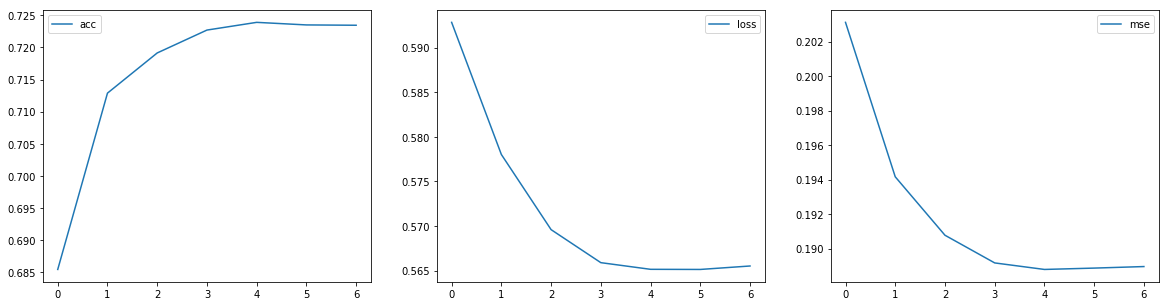

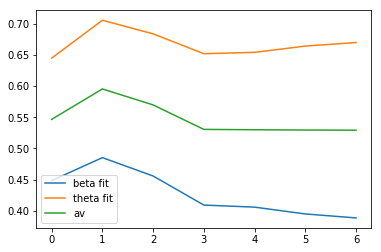

In [258]:
print("elements in h:", len(h))
for tup in h:
    print(tup)

loss, mse, acc = zip(*h)


fig = plt.gcf()
#     plt.xlabel("#iterations")
#     plt.ylabel("fit error (RMSE)")
#     plt.suptitle("Neural-MLTM Parameter Fitting")
#     plt.title("(skills=5, items=10, students=100)")
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].plot(acc, label="acc")
axes[1].plot(loss, label="loss")
axes[2].plot(mse, label="mse")

fig.set_size_inches(20, 5)
for i in [0,1,2]:
    axes[i].legend()
plt.show()

av_fit_rmses = []
for b,th in zip(b_fit_rmses, th_fit_rmses):
    av = (b+th)/2.0
    av_fit_rmses.append(av)
    
plt.plot(b_fit_rmses, label="beta fit")
plt.plot(th_fit_rmses, label="theta fit")
plt.plot(av_fit_rmses, label="av")
plt.legend()
plt.show()
# fig = plt.gcf()
# fig.set_size_inches(8, 5)
# plt.xlabel("#iterations")
# plt.ylabel("fit error (RMSE)")
# plt.suptitle("Neural-MLTM Parameter Fitting")
# plt.title("(skills=5, items=10, students=100)")
# plt.legend()
# plt.show()


In [259]:
from scipy.spatial.distance import cosine

real_wgts = array([ q.betas for q in qs ])
pred_wgts = q_table.get_weights()[0]
pred_wgts = numpy.round(pred_wgts,1)

out_cols = [None] * len(real_wgts.T)
curr_sel = None
curr_ix = None
n_iters = 10
chosen = None

indices = range(len(real_wgts.T))

min_total_err = math.inf
for i in range(100): #len(indices)**2):
    print("i is ",i)
    real_used = set()
    pred_used = set()
    while len(pred_used) < len(indices):
        curr_mse = math.inf
        for rix in numpy.random.permutation(indices):
            if rix in real_used:
                continue
            real_col = real_wgts.T[rix]
            for cix in numpy.random.permutation(indices):
                if cix in pred_used:
                    continue
                pred_col = pred_wgts.T[cix]
                mse = numpy.mean(numpy.abs( pred_col - real_col))
                print("mae is ",mse)
                if mse < curr_mse:
                    print("best match", cix, rix)
                    print(real_col)
                    print(pred_col)
                    curr_sel = pred_col
                    curr_mse = mse
                    curr_ix = cix
                    curr_real_ix = rix
        print("---")
        real_used.add(curr_real_ix)
        pred_used.add(curr_ix)
        out_cols[curr_real_ix] = curr_sel
    out_col_arr = array(out_cols).T
    total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
#     total_err = cosine(out_col_arr.flatten(), real_wgts.flatten())
    mean_ll = numpy.mean( out_col_arr - real_wgts )
    if total_err < min_total_err:
        min_total_err = total_err
        best_ll = mean_ll
        chosen = out_col_arr
        print("new total min mae:", min_total_err)
        print("new best ll", best_ll)
        
print("real", real_wgts)
# print(pred_wgts)
print("out", chosen)
print("elementwise mae:", min_total_err)
print("mean lead/lag", mean_ll)


i is  0
mae is  1.40199999733
best match 1 0
[ 1.8  0.7  2.9  0.7  0.9  1.8  1.3  3.3  1.1  2.9  0.2  3.2  2.6  1.5  3.4
  2.9  2.6  1.3  1.1  2.4  3.   1.3  0.4  1.9  0.2  2.7  2.9  0.5  2.9  2.6
  3.3  2.5  0.8  3.   0.1  1.5  2.3  2.7  0.5  3.   0.   0.8  2.3  2.3  2.7
  3.1  2.2  0.8  1.7  2.1  0.9  2.8  1.3  0.2  1.5  2.7  2.6  1.3  0.   3.6
  1.7  2.   1.1  2.   0.9  1.9  2.4  0.1  1.   0.2  0.2  2.5  1.4  3.   2.
  2.4  0.2  0.6  0.6  0.1  0.3  3.5  2.7  0.2  1.4  1.   3.1  2.5  2.9  2.
  0.4  0.9  0.2  1.9  0.2  2.8  1.9  1.2  1.5  2.4]
[ 3.20000005  0.2         3.5999999   1.89999998  0.69999999  1.89999998
  0.1         0.1         0.          0.69999999  3.29999995  2.70000005
  0.          2.9000001   0.60000002  3.0999999   2.79999995  2.5999999
  3.5999999   1.89999998  3.70000005  0.1         0.          2.5         0.1
  2.29999995  3.29999995  1.29999995  2.          1.60000002  0.5
  1.70000005  1.20000005  1.39999998  2.0999999   2.4000001   0.
  3.20000005  0.899999

[ 1.8  0.7  2.9  0.7  0.9  1.8  1.3  3.3  1.1  2.9  0.2  3.2  2.6  1.5  3.4
  2.9  2.6  1.3  1.1  2.4  3.   1.3  0.4  1.9  0.2  2.7  2.9  0.5  2.9  2.6
  3.3  2.5  0.8  3.   0.1  1.5  2.3  2.7  0.5  3.   0.   0.8  2.3  2.3  2.7
  3.1  2.2  0.8  1.7  2.1  0.9  2.8  1.3  0.2  1.5  2.7  2.6  1.3  0.   3.6
  1.7  2.   1.1  2.   0.9  1.9  2.4  0.1  1.   0.2  0.2  2.5  1.4  3.   2.
  2.4  0.2  0.6  0.6  0.1  0.3  3.5  2.7  0.2  1.4  1.   3.1  2.5  2.9  2.
  0.4  0.9  0.2  1.9  0.2  2.8  1.9  1.2  1.5  2.4]
[ 2.0999999   0.2         3.5999999   0.1         0.89999998  2.5
  1.29999995  3.5999999   0.60000002  3.70000005  0.          3.5999999
  3.0999999   0.89999998  3.70000005  3.5999999   3.5         0.69999999
  1.10000002  2.70000005  3.70000005  1.10000002  0.40000001  2.4000001
  0.1         3.5999999   3.5         0.1         3.5         3.20000005
  3.5999999   3.0999999   1.5         3.5999999   0.          1.70000005
  2.5         3.4000001   0.1         3.70000005  0.30000001  0.3

best match 0 0
[ 1.8  0.7  2.9  0.7  0.9  1.8  1.3  3.3  1.1  2.9  0.2  3.2  2.6  1.5  3.4
  2.9  2.6  1.3  1.1  2.4  3.   1.3  0.4  1.9  0.2  2.7  2.9  0.5  2.9  2.6
  3.3  2.5  0.8  3.   0.1  1.5  2.3  2.7  0.5  3.   0.   0.8  2.3  2.3  2.7
  3.1  2.2  0.8  1.7  2.1  0.9  2.8  1.3  0.2  1.5  2.7  2.6  1.3  0.   3.6
  1.7  2.   1.1  2.   0.9  1.9  2.4  0.1  1.   0.2  0.2  2.5  1.4  3.   2.
  2.4  0.2  0.6  0.6  0.1  0.3  3.5  2.7  0.2  1.4  1.   3.1  2.5  2.9  2.
  0.4  0.9  0.2  1.9  0.2  2.8  1.9  1.2  1.5  2.4]
[ 2.0999999   0.2         3.5999999   0.1         0.89999998  2.5
  1.29999995  3.5999999   0.60000002  3.70000005  0.          3.5999999
  3.0999999   0.89999998  3.70000005  3.5999999   3.5         0.69999999
  1.10000002  2.70000005  3.70000005  1.10000002  0.40000001  2.4000001
  0.1         3.5999999   3.5         0.1         3.5         3.20000005
  3.5999999   3.0999999   1.5         3.5999999   0.          1.70000005
  2.5         3.4000001   0.1         3.70000005  

  0.4  0.9  0.2  1.9  0.2  2.8  1.9  1.2  1.5  2.4]
[ 2.0999999   0.2         3.5999999   0.1         0.89999998  2.5
  1.29999995  3.5999999   0.60000002  3.70000005  0.          3.5999999
  3.0999999   0.89999998  3.70000005  3.5999999   3.5         0.69999999
  1.10000002  2.70000005  3.70000005  1.10000002  0.40000001  2.4000001
  0.1         3.5999999   3.5         0.1         3.5         3.20000005
  3.5999999   3.0999999   1.5         3.5999999   0.          1.70000005
  2.5         3.4000001   0.1         3.70000005  0.30000001  0.30000001
  2.70000005  2.9000001   3.4000001   3.5999999   2.79999995  0.5
  1.39999998  2.9000001   0.89999998  3.4000001   2.70000005  0.          2.
  3.70000005  3.5999999   1.70000005  0.          3.70000005  1.60000002
  2.70000005  0.1         2.5         1.20000005  2.20000005  2.70000005
  0.1         1.60000002  0.1         0.1         2.79999995  0.60000002
  3.5999999   3.4000001   2.79999995  0.          0.30000001  0.1         0.1
  0.  

mae is  0.370999999568
best match 1 1
[ 2.7  0.3  3.7  1.7  1.   2.3  0.2  0.   0.2  1.6  2.8  2.3  0.7  2.4  1.
  3.   2.8  2.   3.3  1.8  3.4  0.   0.6  2.3  0.2  2.3  2.8  1.3  2.1  1.8
  0.4  1.8  1.8  1.7  2.   2.2  0.6  2.6  0.9  3.3  1.   1.2  0.7  0.5  0.6
  3.   2.2  0.7  2.4  3.4  3.   1.4  3.6  0.2  3.3  3.6  3.7  2.4  2.9  2.3
  2.7  1.5  2.6  3.1  0.5  2.2  0.1  3.2  1.4  2.7  3.3  0.5  2.3  0.6  3.7
  0.6  2.2  0.6  3.   3.   2.2  1.3  0.7  2.8  2.7  1.2  3.2  2.5  0.   0.1
  0.9  0.9  2.   1.   0.7  3.4  3.   1.   1.9  1.1]
[ 3.20000005  0.2         3.5999999   1.89999998  0.69999999  1.89999998
  0.1         0.1         0.          0.69999999  3.29999995  2.70000005
  0.          2.9000001   0.60000002  3.0999999   2.79999995  2.5999999
  3.5999999   1.89999998  3.70000005  0.1         0.          2.5         0.1
  2.29999995  3.29999995  1.29999995  2.          1.60000002  0.5
  1.70000005  1.20000005  1.39999998  2.0999999   2.4000001   0.
  3.20000005  0.89999998  3.

  2.5         2.70000005]
---
i is  81
mae is  1.40199999733
best match 1 0
[ 1.8  0.7  2.9  0.7  0.9  1.8  1.3  3.3  1.1  2.9  0.2  3.2  2.6  1.5  3.4
  2.9  2.6  1.3  1.1  2.4  3.   1.3  0.4  1.9  0.2  2.7  2.9  0.5  2.9  2.6
  3.3  2.5  0.8  3.   0.1  1.5  2.3  2.7  0.5  3.   0.   0.8  2.3  2.3  2.7
  3.1  2.2  0.8  1.7  2.1  0.9  2.8  1.3  0.2  1.5  2.7  2.6  1.3  0.   3.6
  1.7  2.   1.1  2.   0.9  1.9  2.4  0.1  1.   0.2  0.2  2.5  1.4  3.   2.
  2.4  0.2  0.6  0.6  0.1  0.3  3.5  2.7  0.2  1.4  1.   3.1  2.5  2.9  2.
  0.4  0.9  0.2  1.9  0.2  2.8  1.9  1.2  1.5  2.4]
[ 3.20000005  0.2         3.5999999   1.89999998  0.69999999  1.89999998
  0.1         0.1         0.          0.69999999  3.29999995  2.70000005
  0.          2.9000001   0.60000002  3.0999999   2.79999995  2.5999999
  3.5999999   1.89999998  3.70000005  0.1         0.          2.5         0.1
  2.29999995  3.29999995  1.29999995  2.          1.60000002  0.5
  1.70000005  1.20000005  1.39999998  2.0999999   2.4000

  2.5         2.70000005]
---
i is  95
mae is  0.435000002533
best match 0 0
[ 1.8  0.7  2.9  0.7  0.9  1.8  1.3  3.3  1.1  2.9  0.2  3.2  2.6  1.5  3.4
  2.9  2.6  1.3  1.1  2.4  3.   1.3  0.4  1.9  0.2  2.7  2.9  0.5  2.9  2.6
  3.3  2.5  0.8  3.   0.1  1.5  2.3  2.7  0.5  3.   0.   0.8  2.3  2.3  2.7
  3.1  2.2  0.8  1.7  2.1  0.9  2.8  1.3  0.2  1.5  2.7  2.6  1.3  0.   3.6
  1.7  2.   1.1  2.   0.9  1.9  2.4  0.1  1.   0.2  0.2  2.5  1.4  3.   2.
  2.4  0.2  0.6  0.6  0.1  0.3  3.5  2.7  0.2  1.4  1.   3.1  2.5  2.9  2.
  0.4  0.9  0.2  1.9  0.2  2.8  1.9  1.2  1.5  2.4]
[ 2.0999999   0.2         3.5999999   0.1         0.89999998  2.5
  1.29999995  3.5999999   0.60000002  3.70000005  0.          3.5999999
  3.0999999   0.89999998  3.70000005  3.5999999   3.5         0.69999999
  1.10000002  2.70000005  3.70000005  1.10000002  0.40000001  2.4000001
  0.1         3.5999999   3.5         0.1         3.5         3.20000005
  3.5999999   3.0999999   1.5         3.5999999   0.         

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


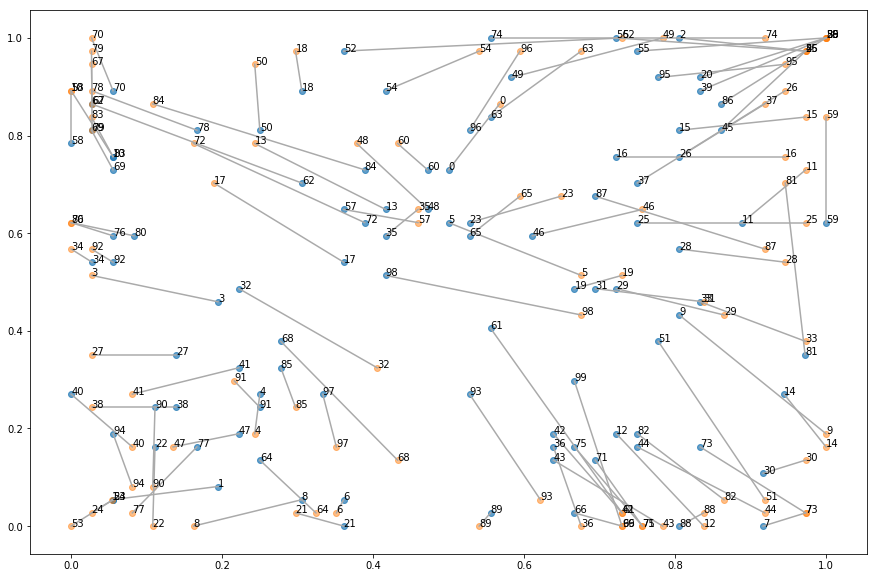

In [261]:
fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
pca2 = PCA(n_components=2)
# pca = TSNE(n_components=2)
# pca2 = TSNE(n_components=2)

itemz = array([ q.betas for q in qs ])

itemz_2 = itemz
# itemz_2 = pca.fit_transform(itemz_2)
itemz_2 = MinMaxScaler().fit_transform(itemz_2)

itemz_pred = chosen
# itemz_pred = pca.fit_transform(itemz_pred)
itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(15, 10)

for x,xh,y,yh in zip(itemz_2[:,0],itemz_pred[:,0],itemz_2[:,1],itemz_pred[:,1]):
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")

fig.gca().scatter(itemz_2[:,0], itemz_2[:,1], alpha=0.7)
fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

for i, txt in enumerate(itemz_2):
    fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

for i, txt in enumerate(itemz_pred):
    fig.gca().annotate(i, (itemz_pred[i,0], itemz_pred[i,1]))
    
fig.show()

In [ ]:
psi_wgts = s_table.get_weights()[0]
print(psi_wgts)
for psi in ss:
    print(psi.id, psi.thetas, psi_wgts[psi.id])
print("qs ====")
qn_wgts = q_table.get_weights()[0]
print(qn_wgts)
for qn in qs:
    print(qn.id, qn.betas, qn_wgts[qn.id])

In [ ]:
n_traits = 5
nn_dimensions = [1,3,5,7,9]
serieses = []
min_errs = []
n_qs = 10
n_students = 100
for ix,nnw in enumerate(nn_dimensions):
    qs = create_qs(n_qs, n_traits, nnw, optimiser=qopt)
    ss = create_students(n_students, n_traits, nnw, optimiser=qopt)
    attempts_by_psi, attempts_by_q = generate_attempts(qs,ss)
    print(qs[0].pred_betas.get_weights()[0][0])
    print(ss[0].pred_theta.get_weights()[0][0])
    resultz = calibrate(qs,ss,attempts_by_q, attempts_by_psi, n_iter=70)
    serieses.append( resultz )
#     if ix < len(serieses): #append to old series
#         (_mses,_accs) = serieses[ix]
#         _mses += mses
#         _accs += accs
#         serieuses[ix] = (_mses,_accs)
#     else: #create new series
#         serieses.append((mses,accs))
    
from pygame import mixer
mixer.init()
mixer.music.load('calibration_complete.mp3')
mixer.music.play()

In [ ]:
# import pickle
# pickle.dump( serieses, open( "serieses.p", "wb" ) )

xmax=10
xs = range(len(serieses[0][0]))[0:xmax]
print(len(serieses))
for s in serieses:
    print(len(s))
# plt.plot(xs, numpy.multiply(1,theta_rmses), 'b--')
# plt.plot(xs, numpy.multiply(1,beta_rmses), 'b')
fig, axes = plt.subplots(nrows=3, ncols=2)
print(axes.shape)
for (mses,accs, th_mses,th_accs, b_mses,b_accs),c,d in zip(serieses,["r--","y--","k-","c--","b--"],nn_dimensions):
    axes[0,0].plot(xs, numpy.multiply(1,mses[0:xmax]), c, label="nnw={}".format(d))
    axes[0,1].plot(xs, numpy.multiply(1,accs[0:xmax]), c, label="nnw={}".format(d))
    axes[1,0].plot(xs, numpy.multiply(1,th_mses[0:xmax]), c, label="nnw={}".format(d))
    axes[1,1].plot(xs, numpy.multiply(1,th_accs[0:xmax]), c, label="nnw={}".format(d))
    axes[2,0].plot(xs, numpy.multiply(1,b_mses[0:xmax]), c, label="nnw={}".format(d))
    axes[2,1].plot(xs, numpy.multiply(1,b_accs[0:xmax]), c, label="nnw={}".format(d))

# plt.plot(xs, accs, "m")
# plt.plot(xs, numpy.multiply(1,s_outer_accs), "g")7
# plt.plot(xs, numpy.multiply(1,q_outer_accs), "k")

# plt.plot(xs, numpy.multiply(1,mses), "m--")
# plt.plot(xs, numpy.multiply(1,s_outer_mses), "g--")
# plt.plot(xs, numpy.multiply(1,q_outer_mses), "k--")
for ix in range(axes.shape[0]):
    subcats = ["Combined","Student","Question"]
    for iy in range(axes.shape[1]):
        axes[ix,iy].set_xlabel("#iterations")
        axes[ix,iy].legend()
        if iy==0:
            axes[ix,iy].set_title("{} fit error".format(subcats[ix]))
            axes[ix,iy].set_ylabel("fit error (RMSE)")
        else:
            axes[ix,iy].set_title("{} fit accuracy".format(subcats[ix]))
            axes[ix,iy].set_ylabel("prediction accuracy")

fig.suptitle("Neural-MLTM Parameter Fitting (k={}, q={}, s={})".format(n_traits, n_qs, n_students))
fig.set_size_inches(18, 18)

fig.show()

In [ ]:
xs = range(len(serieses[0][0]))
print(len(serieses))
for s in serieses:
    print(len(s))
# plt.plot(xs, numpy.multiply(1,theta_rmses), 'b--')
# plt.plot(xs, numpy.multiply(1,beta_rmses), 'b')
fig, axes = plt.subplots(nrows=1, ncols=2)
print(axes.shape)

min_mses = []
max_accs = []
bmin_mses = []
bmax_accs = []

for (mses,accs, th_mses,th_accs, b_mses,b_accs),c,d in zip(serieses,["r--","y--","k-","c--","b--"],nn_dimensions):
    mm = min(th_mses)
    ma = max(th_accs)
    min_mses.append(mm)
    max_accs.append(ma)
    mm = min(b_mses)
    ma = max(b_accs)
    bmin_mses.append(mm)
    bmax_accs.append(ma)
    

axes[0].plot(nn_dimensions, numpy.multiply(1,min_mses))
axes[0].plot(nn_dimensions, numpy.multiply(1,bmin_mses))
axes[1].plot(nn_dimensions, numpy.multiply(1,max_accs))
axes[1].plot(nn_dimensions, numpy.multiply(1,bmax_accs))
axes[0].axvline(x=5, linestyle="--")
axes[1].axvline(x=5, linestyle="--")

fig.suptitle("Neural-MLTM Parameter Fitting (k={}, q={}, s={})".format(n_traits, n_qs, n_students))
fig.set_size_inches(18,4)

fig.show()